# Определение стоимости автомобилей

Заказчик: Сервис по продаже автомобилей с пробегом «Не бит, не крашен».

Вводная информация: Заказчик разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжение предоставляются исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Значение метрики RMSE должно быть меньше 2500.

## Подготовка данных

In [1]:
# Установка библиотек для Практикума
!pip install seaborn==0.13.2 -q
!pip install phik -q
!pip install scikit-learn==1.5.1 -q
!pip install optuna -q
!pip install matplotlib==3.5 -q
!pip install shap -q

In [2]:
# Импорт библиотек, классов и функций
import gc
import warnings
import time
import os
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phik
import optuna
import joblib
import lightgbm as lgb
import catboost as cb
import shap
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
from tqdm.notebook import tqdm

In [3]:
# Константы и настройка
RANDOM_STATE = 42
SCORING = "neg_root_mean_squared_error"

# Поиск гиперпараметров для моделей,
# иначе подставляются уже найденные значения для ускорения.
# Установить True чтобы проверить поиск гиперпараметров.
STUDY = True

pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', 30)
sns.set_theme()

# Пустой класс, который используется без поиска гиперпараметров бустинга
class MyStudy(object):
    pass

### Загрузка и предобработка данных

In [4]:
try:
    data = pd.read_csv("/datasets/autos.csv", parse_dates=["DateCrawled", "DateCreated", "LastSeen"])
except:
    data = pd.read_csv("https://code.s3.yandex.net/datasets/autos.csv", 
                       parse_dates=["DateCrawled", "DateCreated", "LastSeen"])

In [5]:
display(data.apply(
    lambda x: pd.Series({
        "Без пропусков": x.count(), "Пропущено": x.isna().sum(), 
        "Процент": x.isna().mean(), "Тип данных:": x.dtype
    })
).T.style.format("{:.1%}", subset="Процент").background_gradient(
    cmap=sns.diverging_palette(250, 25, as_cmap=True), 
    axis=0, subset=["Без пропусков", "Пропущено", "Процент"]
))
print("Выборка 5 случайных записей датасета:")
data.sample(5, random_state=RANDOM_STATE)

Выборка 5 случайных записей датасета:


DateCrawled  Price VehicleType  RegistrationYear Gearbox  \
294049 2016-03-20 20:54:33  19999       wagon              2014  manual   
76415  2016-03-25 12:56:02  14250       wagon              2011  manual   
212563 2016-03-09 13:46:02   2850       wagon              2001  manual   
109307 2016-03-30 11:39:47     50       small              1996  manual   
248545 2016-03-28 23:37:54    500         NaN              2016  manual   

        Power     Model  Kilometer  RegistrationMonth  FuelType  \
294049    122      leon      30000                  3    petrol   
76415     140        a3      70000                  6  gasoline   
212563    131    passat     150000                  9  gasoline   
109307     60     corsa     150000                  8    petrol   
248545     82  a_klasse     150000                  2    petrol   

                Brand Repaired DateCreated  NumberOfPictures  PostalCode  \
294049           seat       no  2016-03-20                 0       22089   
76415            audi      NaN  2016-03-25                 0       45770   
212563     volkswagen       no  2016-03-09                 0       38259   
109307           opel      yes  2016-03-30                 0        7957   
248545  mercedes_benz      NaN  2016-03-28                 0       49356   

                  LastSeen  
294049 2016-03-27 10:47:13  
76415  2016-03-29 11:48:26  
212563 2016-03-12 11:16:57  
109307 2016-04-03 00:46:29  
248545 2016-03-30 23:17:28

Произведена загрузка исходных данных из файла `/datasets/autos.csv`, файл содержит 354'369 записей:
- **DateCrawled** — *дата скачивания анкеты из базы*, пропуски отсутствуют.
- **Price** - *цена автомобиля*, пропуски отсутствуют.
- **VehicleType** — *тип автомобильного кузова*, имеются пропуски по 37'490 записям (10.6%).
- **RegistrationYear** — *год регистрации автомобиля*, пропуски отсутствуют.
- **Gearbox** — *тип коробки передач*, имеются пропуски по 19'833 записям (5.6%).
- **Power** — *мощность (л. с.)*, пропуски отсутствуют.
- **Model** — *модель автомобиля*, имеются пропуски по 19'705 записям (5.6%).
- **Kilometer** — *пробег (км)*, пропуски отсутствуют.
- **RegistrationMonth** — *месяц регистрации автомобиля*, пропуски отсутствуют.
- **FuelType** — *тип топлива*, имеются пропуски по 32'895 записям (9.3%).
- **Brand** — *марка автомобиля*, пропуски отсутствуют.
- **Repaired** — *была машина в ремонте или нет*, имеются пропуски по 71'154 записям (20.1%).
- **DateCreated** — *дата создания анкеты*, пропуски отсутствуют.
- **NumberOfPictures** — *количество фотографий автомобиля*, пропуски отсутствуют.
- **PostalCode** — *почтовый индекс владельца анкеты (пользователя)*, пропуски отсутствуют.
- **LastSeen** — *дата последней активности пользователя*, пропуски отсутствуют.

Приведем заголовки столбцов к стандарту PEP8, также сократим некоторые наименования для более удобного просмотра.

In [6]:
data.columns = [re.sub(r"(?<!^)(?=[A-Z])", "_", cols).lower() for cols in data.columns]
data.rename(columns={
    "registration_year": "reg_year", 
    "registration_month": "reg_month",
    "number_of_pictures": "num_of_pict"
}, inplace=True)
print("Новые наименования столбцов: ", data.columns.to_numpy())

Новые наименования столбцов:  ['date_crawled' 'price' 'vehicle_type' 'reg_year' 'gearbox' 'power'
 'model' 'kilometer' 'reg_month' 'fuel_type' 'brand' 'repaired'
 'date_created' 'num_of_pict' 'postal_code' 'last_seen']


### Исследовательский анализ данных

Целевой признак - цена автомобиля, который является количественным, соответственно перед моделями стоит задача регрессии.

In [7]:
# Фукнция добавления заголовков и подписей на график
def add_plot_titles(
    suptitle=None, suptitle_size=16, suptitle_color="C0",
    xlabel=None, xlabel_size=None, xlabel_color="k",
    ylabel=None, ylabel_size=None, ylabel_color="k",
    show=False
):
    if suptitle: plt.suptitle(suptitle, size=suptitle_size, color=suptitle_color)
    if xlabel: plt.xlabel(xlabel, size=xlabel_size, color=xlabel_color)
    if ylabel: plt.ylabel(ylabel, size=ylabel_size, color=ylabel_color)
    if show: 
        plt.tight_layout()
        plt.show()
# ------------------------------------------------------
        
# Функция вывода информации для категориальных признаков
def show_cat(
    data=data, x=None, y=None, hue=None, kind="count", 
    estimator=np.median, order=None, hue_order=None, figsize=(14, 2),
    suptitle=None, xlabel=None, ylabel=None, legend_title=None,
    describe=True, percent=True, by_category=False
):
    # Проверяем какой столбец содержит категориальные признаки
    num_col = None
    if x and y:
        if pd.api.types.is_object_dtype(data[y]):
            cat_col = y
            num_col = x
        elif pd.api.types.is_object_dtype(data[x]):
            cat_col = x
            num_col = y
        else: raise Exception(
            "Neither the x nor y variable appears to be categorical. Both x and y variables are numeric."
        )
    elif y and pd.api.types.is_object_dtype(data[y]): 
        cat_col = y
    elif x and pd.api.types.is_object_dtype(data[x]): 
        cat_col = x
    else: raise Exception("Either `x` or `y` must be categorical")
    
    # Вывод графика, добавление заголовков
    fg = sns.catplot(
        data=data, x=x, y=y, hue=hue, kind=kind, 
        order=order, hue_order=hue_order, estimator=estimator,
        height=figsize[1], aspect=figsize[0]/figsize[1]
    )
    add_plot_titles(suptitle=suptitle, xlabel=xlabel, ylabel=ylabel)
    if fg.legend:
        fg.legend.set_bbox_to_anchor((1, 0.5))
        if legend_title:
            fg.legend.set_title(legend_title)
    plt.tight_layout()
    plt.show()
    
    # Вывод описания
    if describe:
        # Если не указан порядок категорий, получаем его из графика
        if not order:
            if cat_col == y:
                order = [tick.get_text() for tick in fg.ax.get_yticklabels()]
            else:
                order = [tick.get_text() for tick in fg.ax.get_xticklabels()]
        # Если не указан порядок легенды, получаем его из графика
        if hue and not hue_order: 
            hue_order = [l.get_text() for l in fg.legend.get_texts()]
            
        # Получаем данные для вывода числовой информации
        if not num_col and not hue:
            desc = data[cat_col].value_counts()
        elif not hue:
            desc = data.groupby(by=cat_col)[num_col].agg(estimator)
        elif not num_col:
            desc = pd.crosstab(data[hue], data[cat_col])
        else:
            desc = data.pivot_table(
                values=num_col, index=hue, columns=cat_col, aggfunc=estimator
            )
            desc = desc.reindex(index=hue_order)
        
        # Изменение заголовков к таблице
        if hue and legend_title: desc.index.rename(legend_title, inplace=True)
        else: 
            if cat_col == y and xlabel: desc = desc.rename(xlabel)
            if cat_col == x and ylabel: desc = desc.rename(ylabel)
            desc = desc.to_frame().T
        if cat_col == y and ylabel: desc.columns.rename(ylabel, inplace=True)
        if cat_col == x and xlabel: desc.columns.rename(xlabel, inplace=True)
        desc = desc.reindex(columns=order)
        
        # Вывод таблицы
        if percent: 
            desc = desc.apply(
                lambda x: x / np.sum(x), 
                axis = 0 if by_category else 1
            )
            display(
                desc.style.background_gradient(
                    cmap=sns.diverging_palette(250, 25, as_cmap=True), axis=1
                ).format("{:.2%}")
            )
        else:
            display(
                desc.style.background_gradient(
                    cmap=sns.diverging_palette(250, 25, as_cmap=True), axis=1
                ).format("{:,.2f}")
            )
# ------------------------------------------------
        
# Фукнция вывода описания количественных признаков
def show_describe(
    data=data, percentiles=[0.0013, 0.01, .25, .5, .75, .99, .9987],
    datetime_is_numeric=True, normal_test=True, normal_func=normaltest,
    column_order=None
):
    if isinstance(data, pd.Series):
        data = data.to_frame()
    result = data.describe(
        percentiles, datetime_is_numeric=datetime_is_numeric
    ).T
    # Тест для проверки нормальности
    if normal_test:
        for col in data.columns:
            stat, p = normal_func(data[col].dropna().astype("int64").astype("float"))
            if p > 0.05:
                result.loc[col, "Gaussian"] = "Probably"
            else:
                result.loc[col, "Gaussian"] = "Probably NOT"
            result.loc[col, "p_value"] = p
    if column_order:
        for col in column_order:
            if col not in result.index:
                column_order.remove(col)
        for col in result.index:
            if col not in column_order:
                column_order.append(col)
    sst = result.columns[1:-2] if normal_test else result.columns[1:]
    fmt = {}
    for col in result:
        if col == 'count': fmt[col] = "{:,.0f}"
        if result[col].dtype == np.float64: fmt[col] = "{:,.2f}"
    display(result.reindex(column_order).style.background_gradient(
        cmap=sns.diverging_palette(250, 25, as_cmap=True), 
        axis=1, subset=sst
    ).format(fmt))
# ------------------------------------------------------
    
# Фукнция вывода информации для количественных признаков
def show_num(
    data=data, x=None, y=None, hue=None, hue_order=None, stat="count", bins="auto", 
    binwidth=None, binrange=None, discrete=False, multiple="stack", kde=True,
    log_scale=False, kind="hist", orient="x", estimator=np.median, native_scale=True,
    suptitle=None, xlabel=None, ylabel=None, legend_title=None,
    figsize=(14, 5), boxplot=True, height_ratios=(.9, .1), 
    xlim=None, ylim=None, describe=True, normal_test=True, 
    normal_func=normaltest
):
    if boxplot:
        fig, (ax_main, ax_box) = plt.subplots(2, sharex=True, 
                                              gridspec_kw={"height_ratios": height_ratios})
        fig.set_size_inches(figsize)
        sns.boxplot(data=data, x=x, y=hue, 
                order=hue_order, ax=ax_box
            ).set(ylabel=legend_title, xlabel=None)
    else:
        plt.figure(figsize=figsize)
        ax_main = plt.gca()
    if kind == "hist":
        sns.histplot(
            data, x=x, y=y, hue=hue, hue_order=hue_order, stat=stat, bins=bins,  
            binwidth=binwidth, binrange=binrange, discrete=discrete, kde=kde, 
            multiple=multiple, log_scale=log_scale, ax=ax_main
        ).set(ylabel=ylabel)
    elif kind == "bar":
        sns.barplot(
            data, x=x, y=y, hue=hue, hue_order=hue_order, orient=orient,
            estimator=estimator, native_scale=native_scale, ax=ax_main
        ).set(ylabel=ylabel)
    elif kind == "count":
        sns.countplot(
            data, x=x, y=y, hue=hue, hue_order=hue_order, native_scale=native_scale, ax=ax_main
        ).set(ylabel=ylabel)
    else: raise Exception(
            "Invalid `kind`: '{kind}'. Options are 'hist' and 'bar'"
        )
    if legend_title and ax_main.get_legend():
        ax_main.get_legend().set_title(legend_title)
    if ax_main.get_legend() is not None:
        column_order = [i.get_text() for i in ax_main.get_legend().texts]
    else: column_order = None
    add_plot_titles(suptitle=suptitle, xlabel=xlabel)
    plt.tight_layout()
    if xlim: plt.xlim(xlim)
    if ylim: plt.ylim(ylim)
    plt.show()
    if describe:
        if hue: 
            data=data.pivot(columns=hue, values=x)
            if legend_title: data.index.rename(legend_title, inplace=True)
        else: data = data[x].rename(xlabel if xlabel else x)
        show_describe(data, normal_test=normal_test, normal_func=normal_func, column_order=column_order)

#### Целевой признак

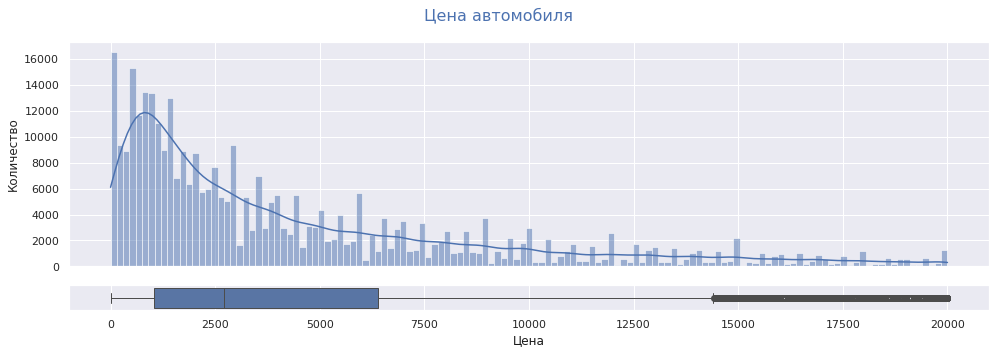

In [8]:
show_num(x="price", suptitle="Цена автомобиля", xlabel="Цена", ylabel="Количество")

По целевому признаку медиана стоимости автомобиля составляет 2'700, при этом среднее значение равно 4'514. Это говорит о наличии небольшого количества автомобилей с более высокими ценами, а основные данные смещены к более низким ценам. Максимальное значение составляет 20'000, при этом 75% всех автомобилей находятся в пределах 6'400. Стоит отметить, что довольно большое количество автомобилей, не менее 1% имеют нулевую цену.

In [9]:
data.sort_values("price").head(15)

date_crawled  price vehicle_type  reg_year gearbox  power  \
205926 2016-03-14 14:53:09      0        small      2002  manual     75   
204097 2016-03-10 20:42:26      0        small      1999  manual    210   
204099 2016-03-20 20:52:40      0          NaN      2000     NaN      0   
204104 2016-03-28 13:45:31      0        wagon      1999    auto    193   
62604  2016-03-13 19:26:04      0        sedan      1982  manual    131   
103238 2016-03-31 23:37:54      0          NaN      1960     NaN      0   
282842 2016-03-12 06:36:51      0        small      1995  manual      0   
334981 2016-03-05 17:25:22      0          NaN      2017  manual      0   
85342  2016-03-08 13:36:46      0        sedan      1996    auto      0   
282811 2016-03-10 16:49:22      0          NaN      1995     NaN      0   
62599  2016-03-08 12:37:44      0  convertible      1993  manual    105   
62662  2016-03-17 13:38:22      0          NaN      2000     NaN      0   
103252 2016-03-17 13:49:06      0          bus      2004  manual      0   
256604 2016-03-11 10:49:32      0        sedan      2011  manual    101   
256622 2016-03-31 18:52:42      0        sedan      1999  manual    107   

         model  kilometer  reg_month fuel_type       brand repaired  \
205926   corsa     150000          5    petrol        opel      yes   
204097      a3     150000          7    petrol        audi      NaN   
204099     NaN     150000          0       NaN  volkswagen      NaN   
204104     5er     150000          5       lpg         bmw      yes   
62604    other      60000          8    petrol  alfa_romeo      yes   
103238     NaN     100000          0       NaN  volkswagen      NaN   
282842  twingo     150000         10    petrol     renault      NaN   
334981  vectra     150000         12    petrol        opel      NaN   
85342      NaN     150000          0       NaN       volvo      NaN   
282811     NaN     150000          0       NaN  volkswagen      NaN   
62599   escort     125000          0    petrol        ford      NaN   
62662      NaN     150000          0       NaN  volkswagen      NaN   
103252  megane     150000          8  gasoline     renault      yes   
256604  megane      90000         11       cng     renault      yes   
256622  megane     150000          7    petrol     renault      NaN   

       date_created  num_of_pict  postal_code           last_seen  
205926   2016-03-14            0        30966 2016-03-14 14:53:09  
204097   2016-03-10            0        85051 2016-03-15 15:19:48  
204099   2016-03-20            0         4924 2016-03-30 15:17:15  
204104   2016-03-28            0        49733 2016-04-04 15:45:13  
62604    2016-03-13            0        55422 2016-03-29 14:15:53  
103238   2016-03-31            0        34134 2016-04-07 02:44:20  
282842   2016-03-12            0        71229 2016-03-12 09:41:28  
334981   2016-03-05            0        57520 2016-03-12 18:45:26  
85342    2016-03-08            0        44379 2016-03-09 22:15:15  
282811   2016-03-10            0        26607 2016-04-05 16:44:45  
62599    2016-03-08            0        27432 2016-03-10 15:15:26  
62662    2016-03-17            0        24395 2016-03-20 14:18:57  
103252   2016-03-17            0        72213 2016-03-17 13:49:06  
256604   2016-03-11            0        38550 2016-04-06 23:46:59  
256622   2016-03-31            0        28790 2016-04-06 12:46:47

Заметно, что автомобили с нулевой ценой имеют срок регистрации более 10 лет, хотя имеется запись Opel Vectra 2017 года регистрации, анкета которой создана в 2016 году. Также достаточно часто встречаются пропущенные значения признаков vehicle_type, gearbox, model и repaired, также часто встречаются автомобили после ремонта. Говорить об ошибках заполнения сложно, возможно пользователи готовы бесплатно отдать имеющийся автомобиль, что довольно странно, хотя для таких авто могут быть обременения или высокая налоговая нагрузка, поэтому владельцы готовы избавиться от них. Также можно отметить, что в пробег не превышает 150'000 километров.

In [10]:
data.sort_values("price", ascending=False).head(15)

date_crawled  price vehicle_type  reg_year gearbox  power  \
302739 2016-04-02 14:51:39  20000        wagon      2011    auto    170   
315772 2016-03-08 15:38:56  20000        sedan      2010    auto    184   
228640 2016-04-02 15:57:05  20000        sedan      2011    auto    265   
212039 2016-03-21 17:37:38  20000        sedan      2011    auto    265   
211999 2016-03-20 18:50:23  20000        small      2012  manual    143   
44271  2016-03-29 17:39:36  20000          NaN      2000     NaN      0   
242045 2016-04-01 21:45:49  20000        sedan      2014    auto      0   
128747 2016-04-04 18:43:07  20000        wagon      2014  manual    136   
332704 2016-04-02 14:55:11  20000          bus      2011  manual    140   
99684  2016-04-05 11:47:48  20000        coupe      2008    auto    354   
211319 2016-03-14 00:36:56  20000        coupe      2009    auto    272   
95559  2016-03-28 20:25:38  20000        sedan      2011    auto    265   
320429 2016-03-22 20:57:59  20000        sedan      2011    auto    265   
128238 2016-03-14 19:51:49  20000        wagon      2010  manual    245   
24532  2016-03-28 12:39:31  20000        sedan      1986    auto    150   

              model  kilometer  reg_month fuel_type           brand repaired  \
302739       passat     150000          2  gasoline      volkswagen       no   
315772          5er     125000         11  gasoline             bmw       no   
228640     c_klasse      50000         11  gasoline   mercedes_benz       no   
212039     c_klasse      50000         11  gasoline   mercedes_benz       no   
211999           a1      50000          4  gasoline            audi       no   
44271           NaN     150000          0       NaN  sonstige_autos      NaN   
242045         golf      30000          9  gasoline      volkswagen       no   
128747        astra      40000          2  gasoline            opel       no   
332704  transporter     150000          8  gasoline      volkswagen       no   
99684         other     150000         11    petrol            audi       no   
211319           a5      40000          4    petrol            audi       no   
95559      c_klasse      50000         11  gasoline   mercedes_benz       no   
320429     c_klasse      50000         11  gasoline   mercedes_benz       no   
128238          3er     150000          4  gasoline             bmw       no   
24532           NaN     150000          6    petrol  sonstige_autos       no   

       date_created  num_of_pict  postal_code           last_seen  
302739   2016-04-02            0        84085 2016-04-06 13:17:44  
315772   2016-03-08            0        53347 2016-04-06 06:46:49  
228640   2016-04-02            0        60311 2016-04-02 16:44:15  
212039   2016-03-21            0        10115 2016-03-21 17:37:38  
211999   2016-03-20            0        88696 2016-04-07 02:45:20  
44271    2016-03-29            0        27283 2016-03-29 17:39:36  
242045   2016-04-01            0        33189 2016-04-05 19:17:47  
128747   2016-04-04            0        95119 2016-04-06 20:44:49  
332704   2016-04-02            0        52391 2016-04-06 13:17:52  
99684    2016-04-05            0        90763 2016-04-05 11:47:48  
211319   2016-03-13            0        13349 2016-04-07 06:15:52  
95559    2016-03-28            0        60311 2016-03-28 20:25:38  
320429   2016-03-22            0        10115 2016-03-22 21:44:03  
128238   2016-03-14            0        94548 2016-04-06 05:46:04  
24532    2016-03-28            0        51145 2016-04-06 15:15:37

По наиболее высокой цене в представленной выборке заметно наличие автомобилей более позднего года регистрации, хотя встречаются и автомобили 1986 года. Также имеются автомобили с пробегом 150'000 километров, год выпуска которых выше предыдущего списка. Возможно это максимальное значение, которое возможно было вводить в анкете. Также заметно, что ни одиного автомобиля цена не превышает 20'000, возможно это также ограничение по которому производилась выборка.

#### Категориальные признаки

Все пропуски значений приходятся на категориальные признаки, в первую очередь проведем оценку таких признаков. Оценим уникальные значения категориальных признаков для автомобиля, такие как марка, модель, тип кузова, тип КПП и вид топлива, а также признак ремонта.

In [11]:
cat_cols = ["brand", "model", "vehicle_type", "gearbox", "fuel_type", "repaired"]
for col in cat_cols:
    print(f"По признаку '{col}':", end=" ")
    if len(data[col].unique()) > 50:
        print("количество уникальных значений составляет", len(data[col].unique()))
    else:
        print(data[col].unique())

По признаку 'brand': ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']
По признаку 'model': количество уникальных значений составляет 251
По признаку 'vehicle_type': [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
По признаку 'gearbox': ['manual' 'auto' nan]
По признаку 'fuel_type': ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
По признаку 'repaired': [nan 'yes' 'no']


По типу топлива `fuel_type` можно заметить категории `petrol` и `gasoline`, которые в переводе означают одно и то же - бензин, просто используются данные названия в разных регионах мира. Рассмотрим подробнее данный вопрос при детальном изучении признака. По остальным признакам явных дубликатов не наблюдается, рассмотрим каждый признак отдельно.

##### Марка автомобиля

В представленной выборке пропуски в категориальных признаков отсутствуют только по марке автомобиля, оценим распределение выборки по этому признаку.

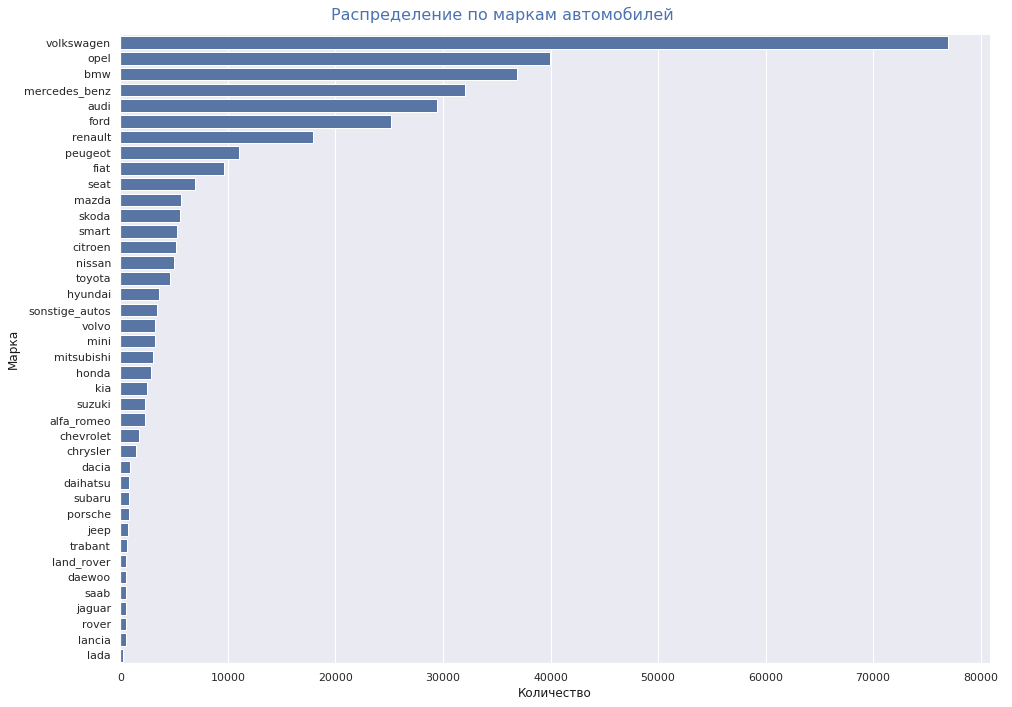

In [12]:
show_cat(
    y="brand", suptitle="Распределение по маркам автомобилей", 
    order = data["brand"].value_counts().index.to_list(),
    xlabel="Количество", ylabel="Марка", figsize=(14, 10)
)

Наиболее популярные марки автомобилей находятся вверху списка, возглавляет который Volkswagen. Также имеется марка sonstige_autos, онлайн словари определили, что это немецкий язык и переводится как `другие автомобили`. Можно предположить, что данный датасет из Германии. Вероятно поэтому достаточно популярная в постсоветских странах марка Lada находится внизу списка, а также недостаточную популярность имеют японские марки автомобилей, выше которых располагаются французские авто.

Также оценим какие наиболее распространенные марки для нулевого значения целевой переменной.

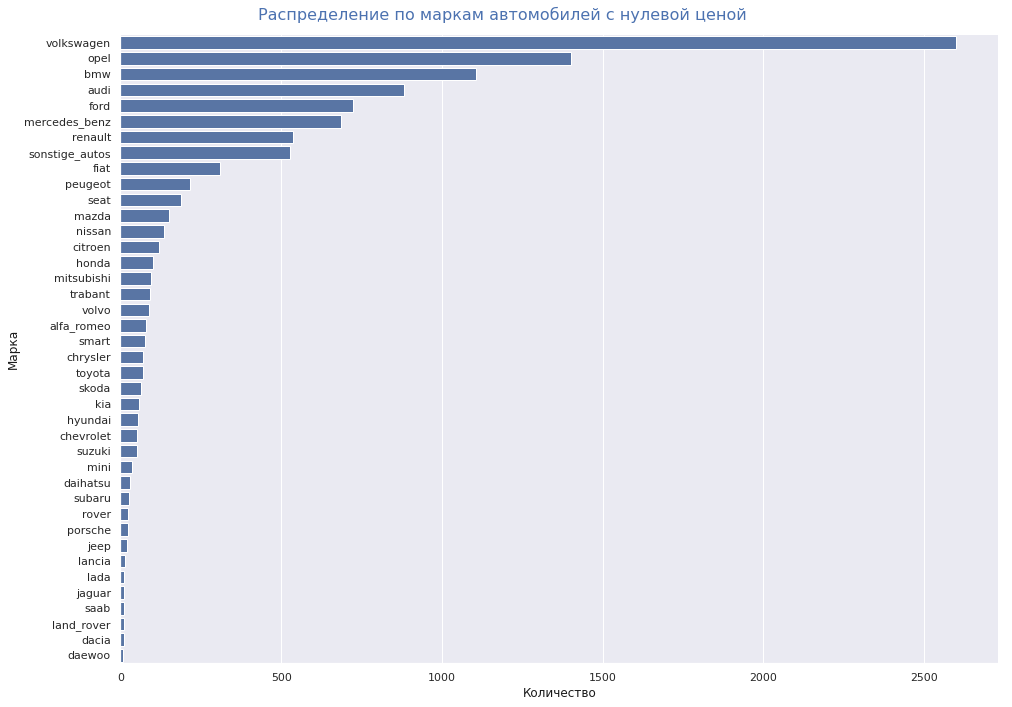

In [13]:
show_cat(
    data=data.query("price == 0"), y="brand", 
    suptitle="Распределение по маркам автомобилей с нулевой ценой", 
    order = data.query("price == 0")["brand"].value_counts().index.to_list(),
    xlabel="Количество", ylabel="Марка", figsize=(14, 10)
)

Нулевое значение целевой переменной представлено широким списком марок, распределение близко к общему распределению, количество анкет повышается для более популярных марок авто, явных аномалий не наблюдается.

Оценим средние цены автомобилей по маркам.

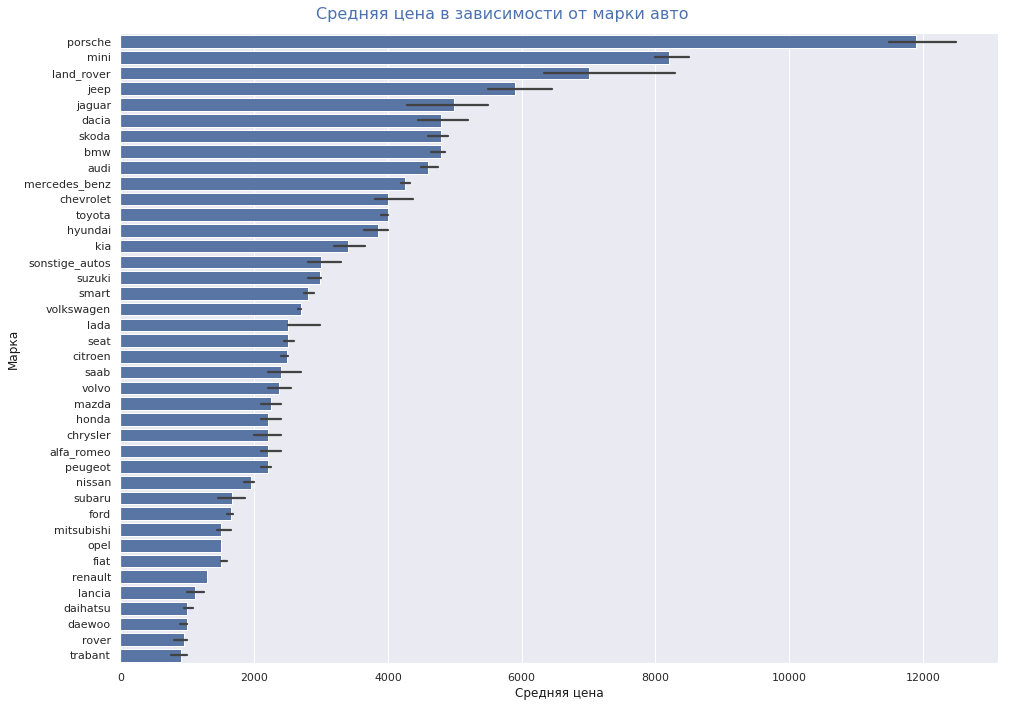

In [14]:
brand_order = data.groupby("brand")["price"].median().sort_values(ascending=False).index.to_list()
show_cat(
    x="price", y="brand", kind="bar", percent=False,
    order = brand_order,
    suptitle="Средняя цена в зависимости от марки авто",
    xlabel="Средняя цена", ylabel="Марка", figsize=(14, 10)
)

Наиболее высокая средняя цена у марки Porshe, дальше идут марки mini, land_rover и jeep. После располагаются автомобили имеющими умеренно высокие средние цены. Прочие авто `sonstige_autos` разделяют автомобили с умеренно высокими и средними ценами. Наиболее низкие средние цены у автомобилей малораспространенных марок trabant, rover, daewoo, daihatsu и lancia.

##### Признак ремонта

По признаку ремонта автомобиля наибольшее количество пропусков, вероятно эта информация не была указана. Так как мы не можем определить был проведен ремонт или нет, добавим новую категорию `NA` (сокращенно от `not assigned`). Данная категория будет промежуточной между категориями no и yes. Категория будет заглавными буквами, чтобы быстро отличить ее от других.

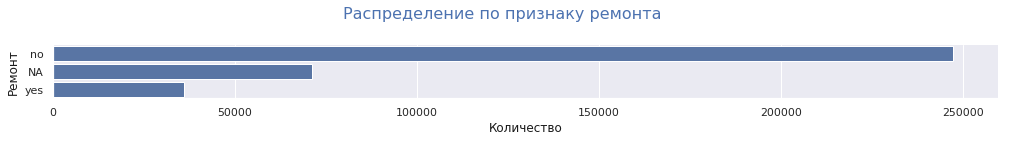

In [15]:
data.repaired.fillna("NA", inplace=True)
show_cat(
    y="repaired", order=["no", "NA", "yes"],
    suptitle="Распределение по признаку ремонта", 
    xlabel="Количество", ylabel="Ремонт"
)

Заметно, что большая часть автомобилей не ремонтировалась. Отремонтированных всего чуть больше 10%, не указано о проведении ремонта более чем в 20% случаев. Оценим средние цены в зависимости от признака ремонта.

Также оценим распределение анкет по признаку ремонта для нулевого целевого признака.

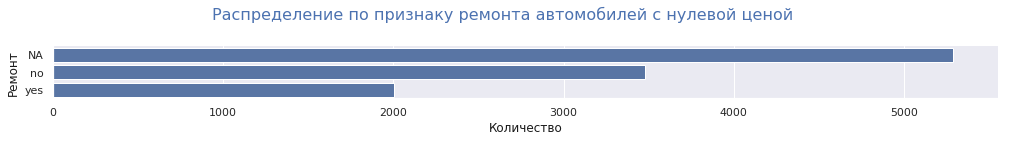

In [16]:
show_cat(
    data.query("price == 0"), y="repaired", order=["NA", "no", "yes"],
    suptitle="Распределение по признаку ремонта автомобилей с нулевой ценой", 
    xlabel="Количество", ylabel="Ремонт"
)

Для автомобилей с нулевой ценой преобладание автомобилей без ремонта существенно снизилось с 69.75% до 32.3% в пользу автомобилей без указания признака `NA` (более 49%) и к автомобилям с ремонтом (более 18.6%).

Оценим средние цены автомобилей в зависимости от признака ремонта.

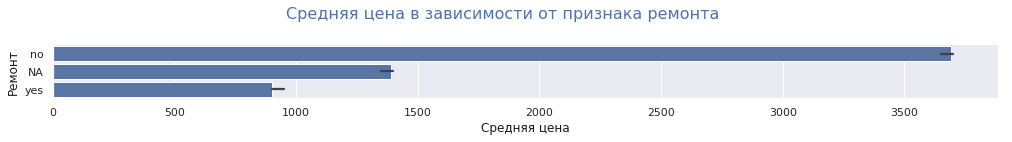

In [17]:
repaired_order = data.groupby("repaired")["price"].median().sort_values(ascending=False).index.to_list()
show_cat(
    x="price", y="repaired", kind="bar", order=repaired_order,
    suptitle="Средняя цена в зависимости от признака ремонта",
    xlabel="Средняя цена", ylabel="Ремонт", percent=False
)

По признаку ремонта средняя цена существенно выше для автомобилей без ремонта, наименьшая у автомобилей с ремонтом. Если признак не указан, то цена выше, однако довольно близка к автомобилям после ремонта. Это также подтверждает то, что если не указан данный признак, то могут в эту категорию входить как автомобиле после ремонта, так и без него, поэтому лучше его выделить в отдельную категорию.

##### Тип кузова

Оценим к каким маркам автомобилей относятся пропущенные значения по признаку vehicle_type, так как по признаку brand отсутствуют пропуски.

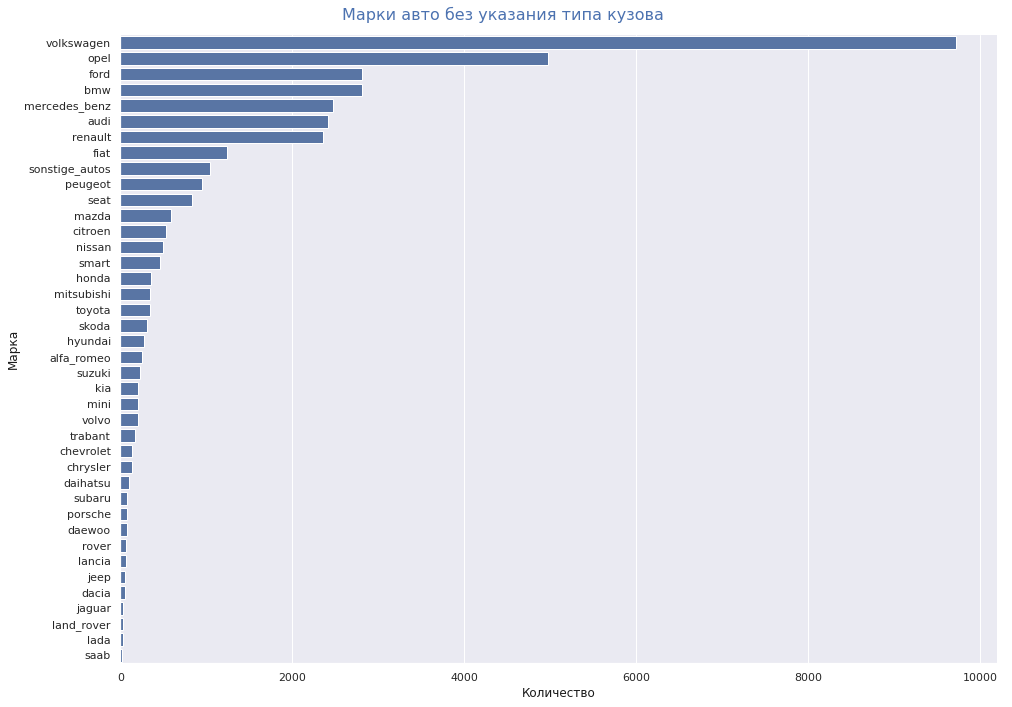

In [18]:
show_cat(
    data=data.query("vehicle_type.isna()"), y="brand", figsize=(14, 10),
    order=data.query("vehicle_type.isna()")["brand"].value_counts().index.to_list(),
    suptitle="Марки авто без указания типа кузова", xlabel="Количество", ylabel="Марка"
)

Очевидно, что большая часть пропусков приходится на популярные марки автомобилей, но в целом присутствуют в большинстве марок. Вероятно, что некоторые пользователи могут не разбираться в типах кузова автомобиля, поэтому не указали данный признак или просто не захотели его указывать. Возможно имеет смысл закрыть такие пропуски путем сравнения марки и модели автомобиля. Для этого оценим представленные в датасете автомобили без пропусков.

In [19]:
data.groupby(by=["brand", "model", "vehicle_type"])["brand"].count()

brand       model     vehicle_type
alfa_romeo  145       coupe             2
                      other             1
                      sedan            13
                      small            19
            147       coupe            27
                                     ... 
volvo       v70       coupe             1
                      wagon           608
            xc_reihe  sedan             3
                      suv             216
                      wagon            41
Name: brand, Length: 1411, dtype: int64

По нескольким строкам из выборки заметно, что пользователи допускают ошибки, указывая такие типы кузова, которые не относятся к данным моделям. Для сервиса необходимо проработать вопрос корректного ввода - ограничить возможность выбора вариантов путем использования справочников моделей автомобилей, в которых будет указаны типы кузова, типы используемых двигателей и так далее в зависимости от года выпуска автомобилей, а также другие возможные варианты переоборудования (например установка ГБО и пр.), при этом обеспечить обязательное указание признаков путем автоматической подстановки наиболее популярных параметров с возможностью их изменения.

Так как сервис представлен как есть и данные будут предоставляться с пропусками, будем закрывать пропущенные значения значением `NA`.

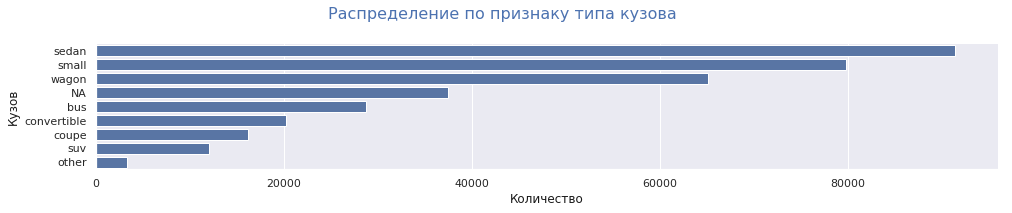

In [20]:
data["vehicle_type"].fillna("NA", inplace=True)
show_cat(
    y="vehicle_type", suptitle="Распределение по признаку типа кузова", 
    order=data["vehicle_type"].value_counts().index.to_list(),
    xlabel="Количество", ylabel="Кузов", figsize=(14, 3)
)

В представленном датасете основными являются типы кузова sedan, small и wagon. Довольно большое количество - порядка 10.6% не указано. Наименьшее количество относится к типу other, при этом также очень малый процент типа SUV, что также может говорить о том, что это европейские данные, так как на постсоветском пространстве внедорожники имеют достаточно высокую популярность.

Оценим распределение автомобилей с нулевой ценой по типам кузова.

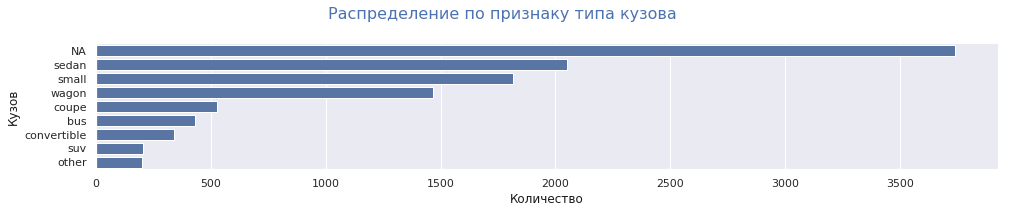

In [21]:
show_cat(
    data=data.query("price == 0"), y="vehicle_type", suptitle="Распределение по признаку типа кузова", 
    order=data.query("price == 0")["vehicle_type"].value_counts().index.to_list(),
    xlabel="Количество", ylabel="Кузов", figsize=(14, 3)
)

Распределение по типу кузовов для нулевого целевого признака существенно сдвинулось в пользу пропущенного значения `NA`, также увеличилось соотношение авто в кузове `coupe`, по остальным значениям порядок не поменялся.

Оценим средние значения целевого признака по каждому из типов кузова.

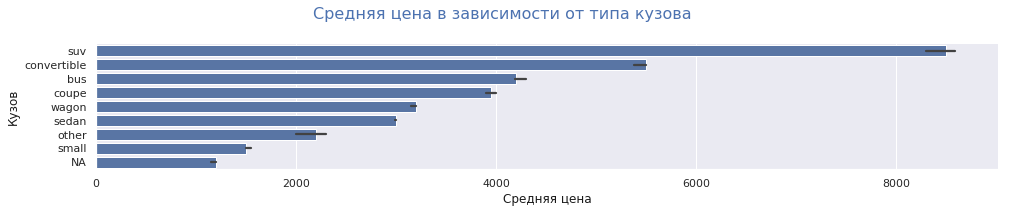

In [22]:
vehicle_type_order = data.groupby("vehicle_type")["price"].median().sort_values(ascending=False).index.to_list()
show_cat(
    x="price", y="vehicle_type", kind="bar", percent=False, order=vehicle_type_order,
    suptitle="Средняя цена в зависимости от типа кузова",
    xlabel="Средняя цена", ylabel="Кузов", figsize=(14, 3)
)

Наиболее высокая средняя цена для автомобилей с кузовом SUV, с большим отрывом вниз идут средние цены для кузовов convertible, bus и coupe. Наименьшая средняя цена приходится на автомобили без указания типа кузова, чуть выше средняя цена у автомобилей с кузовом small и other.

##### Вид топлива

Также заполним пропуски типа топлива значением `NA`

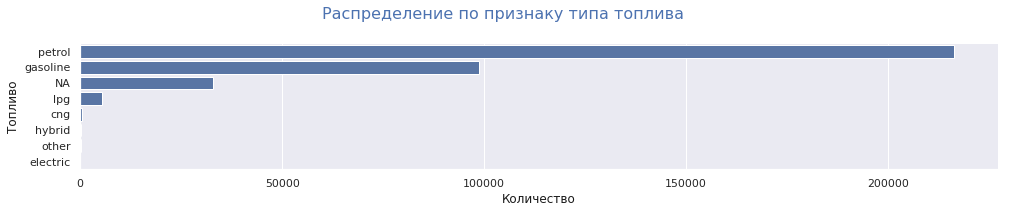

In [23]:
data["fuel_type"].fillna("NA", inplace=True)
show_cat(
    y="fuel_type", suptitle="Распределение по признаку типа топлива", 
    order=data["fuel_type"].value_counts().index.to_list(),
    xlabel="Количество", ylabel="Топливо", figsize=(14, 3)
)

Наибольшее количество автомобилей с типом топлива petrol, вероятнее всего это бензиновые автомобили, а gasoline - дизельные, хотя слова petrol и gasoline по сути обозначают одно и то же - бензин. Оценим это предположение при анализе средних цен автомобилей таких категорий. Автомобилей с типом топлива gasoline более чем в два раза меньше - почти 28% против 61%. Для довольно большого количества автомобилей не указан тип топлива - 9.28%. Автомобили с другими видами топлива имеют очень низкое количество в выборке. Также имеются значения lgp и cng - это два вида газа, LGP (Liquid Petroleum Gas) основан на пропане, а CNG (Compressed Natural Gas) основан на метане.

Оценим распределение для нулевого значения целевого признака.

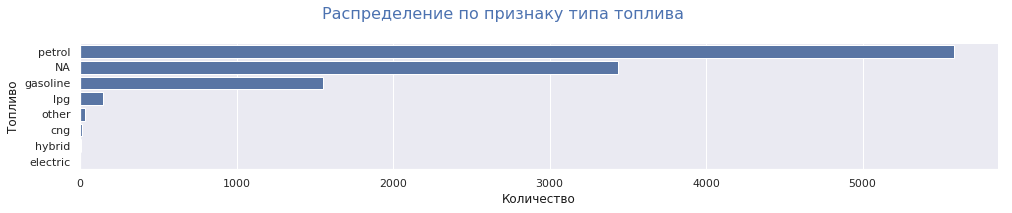

In [24]:
show_cat(
    data=data.query("price == 0"), y="fuel_type", 
    order=data.query("price == 0")["fuel_type"].value_counts().index.to_list(),
    suptitle="Распределение по признаку типа топлива", 
    xlabel="Количество", ylabel="Топливо", figsize=(14, 3)
)

Для нулевого значения целевого признака также наибольшее количество приходится на бензиновые авто, однако на вторую строчку выдвинулись анкеты с пропущенным значением типа топлива.

Оценим к каким маркам относятся пропущенные значения типа топлива.

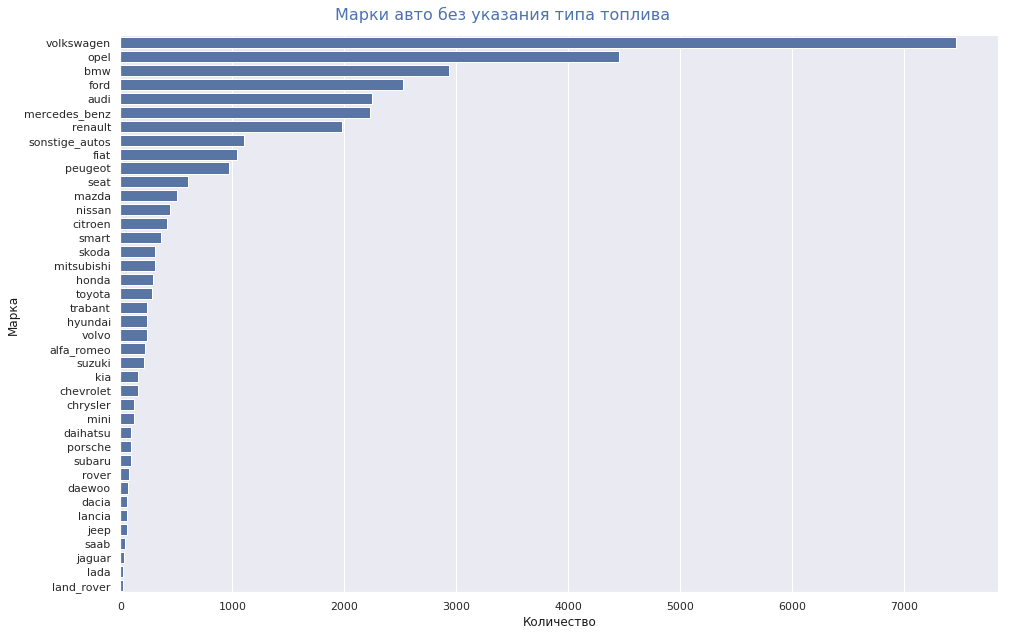

In [25]:
show_cat(
    data = data.query("fuel_type == 'NA'"),
    y="brand", suptitle="Марки авто без указания типа топлива", 
    order=data.query("fuel_type == 'NA'")["brand"].value_counts().index.to_list(),
    xlabel="Количество", ylabel="Марка", figsize=(14, 9)
)

Пропуски по виду топлива достаточно равномерно распределены между различными марками с учетом их распространенности, аномалий не наблюдается.

Также оценим средние цены на автомобили в зависимости от типа топлива.

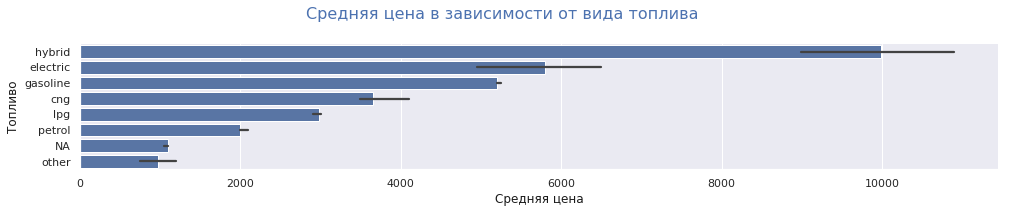

In [26]:
fuel_type_order = data.groupby("fuel_type")["price"].median().sort_values(ascending=False).index.to_list()
show_cat(
    x="price", y="fuel_type", kind="bar", percent=False, order=fuel_type_order,
    suptitle="Средняя цена в зависимости от вида топлива",
    xlabel="Средняя цена", ylabel="Топливо", figsize=(14, 3)
)

Наибольшая средняя цена у гибридов и автомобилей на электрической тяге. Разница средних цен между автомобилями с типом топлива gasoline и petrol достаточно большая - более чем в 2.5 раза в пользу gasoline. Это явно разные типы топлива, так что предположение о том, что это бензин и дизель оставляем как наиболее предпочтительные. Автомобили с типом топлива CNG и LPG располагаются между ними. Наименьшая средняя цена приходится на автомобили с типом топлива other, а также на автомобили без указания типа топлива.

##### Тип коробки передач

По данному признаку также имеются пропуски, заполним их по аналогии с предыдущими признаками.

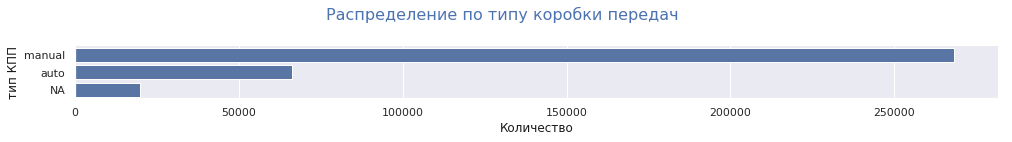

In [27]:
data["gearbox"].fillna("NA", inplace=True)
show_cat(
    y="gearbox", suptitle="Распределение по типу коробки передач", 
    order=data["gearbox"].value_counts().index.to_list(),
    xlabel="Количество", ylabel="тип КПП"
)

Основная масса автомобилей в выборке имеет ручную КПП, менее четверти приходится на автоматическую КПП или без указания типа КПП. Также оценим распределение для нулевого целевого признака.

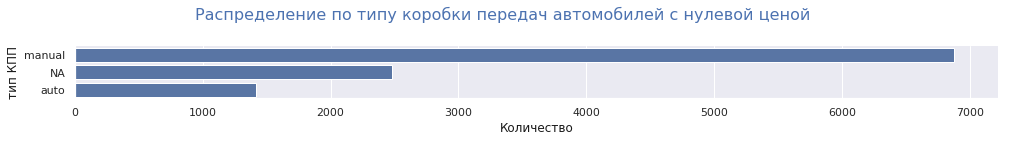

In [28]:
show_cat(
    data=data.query("price == 0"), y="gearbox", 
    order=data.query("price == 0")["gearbox"].value_counts().index.to_list(),
    suptitle="Распределение по типу коробки передач автомобилей с нулевой ценой", 
    xlabel="Количество", ylabel="тип КПП"
)

По типу коробки передач соотношение сместилось в сторону увеличения автомобилей с пропущенным значением типа коробки передач, которое увеличилось с 5.6% до 23% за счет снижения других значений.

Оценим на какие марки приходятся пропуски.

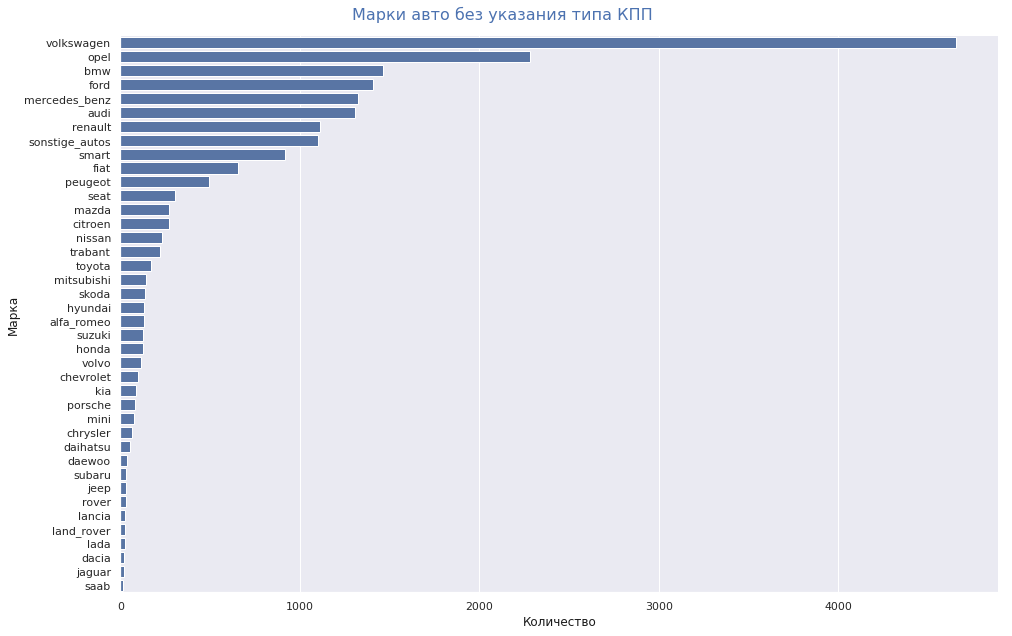

In [29]:
show_cat(
    data = data.query("gearbox == 'NA'"),
    y="brand", suptitle="Марки авто без указания типа КПП", 
    order=data.query("gearbox == 'NA'")["brand"].value_counts().index.to_list(),
    xlabel="Количество", ylabel="Марка", figsize=(14, 9)
)

Пропуски по типу коробки переключения передач также распространены на широкий список марок, распределение которых также близко к распределению марок в выборке, какие-то явные аномалии не наблюдаются.

Оценим средние цены в разрезе типов КПП.

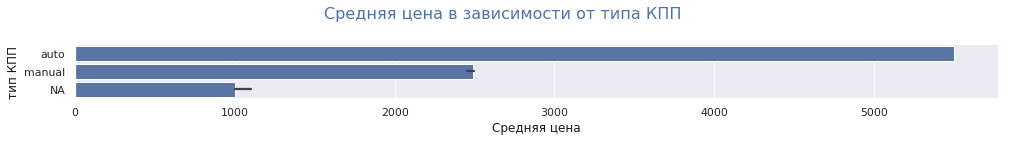

In [30]:
gearbox_order = data.groupby("gearbox")["price"].median().sort_values(ascending=False).index.to_list()
show_cat(
    x="price", y="gearbox", kind="bar", percent=False, order=gearbox_order,
    suptitle="Средняя цена в зависимости от типа КПП",
    xlabel="Средняя цена", ylabel="тип КПП"
)

По средним ценам можно отметить, что автомобили с автоматической коробкой переключения передач существенно дороже, чем с ручной КПП, также стоит отметить, что автомобили без указания типа КПП в среднем наиболее дешевые.

##### Модель автомобиля

Аналогично заполним пропущенные значения и проведем анализ. Так как моделей автомобилей большое количество, в первую очередь оценим пропущенные значения в разрезе марок авто.

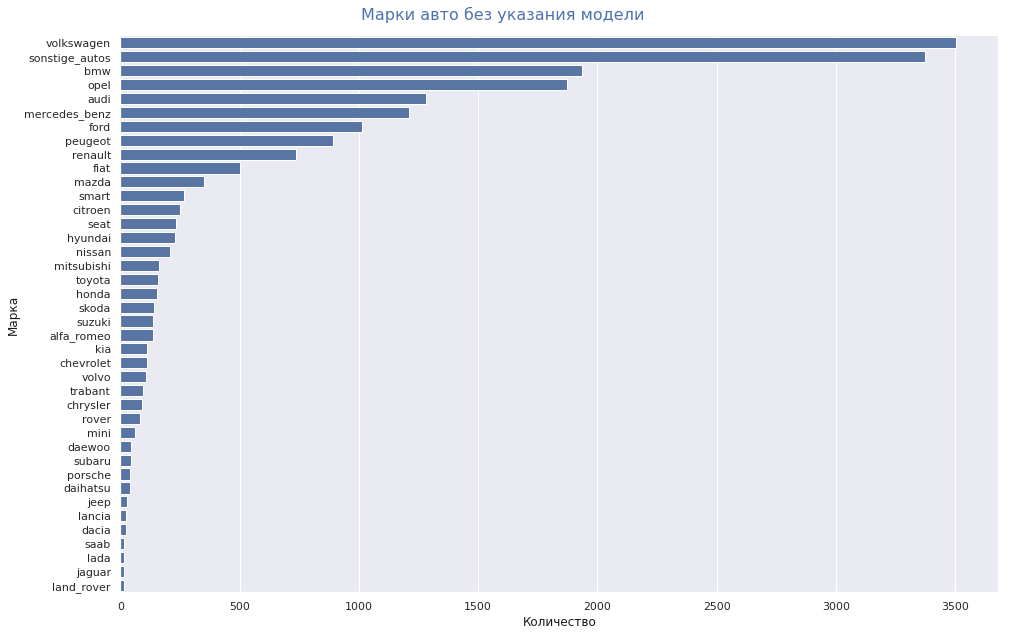

In [31]:
data["model"].fillna("NA", inplace=True)
show_cat(
    data = data.query("model == 'NA'"),
    y="brand", suptitle="Марки авто без указания модели", 
    order=data.query("model == 'NA'")["brand"].value_counts().index.to_list(),
    xlabel="Количество", ylabel="Марка", figsize=(14, 9)
)

Модели пропущены также по широкому списку марок авто, однако в данном разрезе сильно вырываются вперед прочие автомобили `sonstige_autos`. Оценим какие модели приходятся на эту категорию.

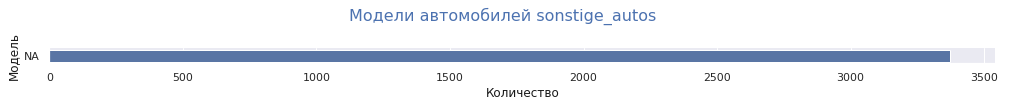

In [32]:
show_cat(
    data=data.query("brand == 'sonstige_autos'"), y="model",
    suptitle="Модели автомобилей sonstige_autos", percent=False,
    xlabel="Количество", ylabel="Модель", figsize=(14, 1.5)
)

Очевидно, что все пропуски в наименовании моделей авто для категории других автомобилей `sonstige_autos` не случайны, для данной категории нет конкретных моделей. Хотя можно было для всех марок установить модель `other` и использовать как значение по умолчанию, тогда можно было бы избавиться от пропусков.

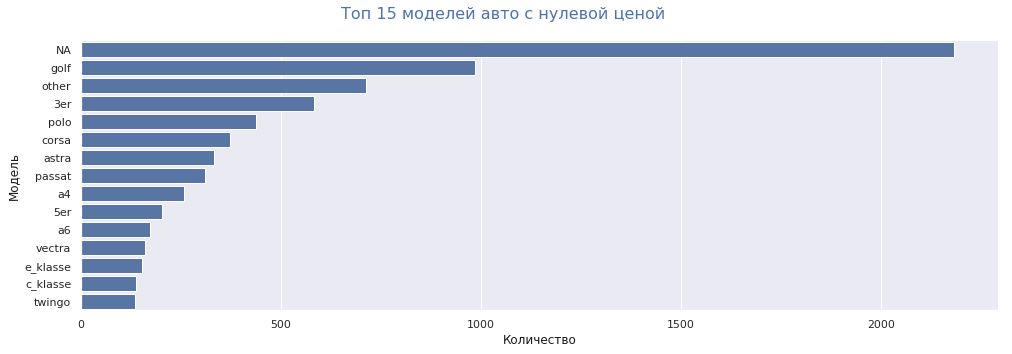

Общее количество моделей с нулевой ценой: 223


In [33]:
show_cat(
    data=data.query("price == 0"), y="model",
    order=data.query("price == 0")["model"].value_counts().index.to_list()[:15],
    suptitle="Топ 15 моделей авто с нулевой ценой", 
    xlabel="Количество", ylabel="Модель", figsize=(14, 5)
)
print("Общее количество моделей с нулевой ценой:", data.query("price == 0")["model"].unique().shape[0])

В виду большого количества моделей с нулевой ценой, рассмотрим только ТОП 15 моделей. Из приведенного графика можно отметить, что наибольшее число автомобилей с нулевой ценой приходится на модели, марка которых не указана, также довольно большое количество приходится на марку other, из указанных моделей наибольшее количество приходится на golf.

Проверим наличие одинаковых моделей для разных марок автомобилей.

In [34]:
display(
    data.groupby('model')['brand'].unique().loc[lambda x: x.map(lambda x: len(x) > 1)]
    .apply(lambda x: x if len(x) < 5 else f"{len(x)} марок авто")
    .rename("Марка").to_frame().rename_axis("Модель"))
print("Всего марок авто:", data["brand"].unique().shape[0])
print("Марка без модели 'other':", 
      *[x for x in data["brand"].unique() if x not in data.query("model == 'other'")["brand"].unique()])

Марка
Модель                              
1_reihe             [mazda, peugeot]
3_reihe             [mazda, peugeot]
5_reihe             [mazda, peugeot]
NA                     40 марок авто
defender         [land_rover, rover]
discovery        [land_rover, rover]
freelander       [land_rover, rover]
grand       [jeep, suzuki, chrysler]
matiz            [chevrolet, daewoo]
other                  39 марок авто

Всего марок авто: 40
Марка без модели 'other': sonstige_autos


Для моделей other и NA большое количество марок не вызывает вопросов, при этом значение `NA` встречается для всех марок, а модель `other` не представлена только для марки `sonstige_autos`, которая имеет только пропуски `NA`. Другие совпадения лучше рассмотреть подробнее. 

Если модели matiz и линейки 1, 3 и 5 выпускались под данными марками, то для модели grand были более сложные наименования, такие как Crysler Grand Voyager, Suzuki Grand Vitara и Jeep Grand Cherokee, которые имели двойное название, скорее всего данные названия были просто сокращены до grand. Наибольшие вопросы вызывают модели Defender, Discovery и Freelander, которые бывают только марки Land Rover, а марка Rover имеет в основном легковые модели.

Проверим какие модели имеются в выборке для марки rover и какое в них соотношение некорректно внесенных моделей.

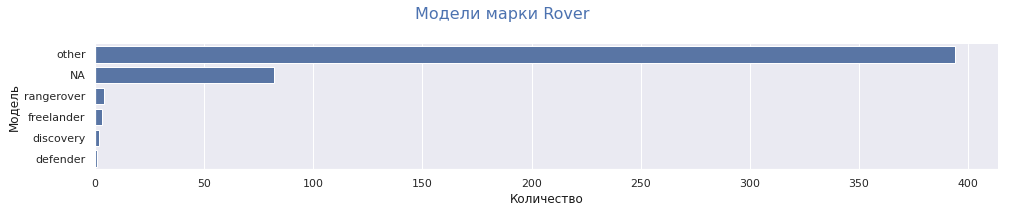

In [35]:
show_cat(
    data=data.query("brand == 'rover'"), y="model", figsize=(14, 3),
    order=data.query("brand == 'rover'")["model"].value_counts().index.to_list(),
    suptitle="Модели марки Rover", ylabel="Модель", xlabel="Количество"
)

Очевидно, что для данной марки основные модели это other и незаполненные значения. Модели Discovery, Range Rover, Freelander и Defender относятся к другой марке - Land Rover. Оценим модели и этой марки.

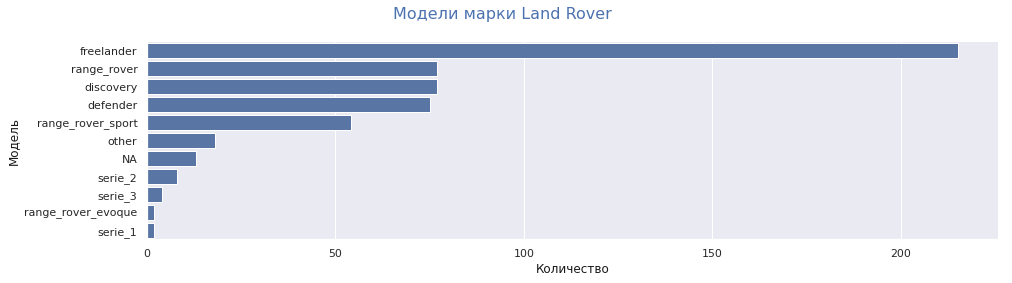

In [36]:
show_cat(
    data=data.query("brand == 'land_rover'"), y="model", figsize=(14, 4),
    order=data.query("brand == 'land_rover'")["model"].value_counts().index.to_list(),
    suptitle="Модели марки Land Rover", ylabel="Модель", xlabel="Количество"
)

По марке Land Rover положение значительно лучше, больше всего анкет приходится на модель Freelander, но и модели Discovery, Range Rover, Defender и Range Rover Sport имеют достаточное соотношение по количеству. Старых моделей Series 1/2/3 довольно мало, как и более новой модели Evoque.

Возможно подобные проблемы имеются также и по другим моделям и маркам, здесь стоит снова отметить рекомендацию по обновлению и актуализации используемых справочников марок и моделей автомобилей, по которым стоит проводить ограничения ввода пользователями информации.

Оценим ТОП-5 самых дорогих и самых дешевых моделей по средней цене.

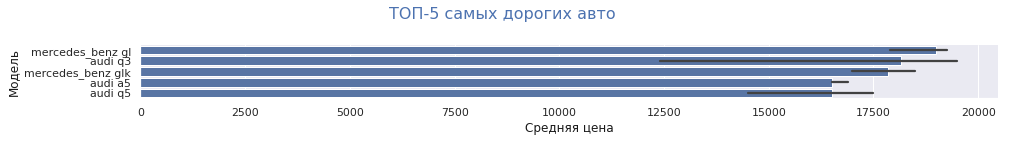

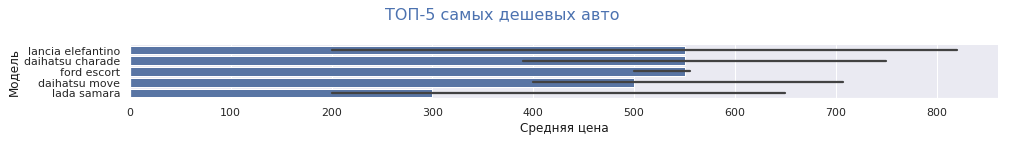

In [37]:
model_order = data.groupby("model")["price"].median().sort_values(ascending=False).index.to_list()
data["brand_model"] = data["brand"] + " " + data["model"]
# ТОП-5 дорогих авто
top5 = model_order[:5]
show_cat(
    data=data.query("model.isin(@top5)"),
    x="price", y="brand_model", kind="bar", percent=False, 
    order=["mercedes_benz gl", "audi q3", "mercedes_benz glk", "audi a5", "audi q5"],
    suptitle="ТОП-5 самых дорогих авто", xlabel="Средняя цена", ylabel="Модель"
)
# ТОП-5 дешевых авто
top5 = model_order[-5:]
show_cat(
    data=data.query("model.isin(@top5)"),
    x="price", y="brand_model", kind="bar", percent=False, 
    order=["lancia elefantino", "daihatsu charade", "ford escort", "daihatsu move", "lada samara"],
    suptitle="ТОП-5 самых дешевых авто", xlabel="Средняя цена", ylabel="Модель"
)
# Удаление временных переменных и столбцов датасета
data.drop(columns="brand_model", inplace=True)
del top5

В список наиболее дорогих по средней цене автомобилей входят марки Mercedes с моделями GL и GLK, а также Audi с моделями Q3, A5 и Q5. Список наиболее дешевых по средне цене автомобилей замыкает Lada Samara, А также входят Daihatsu с моделями Move и Charade, Ford Escort и Lancia Elefantino. Аномалий не наблюдается.

##### Регион

В датасете имеется почтовый код пользователя анкеты, несмотря на то, что поле является числовым, по сути это регион из которого подается объявление, оценим это поле.

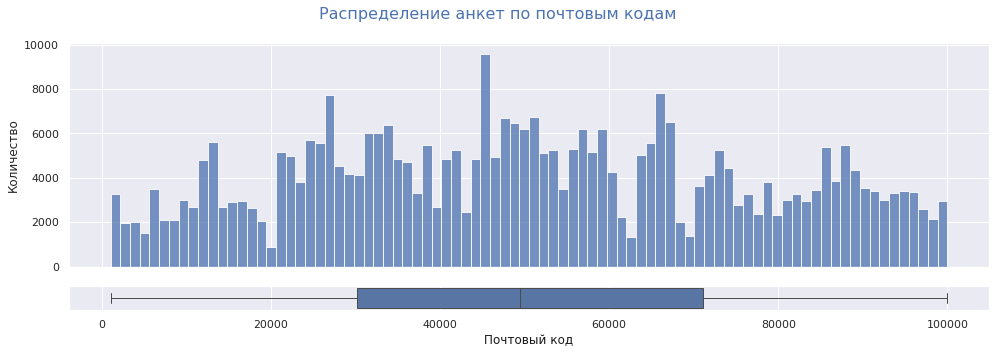

Количество уникальных значений почтового кода: 8143


In [38]:
show_num(
    x="postal_code", kde=False,
    suptitle="Распределение анкет по почтовым кодам",
    xlabel="Почтовый код", ylabel="Количество"
)
print("Количество уникальных значений почтового кода:", data["postal_code"].unique().shape[0])

Минимальное значение 1067, максимальное 99998. Если обратиться к системе почтовой индексации современной Германии, можно понять, что данные почтовые коды укладываются в характеристики этой систематизации, в частности почтовые индексы состоят из пяти цифр, первая левая обозначает зону и начинается с цифры `0`. Таким образом, все значения в датасете менее 10000 фактически начинаются с 0, например, минимальное значение фактически является 01067. Вторая цифра обозначает регион внутри зоны и совместно с зоной образует двузначный код региона. Также стоит отметить, что зоны почтовой индексации отличаются от административного деления Германии на земли. Таким образом имеем 10 зон, при этом, не все зоны имеют по 10 регионов.

В целях уменьшения количества категорий сократим почтовые коды до региона путем добавления в датасет нового признака `region`.

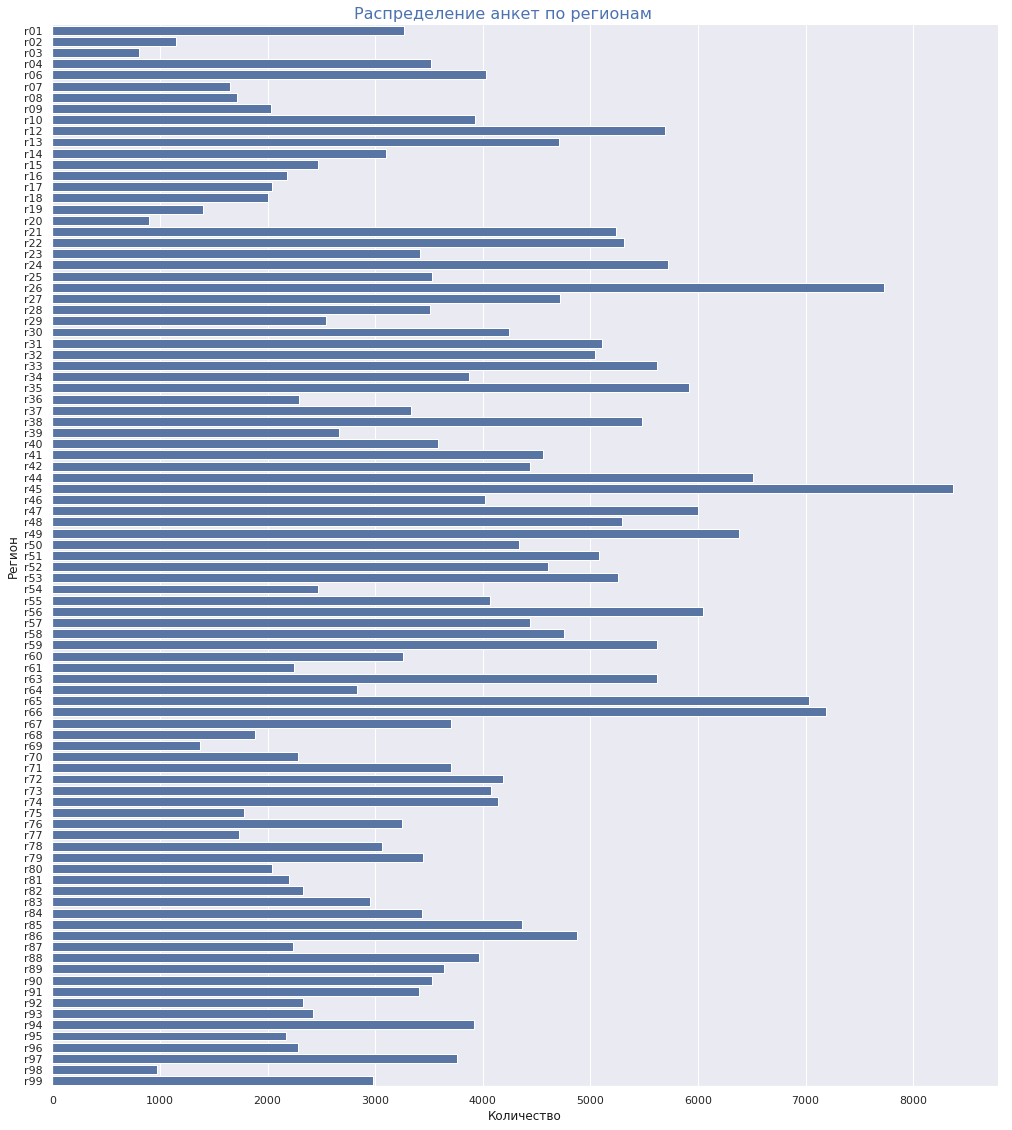

In [39]:
data["region"] = data["postal_code"].sort_values().apply(lambda x: 'r{:0>2}'.format(x // 1000))
data["region"].unique().shape[0]
show_cat(
    data=data.sort_values("region"), y="region", figsize=(14, 16),
    suptitle="Распределение анкет по регионам",
    xlabel="Количество", ylabel="Регион"
)

Также оценим распределение анкет с нулевой ценой по почтовым кодам

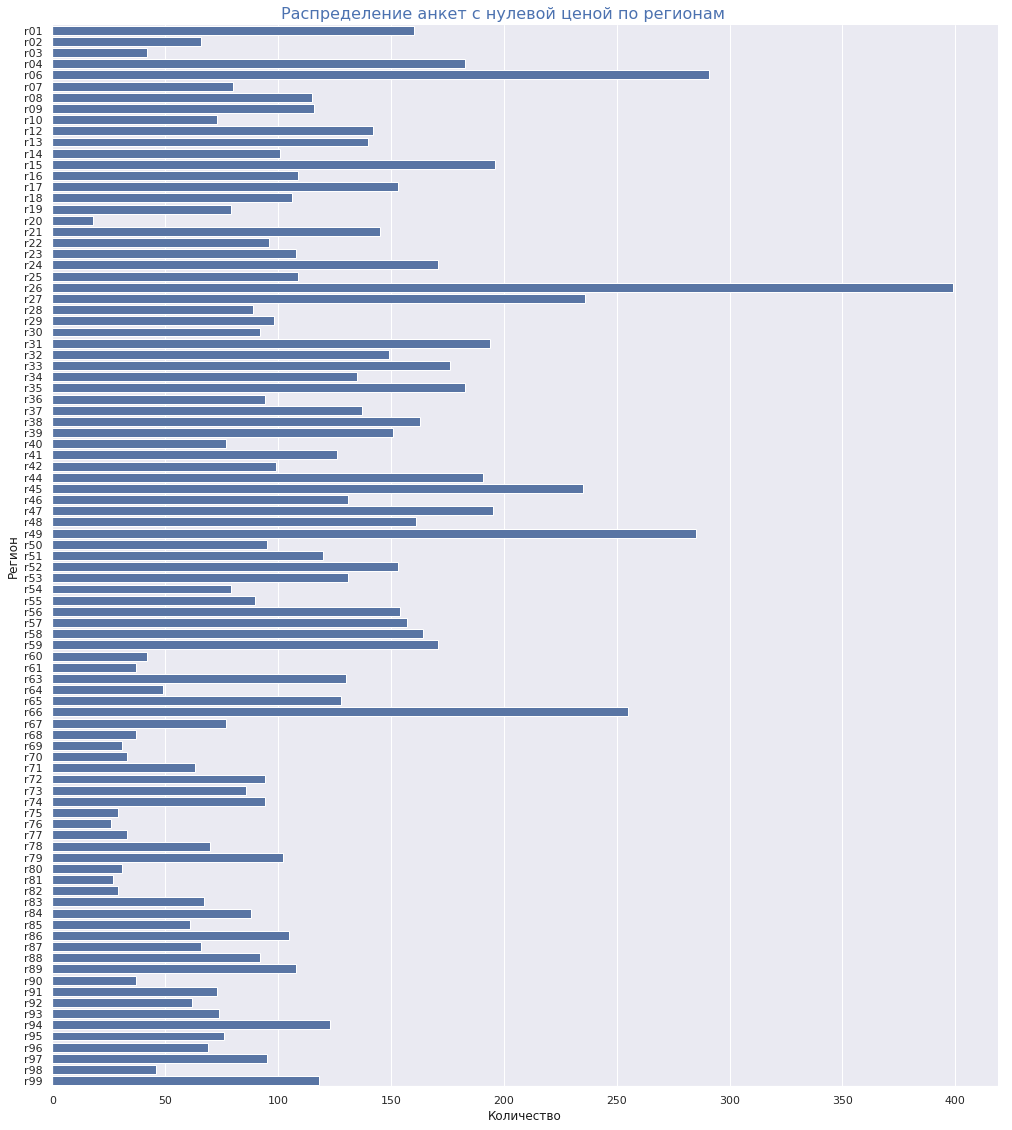

In [40]:
show_cat(
    data=data.query("price == 0").sort_values("region"), y="region", 
    suptitle="Распределение анкет с нулевой ценой по регионам",
    xlabel="Количество", ylabel="Регион", figsize=(14, 16)
)

По нулевому целевому признаку в разрезе регионов явных аномалий не наблюдается.

Рассмотрим также средние значения целевого признака по регионам.

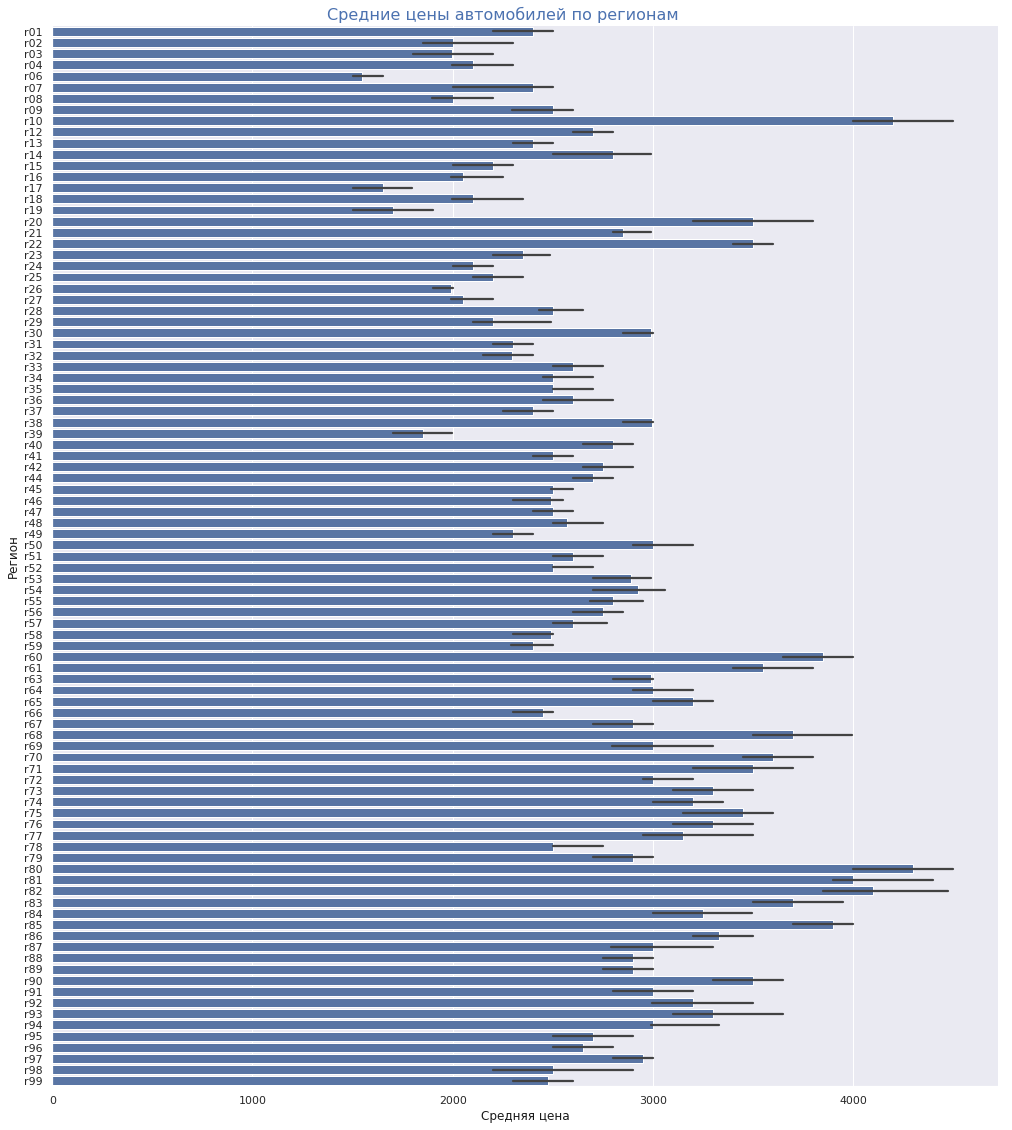

In [41]:
show_cat(
    data=data.sort_values("region"), x="price", y="region", kind="bar",
    suptitle="Средние цены автомобилей по регионам",
    xlabel="Средняя цена", ylabel="Регион", figsize=(14, 16)
)

Довольно высокие средние цены приходятся на регион 10, судя по всему это Берлин, а также на регионы 60-99, особенно регионы 80-83 и 85. Это регионы южной части Германии, в частности земли Баварии. Для оценки соответствия фактическим данным необходимо привлечение специалистов, знакомых с автомобильным рынком Германии.

#### Даты

##### Дата выгрузки анкеты

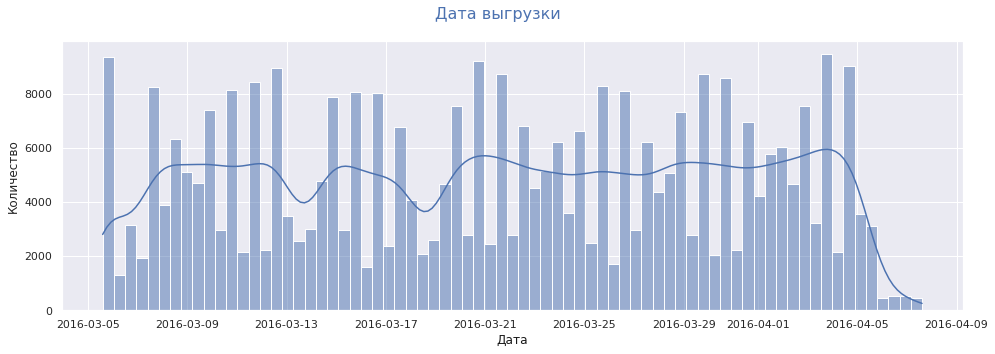

In [42]:
# Для даты не получается построить boxplot
# прошу подсказать, как это можно сделать.
show_num(x="date_crawled", boxplot=False, suptitle="Дата выгрузки", xlabel="Дата", ylabel="Количество")

Выгрузка производилась в период с 5 марта по 7 апреля 2016 года. Распределение количества выгрузок анкет автомобилей довольно равномерное. Не совсем понятно, как осуществлялась выгрузка - попадали или нет одни и те же анкеты в выборку. Для удобства сократим до даты, точность до времени выгрузки вероятно будет избыточной. Оценим распределение с нулевым целевым признаком.

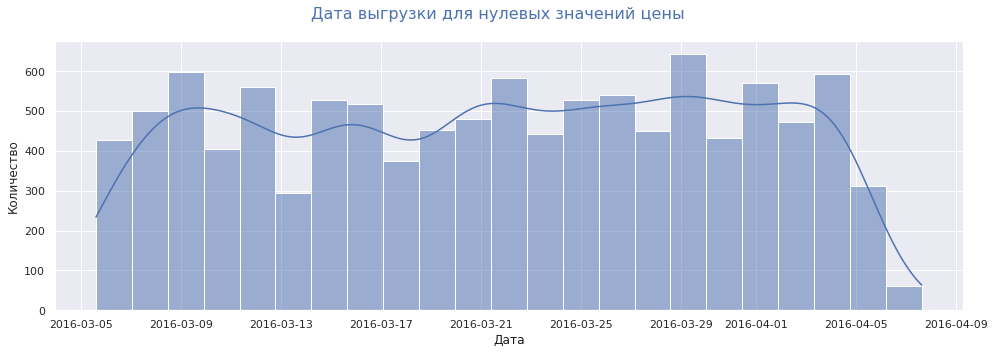

In [43]:
show_num(
    data=data.query("price == 0"), x="date_crawled", boxplot=False, 
    suptitle="Дата выгрузки для нулевых значений цены", xlabel="Дата", ylabel="Количество"
)

Для нулевых значений целевого признака аномалий не наблюдается, распределение близкое к таковому для всего датасета.

In [44]:
print("Количество произведенных выгрузок:",
      data["date_crawled"].unique().shape[0])
data["date_crawled"] = pd.to_datetime(data["date_crawled"].dt.date)

Количество произведенных выгрузок: 271174


Оценим динамику изменения средней цены автомобилей в зависимости от даты выгрузки.

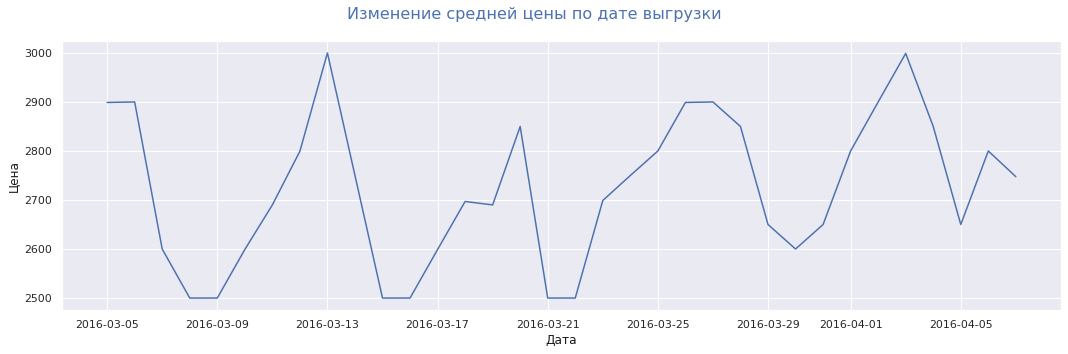

In [45]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data.groupby("date_crawled")["price"].median())
add_plot_titles(suptitle="Изменение средней цены по дате выгрузки", 
                xlabel="Дата", ylabel="Цена", show=True)

Динамика разнонаправленная, хотя наблюдается небольшой тренд на повышение.

##### Дата создания анкеты

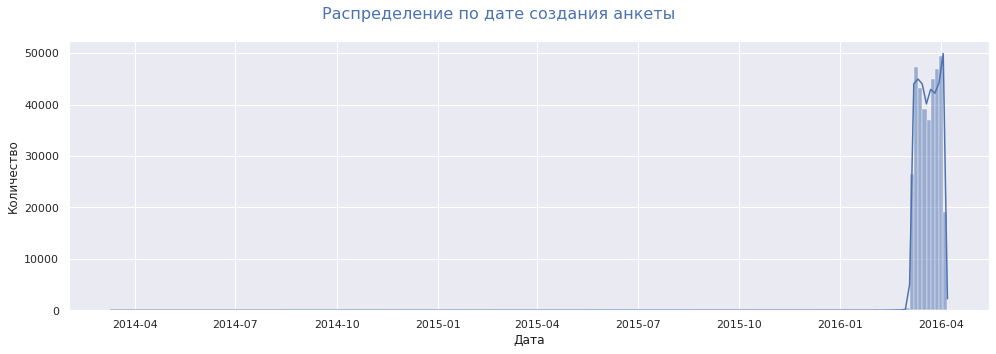

In [46]:
show_num(
    x="date_created", boxplot=False, suptitle="Распределение по дате создания анкеты", 
    xlabel="Дата", ylabel="Количество", bins=200
)

Дата создания основной массы анкет располагается в пределах даты их выгрузки, однако имеется небольшое количество анкет с более ранней датой создания - с 2014 года. Также сравним с распределением для нулевых значений цены автомобилей.

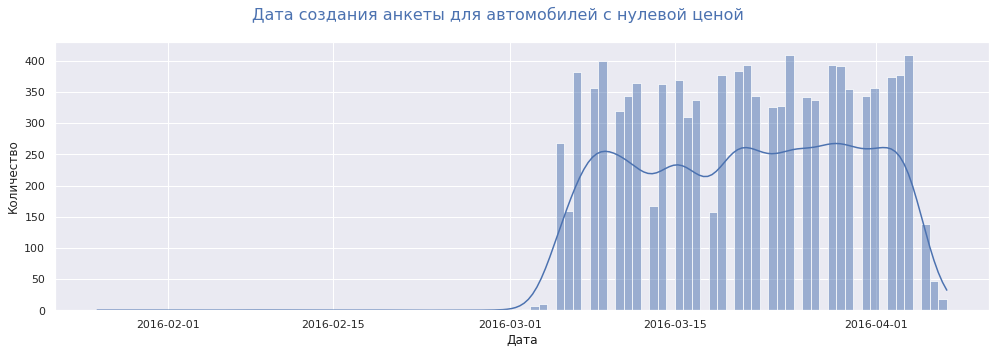

In [47]:
show_num(
    data=data.query("price == 0"), x="date_created", boxplot=False, 
    suptitle="Дата создания анкеты для автомобилей с нулевой ценой", 
    xlabel="Дата", ylabel="Количество", bins=100
)

По графику заметно, что даты создания анкет с нулевой ценой начинаются с 26 января 2016 года и приходятся на весь период выгрузки, где присутствует их основная масса.

Взглянем на наиболее ранние анкеты в датасете.

In [48]:
data.sort_values("date_created").head(15)

date_crawled  price vehicle_type  reg_year gearbox  power     model  \
61207    2016-03-16   8999           NA      2005      NA      0       147   
4001     2016-03-23   6000          bus      1995    auto    200     other   
342275   2016-03-05  10400          bus      1993      NA      0    ducato   
86601    2016-04-02  14250  convertible      2005  manual    163       slk   
175103   2016-03-08   5200  convertible      2006  manual    109   2_reihe   
221002   2016-03-15    600        small      2005  manual     54      polo   
75598    2016-03-14    600        small      2005  manual     54      polo   
340616   2016-03-05   9500        small      2013  manual     90     corsa   
9972     2016-03-05   3490        sedan      2006  manual     88      clio   
161567   2016-03-05  15500        wagon      2009  manual    160        a4   
282938   2016-03-23   5499        sedan      2009  manual     95   2_reihe   
75684    2016-03-14   5400        small      2009  manual     44   ypsilon   
60168    2016-03-05   5999        sedan      1997    auto    197  c_klasse   
153650   2016-03-19  11999           NA      2008  manual    150        NA   
301180   2016-03-05   5900  convertible      1995  manual     90  mx_reihe   

        kilometer  reg_month fuel_type          brand repaired date_created  \
61207      125000          0    petrol     alfa_romeo       NA   2014-03-10   
4001       150000          0    petrol      chevrolet       no   2015-03-20   
342275      30000          1  gasoline           fiat       NA   2015-06-18   
86601      150000          6    petrol  mercedes_benz       no   2015-08-07   
175103      80000         11    petrol        peugeot       no   2015-08-10   
221002     150000          1    petrol     volkswagen      yes   2015-09-04   
75598      150000          1    petrol     volkswagen      yes   2015-09-04   
340616      50000          4  gasoline           opel       no   2015-09-09   
9972       150000          3    petrol        renault       no   2015-11-02   
161567     100000         11    petrol           audi       no   2015-11-08   
282938      70000          3    petrol        peugeot       no   2015-11-10   
75684       40000          9    petrol         lancia       no   2015-11-12   
60168      150000          9    petrol  mercedes_benz       no   2015-11-17   
153650      90000          1  gasoline           opel       no   2015-11-23   
301180     125000          5    petrol          mazda       NA   2015-11-23   

        num_of_pict  postal_code           last_seen region  
61207             0        79669 2016-04-07 04:46:24    r79  
4001              0        24558 2016-04-07 03:45:01    r24  
342275            0        76275 2016-04-05 17:46:09    r76  
86601             0        76228 2016-04-07 09:15:23    r76  
175103            0        26382 2016-04-05 20:46:54    r26  
221002            0        72669 2016-03-15 15:49:29    r72  
75598             0        72669 2016-03-15 14:16:58    r72  
340616            0        98739 2016-04-05 17:46:04    r98  
9972              0        40880 2016-03-17 15:46:57    r40  
161567            0        56410 2016-04-06 23:15:36    r56  
282938            0        22941 2016-04-07 09:15:21    r22  
75684             0        53119 2016-04-06 03:16:57    r53  
60168             0        28816 2016-04-06 05:46:03    r28  
153650            0         7749 2016-03-27 17:44:16    r07  
301180            0        63741 2016-03-23 07:18:38    r63

Можно отметить, что анкеты с самыми ранними датами создания приходятся не на первый день выгрузки, таким образом нельзя говорить, что это анкеты, которые были выгружены при первой выгрузке.

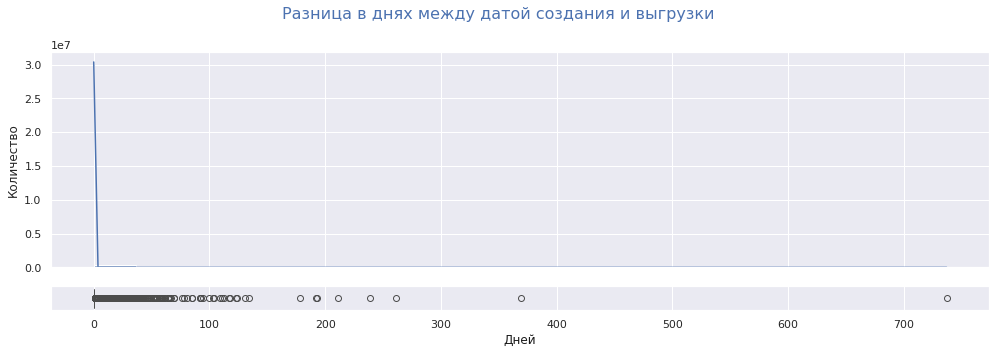

In [49]:
show_num(
    data=(data["date_crawled"] - data["date_created"]).dt.days.rename("days").to_frame(), 
    x="days", suptitle="Разница в днях между датой создания и выгрузки",
    xlabel="Дней", ylabel="Количество"
)

Очевидно, что для основной массы анкет дата создания совпадает с датой выгрузки. Менее 1% анкет приходятся на анкеты, дата выгрузки которых позже даты создания более чем на 1 день. При этом дата создания некоторых анкет превышает дату выгрузки на год и более. Стоит обратить внимание на данный факт, возможно наличие ошибок при выгрузке. Также можно предположить, что выгрузке подвергались анкеты с активными пользователями, либо в случае внесения в них изменений, соответственно в выборку попали не только вновь созданные, но и активные или измененные за этот период анкеты, которые были созданы ранее.

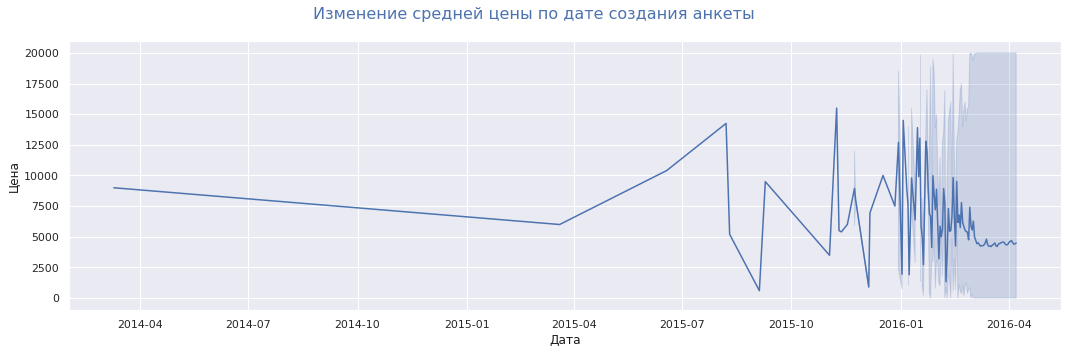

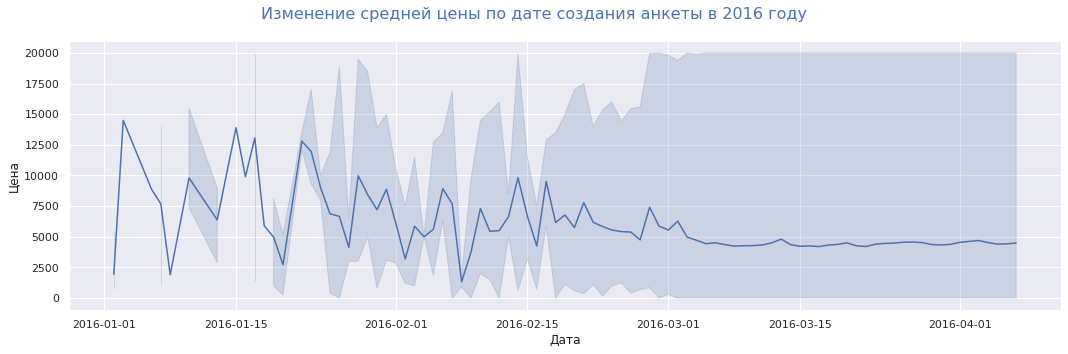

In [50]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data, x="date_created", y="price", estimator=np.mean, errorbar=("pi", 100))
add_plot_titles(suptitle="Изменение средней цены по дате создания анкеты", 
                xlabel="Дата", ylabel="Цена", show=True)
plt.figure(figsize=(15, 5))
sns.lineplot(
    data=data.query("date_created > @pd.to_datetime('2016-01-01')"), 
    x="date_created", y="price", estimator=np.mean, errorbar=("pi", 100)
)
add_plot_titles(suptitle="Изменение средней цены по дате создания анкеты в 2016 году", 
                xlabel="Дата", ylabel="Цена", show=True)

Заметно малое количество анкет, созданных до марта 2016 года, которые показывают сильный разброс на графике, начиная с марта 2016 года динамика выравнивается.

##### Дата последней активности пользователя

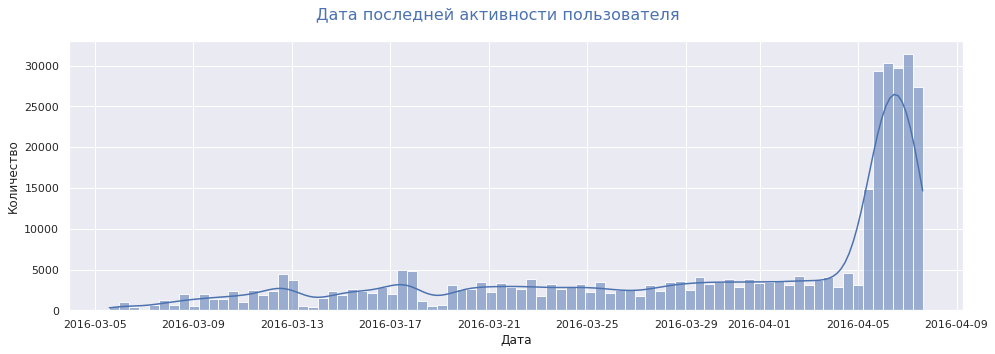

In [51]:
show_num(x="last_seen", boxplot=False, suptitle="Дата последней активности пользователя", 
         xlabel="Дата", ylabel="Количество")

Дата последней активности пользователя попадает в промежуток в который производилась выгрузка. Вероятнее всего выгрузка анкет производилась для активных пользователей в период с 5 марта по 7 апреля 2016 года. Исключим время для удобства анализа. Также взглянем на распределение анкет с нулевым значением цены.

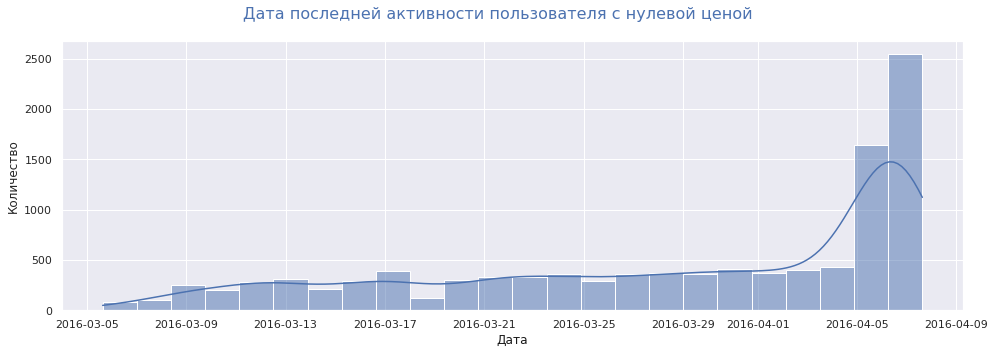

In [52]:
show_num(
    data=data.query("price == 0"), x="last_seen", boxplot=False, 
    suptitle="Дата последней активности пользователя с нулевой ценой", 
    xlabel="Дата", ylabel="Количество"
)

Распределение анкет по пользовательской активности для анкет с нулевой ценой аналогично таковому для всего датасета.

Взаглянем на динамику средней цены автомобилей в разрезе даты последней активности

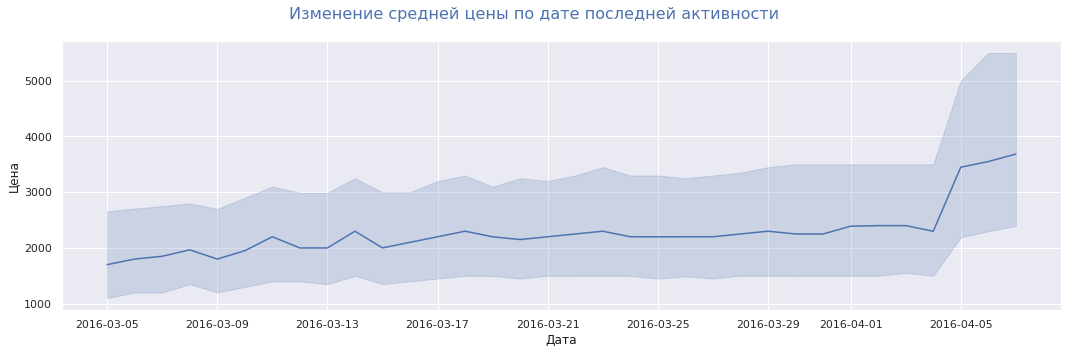

In [53]:
data["last_seen"] = pd.to_datetime(data["last_seen"].dt.date)
plt.figure(figsize=(15, 5))
sns.lineplot(data=data, x="last_seen", y="price", estimator=np.median, errorbar=("pi", 25))
add_plot_titles(suptitle="Изменение средней цены по дате последней активности", 
                xlabel="Дата", ylabel="Цена", show=True)

Заметно, что средняя цена автомобиля в зависимости от даты последней активности заметно выше, особенно для пользователей, активных в последние дни выгрузки.

##### Дополнительные признаки

Очевидно, что даты в том виде как есть для моделей машинного обучения не представляют большой ценности, кроме даты выгрузки, которая возможно является датой последнего изменения анкеты. Также может быть полезным время жизни анкеты - разница между датами создания и последней активности пользователя. Вычислим количество дней между датой создания анкеты и последней активности пользователей.

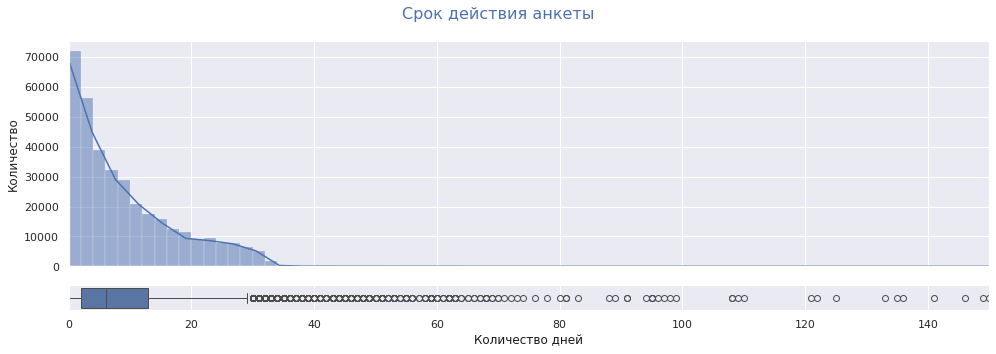

In [54]:
data["activity_days"] = (data["last_seen"] - data["date_created"]).dt.days
show_num(x="activity_days", bins=380, suptitle="Срок действия анкеты", 
        xlabel="Количество дней", ylabel="Количество", xlim=(0, 150))

По сроку жизни анкеты имеются явные выбросы, что может сказаться для менее робастных моделей. Посмотрим как срок анкеты влияет на среднюю цену автомобилей.

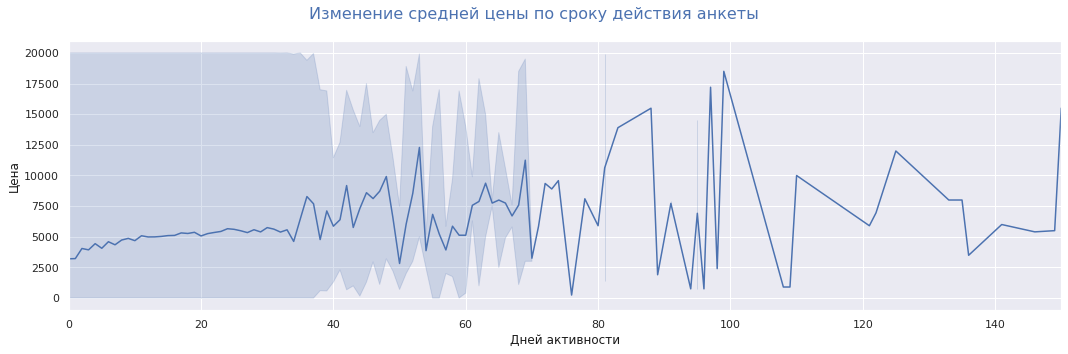

In [55]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data, x="activity_days", y="price", errorbar=("pi", 100))
plt.xlim((0, 150))
add_plot_titles(suptitle="Изменение средней цены по сроку действия анкеты", 
                xlabel="Дней активности", ylabel="Цена", show=True)

Анкеты с большим сроком активности имеют большую среднюю цену, а при значениях срока активности более 30 дней довольно малое количество анкет, вследствие чего график становится сильно ломаным.

Также для некоторых моделей могут быть полезны день месяца и день недели, если имеются периодические зависимости от этих сроков. Месяцев в датасете всего 2, на всякий случай выгрузим и его в отдельный признак. Для этих целей воспользуемся признаком даты выгрузки, предполагая, что это дата последнего изменения анкеты.

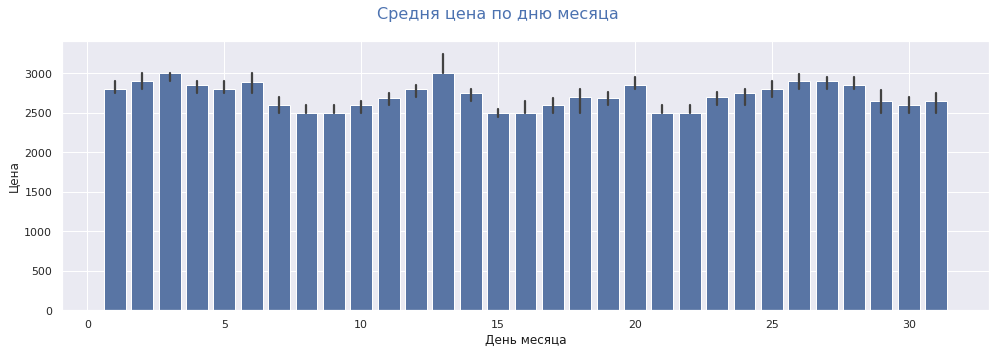

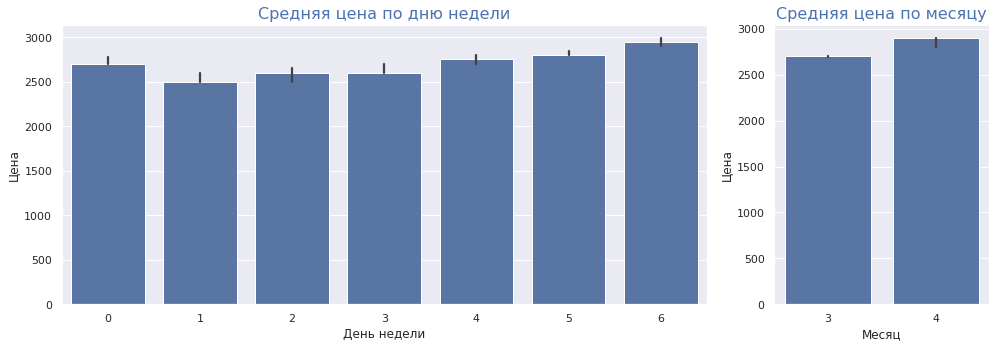

In [56]:
# День месяца
data["month_day"] = data["date_crawled"].dt.day
show_num(x="month_day", y="price", kind="bar", boxplot=False,
         suptitle="Средня цена по дню месяца", 
         xlabel="День месяца", ylabel="Цена", describe=False)

# День недели
data["week_day"] = data["date_crawled"].dt.weekday
# Месяц
data["month"] = data["date_crawled"].dt.month
# Вывод двух графиков
fig, ax = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={"width_ratios": (0.75, 0.25)})
sns.barplot(
    data, x="week_day", y="price", estimator=np.median, ax=ax[0]
).set(xlabel="День недели", ylabel="Цена")
ax[0].set_title("Средняя цена по дню недели", size=16, color="C0")
sns.barplot(
    data, x="month", y="price", estimator=np.median, ax=ax[1]
).set(xlabel="Месяц", ylabel="Цена")
ax[1].set_title("Средняя цена по месяцу", size=16, color="C0")
plt.tight_layout()
plt.show()

От месяца к месяцу заметен рост средней стоимости автомобилей, при этом также заметна некоторая тенденция роста средней стоимости ближе к концу недели. В части изменения средних цен в зависимости от дня месяца сделать корректные выводы довольно сложно, так как в датасете присутствуют данные только за период с 5 марта по 7 апреля, соответственно дни месяца накладываются неравномерно и присутствуют пропуски. Однако заметен семидневный период в рамках которого имеются периодические изменения средней цены. Нужно будет также оценить влияние новых признаков на целевой при проведении корреляционного анализа.

Для удобства дальнейшей работы с датами преобразуем их в количество дней с начала эпоих Unix (01.01.1970)

In [57]:
for col in data.select_dtypes(include=["datetime64[ns]"]).columns:
    data[col] = (data[col] - pd.to_datetime("1970-01-01")).dt.days
show_describe(data=data[["date_crawled", "date_created", "last_seen"]])

#### Количественные признаки

##### Мощность

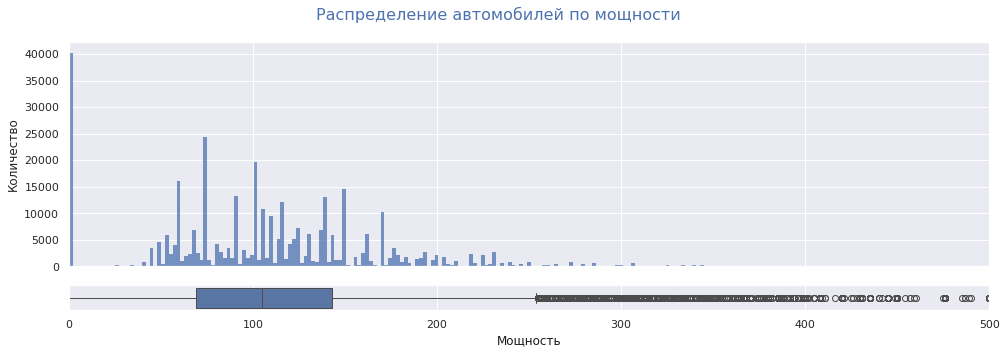

In [58]:
show_num(
    x="power", suptitle="Распределение автомобилей по мощности", kde=False,
    xlabel="Мощность", ylabel="Количество", xlim=(0, 500)
)

Порядка трех четвертей всех автомобилей в выборке имеют мощность между 69 и 143 лошадинных сил. По признаку мощности автомобиля больше всего автомобилей с мощностью `0` - не менее 1% от датасета, заметная масса автомобилей начинается с мощностью ближе к 50 лошадинных сил с максимальным пиком по количеству ближе к 75, также имеются отдельные пики в районе 100 и 150 лошадинных сил и других значения, которые вероятнее всего наиболее распространенные. При значениях более 255 лошадинных сил начинаются отдельные выбросы. График ограничен значениями от 0 до 500, так как имеется немало автомобилей, мощность которых очень сильно завышена - до 20000 лошадинных сил. Взглянем на распределение нулевых значений целевого признака.

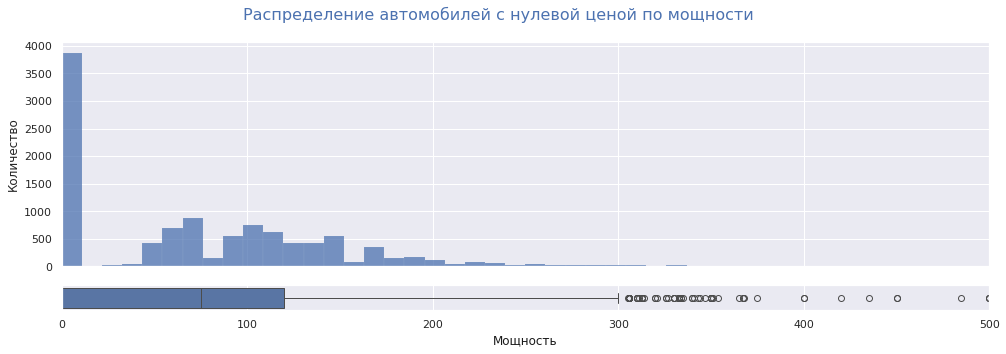

Количество автомобилей с нулевой мощностью: 3865


In [59]:
show_num(
    data=data.query("price == 0"), x="power", kde=False,
    suptitle="Распределение автомобилей с нулевой ценой по мощности", 
    xlabel="Мощность", ylabel="Количество", xlim=(0, 500)
)
print("Количество автомобилей с нулевой мощностью:", data.query("power == 0 and price == 0").shape[0])

Для довольно большой части автомобилей с нулевой ценой мощность также равна 0, из 10772 таких анкет почти 3865 или более 35% имеют нулевое значение мощности. Возможно это автомобили без двигателя, либо вероятнее всего значение `0` является значением по умолчанию, которое не изменялось пользователями.

Взглянем также на самые 'мощные' авто.

In [60]:
data.query("power > 500").sample(15, random_state=RANDOM_STATE)

date_crawled  price vehicle_type  reg_year gearbox  power  \
103795         16894    350        sedan      1997  manual   1703   
23173          16879    400           NA      2015    auto    610   
156364         16882      0          bus      2006  manual   1700   
341066         16894    449           NA      2016  manual   4507   
130940         16884   1450        wagon      2003    auto   1600   
175422         16879  10900        sedan      2007    auto  17011   
311474         16873  10500        coupe      1995  manual    551   
223201         16879   1600        sedan      1998  manual   1500   
174244         16892   1850        other      2003  manual    651   
59887          16890    300        sedan      2004  manual   1002   
348237         16895   3000        coupe      2007  manual   2007   
259952         16871    900        sedan      1995    auto   1017   
63986          16888   3250        sedan      2001    auto  17932   
251283         16868      0        wagon      2001  manual   1598   
187283         16877    300          bus      1992  manual   1230   

              model  kilometer  reg_month fuel_type       brand repaired  \
103795       vectra     150000          7    petrol        opel      yes   
23173         other       5000          1        NA        audi       NA   
156364       touran     150000          9  gasoline  volkswagen       no   
341066        corsa     150000          4    petrol        opel       no   
130940       vectra     150000         12  gasoline        opel       NA   
175422           a3       5000          7  gasoline        audi       NA   
311474        other      90000          3    petrol      nissan      yes   
223201       passat     150000          0    petrol  volkswagen       no   
174244     berlingo     150000         12    petrol     citroen       NA   
59887            NA     150000          4        NA        ford      yes   
348237        corsa     150000          3  gasoline        opel      yes   
259952        astra     150000         12        NA        opel       no   
63986         omega     150000          6    petrol        opel       NA   
251283        astra     150000          8    petrol        opel       no   
187283  transporter     150000          3  gasoline  volkswagen      yes   

        date_created  num_of_pict  postal_code  last_seen region  \
103795         16894            0         6184      16897    r06   
23173          16879            0        70178      16880    r70   
156364         16882            0        57074      16886    r57   
341066         16894            0        29525      16897    r29   
130940         16884            0        71679      16898    r71   
175422         16879            0        12355      16881    r12   
311474         16873            0        32479      16897    r32   
223201         16879            0        38550      16880    r38   
174244         16892            0        50127      16896    r50   
59887          16890            0        61440      16890    r61   
348237         16895            0        72218      16895    r72   
259952         16871            0        47166      16875    r47   
63986          16888            0        86641      16897    r86   
251283         16868            0        16515      16869    r16   
187283         16877            0        45770      16885    r45   

        activity_days  month_day  week_day  month  
103795              3          3         6      4  
23173               1         19         5      3  
156364              4         22         1      3  
341066              3          3         6      4  
130940             14         24         3      3  
175422              2         19         5      3  
311474             24         13         6      3  
223201              1         19         5      3  
174244              4          1         4      4  
59887               0         30         2      3  
348237              0    

Довольно сложно сделать выводы по таким данным, некоторые значения мощности совпадают с годом регистрации, возможно некоторые завышены в 10 или даже в 100 раз, что может быть особенностью сервиса, например, если не принимает разделитель целой и дробной части, а записывает как единое целое число без этого разделителя, а возможно некоторые пользователи записывали случайные числа в это поле. 

Можно отметить одинаковые значения этого признака с признаком года регистрации. Оценим с какими числовыми признаками также могут встречаться дубликаты.

In [61]:
print("Дубликаты значения мощности с другими признаками:")
for i in ["price", "reg_year", "kilometer", "postal_code"]:
    print(
        f"Дубликаты по полю {i}:", 
          data[data["power"] == data[i]].query("power > 0")["power"].count()
    )

Дубликаты значения мощности с другими признаками:
Дубликаты по полю price: 52
Дубликаты по полю reg_year: 17
Дубликаты по полю kilometer: 1
Дубликаты по полю postal_code: 0


Имеется небольшое количестов одинаковых значений признака мощности с признаками цены, года регистрации и даже пробега. Оценим случайную выборку из одинаковых по мощности и цене автомобилей.

In [62]:
display(data.query("(power == price) and (power > 0)").sample(10, random_state=RANDOM_STATE))
show_describe(data.query("(power == price) and (power > 0)")["power"].rename("Мощность"))

date_crawled  price vehicle_type  reg_year gearbox  power   model  \
139528         16885    150        sedan      1995    auto    150      a4   
249588         16880    150           NA      2000      NA    150     5er   
285914         16884     55        small      1996  manual     55  fiesta   
126487         16883    150          bus      1999    auto    150   other   
265538         16872     75           NA      2016  manual     75  lancer   
53240          16879    150  convertible      1999  manual    150     3er   
135674         16876      1        sedan      2002  manual      1      NA   
301245         16874    130           NA      2010      NA    130   astra   
14555          16872    599           NA      2018  manual    599  twingo   
204529         16892     60        small      1998  manual     60      ka   

        kilometer  reg_month fuel_type       brand repaired  date_created  \
139528     150000          6    petrol        audi      yes         16885   
249588       5000          0        NA         bmw       NA         16880   
285914     150000          2    petrol        ford       no         16884   
126487     150000          5        NA        ford       NA         16883   
265538     150000          0    petrol  mitsubishi      yes         16871   
53240      150000          4    petrol         bmw       NA         16878   
135674       5000          7        NA      daewoo       NA         16876   
301245     100000         12        NA        opel       NA         16874   
14555      150000          0        NA     renault       NA         16872   
204529     150000          7    petrol        ford      yes         16892   

        num_of_pict  postal_code  last_seen region  activity_days  month_day  \
139528            0        70599      16888    r70              3         25   
249588            0        50129      16882    r50              2         20   
285914            0         6712      16884    r06              0         24   
126487            0        32805      16889    r32              6         23   
265538            0        23552      16878    r23              7         12   
53240             0        28327      16889    r28             11         19   
135674            0        27283      16898    r27             22         16   
301245            0        48159      16896    r48             22         14   
14555             0        47138      16897    r47             25         12   
204529            0        63069      16893    r63              1          1   

        week_day  month  
139528         4      3  
249588         6      3  
285914         3      3  
126487         2      3  
265538         5      3  
53240          5      3  
135674         2      3  
301245         0      3  
14555          5      3  
204529         4      4

Заметно, что данная выборка имеет в основном автомобили с низкой стоимостью - не менее 75% записей цена не превышает 150. Лучше все такие значения мощности обнулить как вероятнее всего некорректные.

In [63]:
# Исключение вероятно некорректно заполненных значений мощности, когда она совпадает с другими полями
data["pwr_old"] = data["power"].copy()
data.loc[
    (data["power"] == data["reg_year"]) | (data["power"] == data["price"] | (data["power"] == data["kilometer"])), 
    "power"
] = 0

Также обработаем завышенные значения, которые вероятнее всего внесены без учета знака разделения целой и дробной части, таким образом разделим все 4-значные числа на 10, а 5-значные на 100.

In [64]:
# Деление значения power на 10 или 100 в зависимости от количества знаков
data["power"] = data.apply(
    lambda x: 
        x["power"] if x["power"] < 1000 else (
            x["power"] // 10 if x["power"] < 10000 else x["power"] // 100
        ), 
    axis=1
)
show_describe(data["power"].rename("Мощность"))

Оценим распределение средней цены автомобилей в зависимости от мощности.

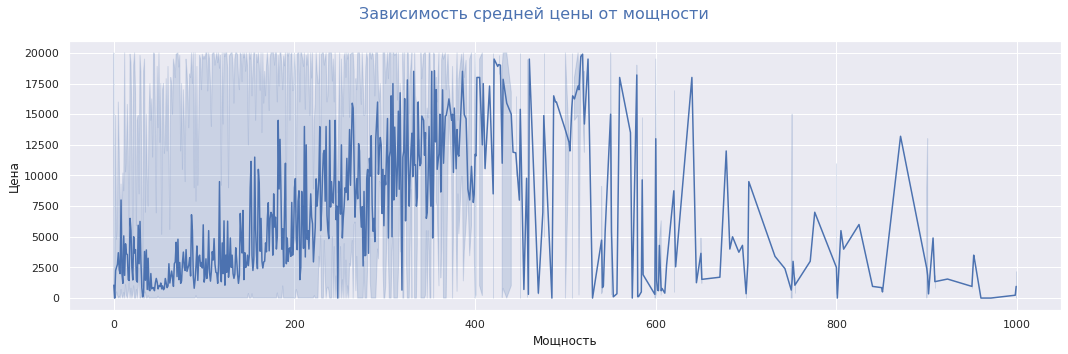

In [65]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data, x="power", y="price", estimator=np.median, errorbar=("pi", 100))
add_plot_titles(suptitle="Зависимость средней цены от мощности", 
                xlabel="Мощность", ylabel="Цена", show=True)

По графику зависимости средней цены от мощности можно отметить что околонулевые значения показывают довольно низкую среднюю цену, которая резко вырастает в промежутке примерно до 50 лошадинных сил, после чего идет снижение средней цены с последующим заметным ростом вплоть до значений более 400 лошадинных сил, далее наблюдается довольно сильный разброс по причине меньшего количества таких записей.

Попробуем установить вероятно не заполненные значения мощности путем замены нулевых значений медианой по модели авто. Если модель не указана, используем медиану по марке авто, так как неизвестно какая это может быть модель.

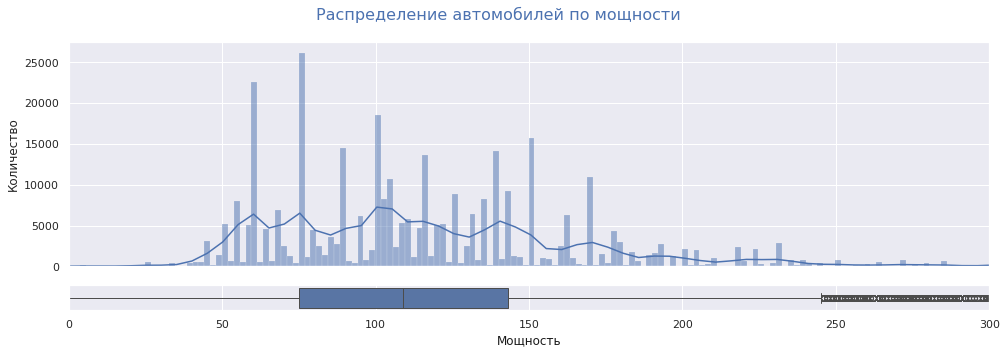

In [66]:
# Заполнение пропущенных значений медианой по модели
data.loc[
    (data["power"] == 0) & (data["model"] != "NA"), "power"
] = data.groupby(["brand", "model"])["power"].transform("median").astype(int)
# Заполнение пропущенных значений медианой по марке
data.loc[
    (data["power"] == 0) & (data["model"] == "NA"), "power"
] = data.groupby("brand")["power"].transform("median").astype(int)
# Вывод графика по полученным значениям
show_num(
    x="power", suptitle="Распределение автомобилей по мощности",
    xlabel="Мощность", ylabel="Количество", xlim=(0, 300)
)

Нулевые значения остались, вероятнее всего для некоторых редких моделей, у которых нулевых значений более половины. Также заметно, что осталось небольшое количество довольно высоких значений.

Попробуем исправить мощность для моделей, в анкетах которых присутствует более половины не заполненных значений путем замены  на значение 75-го процентиля вместо медианы. Тогда нулевыми значения останутся только для автомобилей, для которых не заполнена мощность в более 75% случаев.

In [67]:
# Заполнение пропусков 75 процентилем по модели
data.loc[
    data["power"] == 0, "power"
] = data.groupby(["brand", "model"])["power"].transform(lambda x: x.quantile(0.75).astype(int))

Также избавимся от оставшихся выбросов, для этого ограничим значение мощности методом межквартильного интервала IQR, учитывая, что распределение авто по мощности явно не является нормальным. При этом основная масса автомобилей вероятнее всего сдвигается к автомобилям меньшей мощности, но в рамках одной марки могут быть представлены автомобили с довольно большим разбросом значений по мощности в большую сторону от основной массы авто. На этом основании считаю целесообразным миниум ограничить значениями ниже `1 IQR` от 25-го процентиля, а максимум - более `3 IQR` от 75-го процентиля. Изменим на медиану такие отклонения по мощности в разрезе марок и моделей авто.

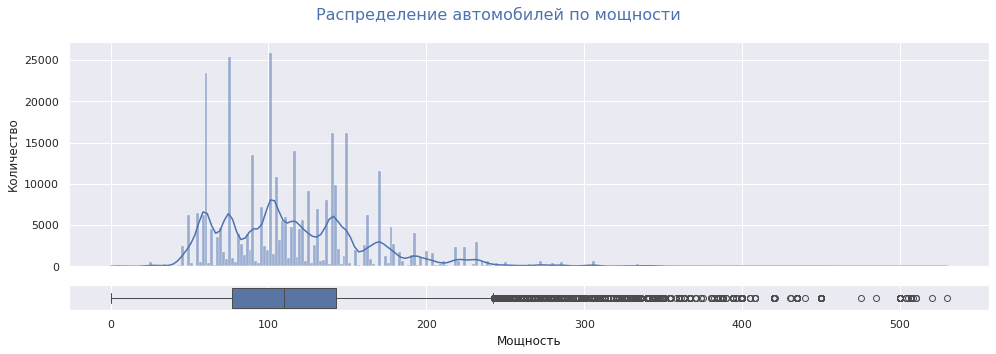


Количество всех изменний значения мощности: 68642 (19.37% от датасета)


In [68]:
# Исключение выбросов ниже Q1-1*IQR и более Q3+3*IQR
data["power"] = data.merge(
    data.groupby(["brand", "model"])["power"]
    .quantile([0.25, 0.5, 0.75]).astype(int).unstack()
    .apply(
        lambda x: pd.Series(
            {
                "min": x[0.5] - (x[0.75] - x[0.25]) * 1,
                "median": x[0.5],
                "max": x[0.5] + (x[0.75] - x[0.25]) * 3
            }, name=x.name
        ),
        axis=1
    ).reset_index(), on=["brand", "model"], how="left"
).apply(
    lambda x: x["median"] if (x["power"] < x["min"]) or (x["power"] > x["max"]) else x["power"],
    axis=1
)

# Вывод графика по полученным значениям
show_num(
    x="power", suptitle="Распределение автомобилей по мощности",
    xlabel="Мощность", ylabel="Количество"
)
print()
print(
    "Количество всех изменний значения мощности:",
    (data["power"] != data["pwr_old"]).sum(),
    f"({(data['power'] != data['pwr_old']).mean():.2%} от датасета)"
)

По результатам обработки признака мощности изменению подверглось порядка четверти записей. Значение мощности для половины датасета находится в промежутке между 79 и 143 лошадинных силы. Осталось малое количество автомобилей, значение мощности которых ниже 26 (в том числе значения `0`) или выше 340 лошадинных сил (За пределами 99,73% от датасета). Вглянем на крайние значения мощности:

In [69]:
print()
print("Автомобили без указания мощности (power=0):")
display(data.query("power == 0"))
print(
    "Всего записей с автомобилем Land Rover Series 1:", 
    data.query("(brand == 'land_rover') and (model == 'serie_1')")["power"].count(),
)
print()
print("\nСлучайная выборка автомобилей мощностью менее 26 л.с.")
display(data.query("power < 26").sample(15, random_state=RANDOM_STATE))
print("Марки авто с наименьшей мощностью:", data.query("power < 26")["brand"].unique())
print()
print()
print("Случайная выборка автомобилей мощностью более 340 л.с.")
display(data.query("power > 340").sample(15, random_state=RANDOM_STATE))
print("Марки авто с наибольшей мощностью:", data.query("power > 340")["brand"].unique())


Автомобили без указания мощности (power=0):


date_crawled  price vehicle_type  reg_year gearbox  power    model  \
234296         16890   3800        wagon      1978  manual      0  serie_1   
280216         16893      0           NA      1970      NA      0  serie_1   

        kilometer  reg_month fuel_type       brand repaired  date_created  \
234296      30000          0  gasoline  land_rover       NA         16890   
280216     100000          0    petrol  land_rover       NA         16893   

        num_of_pict  postal_code  last_seen region  activity_days  month_day  \
234296            0        49824      16890    r49              0         30   
280216            0        88634      16897    r88              4          2   

        week_day  month  pwr_old  
234296         2      3        0  
280216         5      4        0

Всего записей с автомобилем Land Rover Series 1: 2


Случайная выборка автомобилей мощностью менее 26 л.с.


date_crawled  price vehicle_type  reg_year gearbox  power model  \
55626          16872   3000        other      2008    auto     15    NA   
292330         16876   3000        small      2005    auto      7    NA   
226516         16870   5900        small      1969  manual     14    NA   
133797         16892  15990        other      2016    auto      5    NA   
104836         16888   4500        sedan      1935  manual     25    NA   
348975         16879   1850        small      2003    auto      5    NA   
75130          16894   2550        small      1998      NA      5    NA   
305924         16869   1300        other      1986  manual     11    NA   
21482          16871   2900        small      2001    auto      5    NA   
170613         16892   5450           NA      1960  manual     23    NA   
223508         16875   1000        other      1991    auto      3    NA   
343350         16891   7390        small      2012    auto      5    NA   
245004         16882   1600        small      1999    auto      4    NA   
145108         16886   5400        other      2005    auto      4    NA   
30259          16895   2200        small      2003    auto      5    NA   

        kilometer  reg_month fuel_type           brand repaired  date_created  \
55626        5000          7    petrol  sonstige_autos       no         16872   
292330      40000          1  gasoline  sonstige_autos       no         16876   
226516      20000          5    petrol  sonstige_autos       no         16870   
133797       5000          4  gasoline  sonstige_autos       no         16892   
104836       5000          0    petrol  sonstige_autos       no         16888   
348975      50000          3  gasoline  sonstige_autos      yes         16879   
75130       20000          5    petrol  sonstige_autos       NA         16894   
305924      40000          4    petrol  sonstige_autos       NA         16869   
21482       20000          4  gasoline  sonstige_autos       no         16871   
170613      40000          1    petrol  sonstige_autos       NA         16892   
223508      20000          5  electric  sonstige_autos       NA         16875   
343350      20000          3  gasoline  sonstige_autos       no         16891   
245004      50000          4  gasoline  sonstige_autos       no         16882   
145108      30000          9  gasoline  sonstige_autos       no         16886   
30259       10000          9    petrol  sonstige_autos       no         16895   

        num_of_pict  postal_code  last_seen region  activity_days  month_day  \
55626             0        15569      16893    r15             21         12   
292330            0        54456      16896    r54             20         16   
226516            0        76857      16896    r76             26         10   
133797            0        19288      16898    r19              6          1   
104836            0        22850      16897    r22              9         28   
348975            0        13347      16894    r13             15         19   
75130             0        29223      16898    r29              4          3   
305924            0        45964      16870    r45              1          9   
21482             0        53501      16897    r53             26         11   
170613            0        90471      16896    r90              4          1   
223508            0        34513      16876    r34              1         15   
343350            0        89340      16897    r89              6         31   
245004            0        63654      16882    r63              0         22   
145108            0        42275      16887    r42              1         26   
30259             0        74388      16898    r74              3          4   

        week_day  month  pwr_old  
55626          5      3       15  
292330         2      3        7  
226516         3      3       14  
133797         4      4        5  
104836         0      3       25  
348975         5   

Марки авто с наименьшей мощностью: ['sonstige_autos' 'land_rover']


Случайная выборка автомобилей мощностью более 340 л.с.


date_crawled  price vehicle_type  reg_year gearbox  power    model  \
71199          16876  17990        coupe      2005    auto    367      6er   
247192         16881  14900        wagon      2004    auto    450    other   
332566         16876  16990        wagon      2005  manual    364    other   
48667          16865  18000          suv      2008    auto    405  cayenne   
109904         16889     20        small      1988    auto    343  m_reihe   
165297         16887   8499          suv      2009    auto    345       NA   
7468           16883  19500          suv      2004    auto    349       NA   
275390         16884   9650          suv      2005    auto    345       NA   
49614          16875  10800        wagon      2003  manual    344    other   
206138         16880  18299        coupe      2001    auto    343  m_reihe   
34395          16890  14500        sedan      2000    auto    363    other   
78201          16893  18700          suv      2003    auto    450  cayenne   
70514          16882   3900        sedan      2003  manual    343  m_reihe   
347436         16886   8100        sedan      2001    auto    420       a8   
219345         16875      0        coupe      2016    auto    500  m_reihe   

        kilometer  reg_month fuel_type           brand repaired  date_created  \
71199      150000         11    petrol             bmw       no         16876   
247192     150000          4    petrol            audi       no         16881   
332566     150000          4    petrol            audi       no         16876   
48667      150000          6    petrol         porsche       no         16865   
109904       5000          1     other             bmw       no         16889   
165297     100000          8    petrol  sonstige_autos       no         16887   
7468       150000          7       lpg  sonstige_autos       no         16883   
275390     150000         12    petrol  sonstige_autos      yes         16884   
49614      150000         10    petrol            audi       no         16875   
206138     150000         10    petrol             bmw       no         16880   
34395      150000         12    petrol          jaguar       no         16890   
78201      125000          9    petrol         porsche       no         16893   
70514      150000          6        NA             bmw       NA         16882   
347436     150000         11    petrol            audi       no         16886   
219345     100000          6    petrol             bmw       no         16875   

        num_of_pict  postal_code  last_seen region  activity_days  month_day  \
71199             0        90574      16882    r90              6         16   
247192            0        17255      16897    r17             16         21   
332566            0         8056      16897    r08             21         16   
48667             0        25569      16880    r25             15          5   
109904            0        33813      16889    r33              0         29   
165297            0        99423      16887    r99              0         27   
7468              0        15834      16898    r15             15         23   
275390            0        37186      16898    r37             14         24   
49614             0        53757      16892    r53             17         15   
206138            0        90587      16897    r90             17         20   
34395             0        85599      16898    r85              8         30   
78201             0        70376      16893    r70              0          2   
70514             0        74074      16895    r74             13         22   
347436            0        74564      16897    r74             11         26   
219345            0        70839      16897    r70             22         15   

        week_day  month  pwr_old  
71199          2      3      367  
247192         0      3      450  
332566         2      3      364  
48667          5      3      405  
109904

Марки авто с наибольшей мощностью: ['audi' 'bmw' 'sonstige_autos' 'porsche' 'mercedes_benz' 'jaguar' 'subaru'
 'land_rover' 'nissan' 'chrysler' 'ford']


Автомобили со значением мощности равным `0` остались только модели Series 1 марки Land Rover, которых в выборке всего 2 записи с нулевым значением мощности.

Автомобили с наименьшей мощностью после обработки датасета представлены только автомобилями без указания марки `sonstige_autos` кроме марки Land Rover и имеют достаточно низкие значения, начиная с 1 лошадинной силы. Невозможно точно определить, насколько это корректные данные, так как нет точного понимания могут или нет в данную категорию попадать другие транспортные средства, например мопеды или скутеры, для которых данная мощность может быть актуальной.

Автомобили с высокой мощностью представлены в основном бензиновыми представительскими или спортивными марками и моделями авто, такими как Porsche Cayenne, BMW M серии, Audi A8, Jaguar и т.п., для которых подобные мощности не редкость.

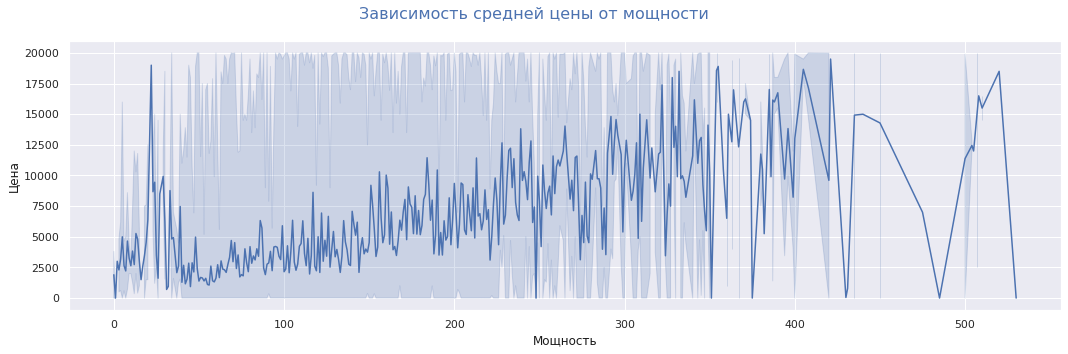

In [70]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data, x="power", y="price", errorbar=("pi", 100))
add_plot_titles(suptitle="Зависимость средней цены от мощности", 
                xlabel="Мощность", ylabel="Цена", show=True)

После изменения данных влияние на целевой признак сохранилось - заметно увеличение средней цены по мере роста мощности, однако в пределах значений до 50 лошадинных сил имеется довольно большой разброс цен. Вероятно это вызвано небольшим количеством записей с такими значениями, а также возможно влияние других факторов. Оценим влияние на мощность факта явного ввода некорректных значений, а также других значений мощности, подтвергшихся изменению.

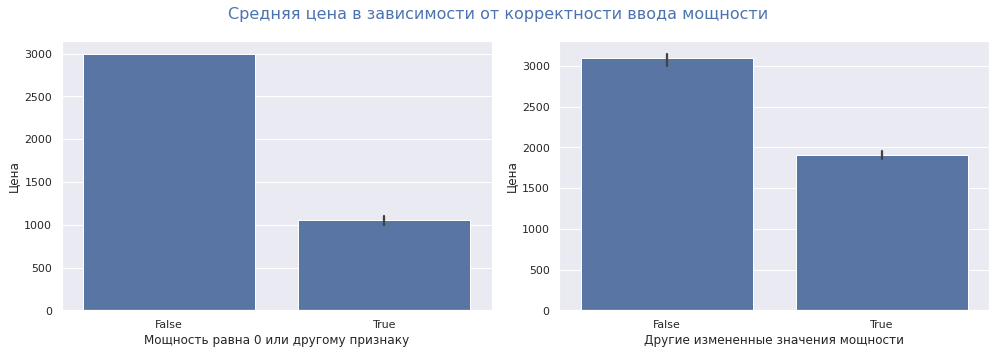

Количество некорректно введенных значений: 40294
Количество других изменненных значений: 28163
Всего значений изменено: 68420


In [71]:
data["is_pwr_zeros"] = (
    (data["pwr_old"] == 0) |
    (data["pwr_old"] == data["price"]) |
    (data["pwr_old"] == data["reg_year"]) |
    (data["pwr_old"] == data["kilometer"])
)
data["is_pwr_changed"] = ~data["is_pwr_zeros"] & (
    (data["power"] != data["pwr_old"]) &
    (data["power"] != data["pwr_old"] // 10) &
    (data["power"] != data["pwr_old"] // 100)
)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(
    data, x="is_pwr_zeros", y="price", estimator=np.median, ax=ax[0]
).set(xlabel="Мощность равна 0 или другому признаку", ylabel="Цена")
sns.barplot(
    data.query("pwr_old != 0"), x="is_pwr_changed", y="price", estimator=np.median, ax=ax[1]
).set(xlabel="Другие измененные значения мощности", ylabel="Цена")
plt.suptitle("Средняя цена в зависимости от корректности ввода мощности", size=16, color="C0")
plt.tight_layout()
plt.show()
print("Количество некорректно введенных значений:", data["is_pwr_zeros"].sum())
print("Количество других изменненных значений:", data["is_pwr_changed"].sum())
print(
    "Всего значений изменено:", (
        (data["power"] != data["pwr_old"]) &
        (data["power"] != data["pwr_old"] //10) &
        (data["power"] != data["pwr_old"] //100)
    ).sum()
)

Заметно сильное влияние явно некорректно введенных значений мощности, таких как `0` или совпадающих с другими численными значениями. Факт изменения значения мощности в процессе подготовки (кроме его масштабирования) оказывает меньшее влияние, средние значения для таких данных существенно ближе, однако тоже имеют достаточно большое расхождение. Оставим дополнительные признаки, которые могут быть существенными для простых моделей, таких как линейная регрессия.

В дополнение также стоит отметить, что оставлять пользователю возможность свободного ввода информации о мощности не самая лучшая идея. Наиболее оптимальным было бы использование справочных данных по моделям автомобиля к привязке к поколениям модели и видам используемых двигателей с возможностью пользователя только выбора из предложенных вариантов, так как по данному датасету очевидно, что пользователи могут вводить любые значения, которые вообще не имеют ничего общего с реальными данными.

##### Год регистрации

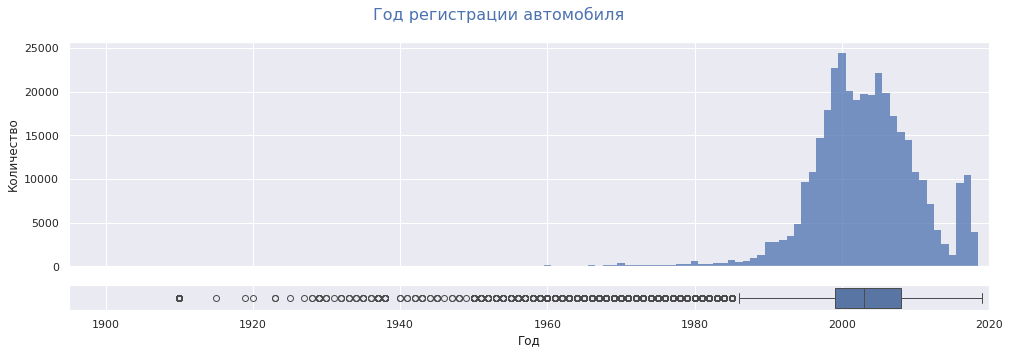

Количество уникальных записей до 1896 года: 66


2015  2016   2017  2018  2019
Количество записей  1302  9599  10441  3959    25

Количество уникальных записей после 2020 года: 105


In [72]:
show_num(x="reg_year", kde=False, suptitle="Год регистрации автомобиля", 
         xlabel="Год", ylabel="Количество", discrete=True, xlim=(1895, 2020))
print("Количество уникальных записей до 1896 года:", 
      data.query("reg_year < 1896").shape[0])
display(data.query("2015 <= reg_year <= 2020")["reg_year"]\
    .value_counts().sort_index().rename("Количество записей").to_frame().T)
print("Количество уникальных записей после 2020 года:", 
      data.query("reg_year > 2020").shape[0])

По году регистрации можно отметить, что имеются значения ранее 1900 года, хотя [регистрация автомобилей в Германии началась с 1896 года](https://en.wikipedia.org/wiki/Vehicle_registration_plate#History). В этих пределах выведен график с запасом до 2020 года, половину выборки занимают анкеты с годом регистрации автомобилей между 1999 и 2008 годами, также можно отметить довольно большое количество автомобилей - более 1% от выборки, год регистрации которых выше даты выгрузки, при этом основная масса таких записей сосредоточена в пределах 2016-2019 годов, далее записи идут с большим отрывом а максимальное значение составляет 9999 год. 

Распределение мультимодальное, резкий рост количества анкет начинается примерно 1990 года, а наиболее часто встречается 2000 год, также имеется довольно большое количество в районе 2005 года, далее происходит достаточно резкое снижение до 2015 года, после чего количество автомобилей резко увеличивается в пределах 2016-2017 и снижается до 2019 года.

In [73]:
print()
print("Минимальные и максимальные значения года регистрации в выборке:")
display(data.sort_values("reg_year"))


Минимальные и максимальные значения года регистрации в выборке:


date_crawled  price vehicle_type  reg_year gearbox  power  \
244092         16886   2000           NA      1000      NA     49   
91869          16871    400           NA      1000      NA     49   
143621         16877    550           NA      1000      NA     95   
55605          16870    500           NA      1000      NA     90   
164397         16889      0           NA      1000      NA    102   
...              ...    ...          ...       ...     ...    ...   
167937         16883   1000           NA      9999      NA    110   
217111         16886    850           NA      9999      NA    143   
149151         16893    400           NA      9999      NA     49   
326725         16874     60           NA      9999      NA    109   
224832         16883      0           NA      9999      NA    101   

              model  kilometer  reg_month fuel_type           brand repaired  \
244092           NA       5000          0        NA  sonstige_autos       NA   
91869            NA       5000          0        NA  sonstige_autos       NA   
143621         golf       5000          6    petrol      volkswagen       NA   
55605            NA       5000          0        NA         citroen      yes   
164397  transporter       5000          1        NA      volkswagen       NA   
...             ...        ...        ...       ...             ...      ...   
167937           NA      10000          0        NA           mazda       NA   
217111          3er      10000          0        NA             bmw       no   
149151           NA      10000          0        NA  sonstige_autos       NA   
326725           c4      10000          0        NA         citroen       NA   
224832           NA      10000          0        NA      volkswagen       NA   

        date_created  num_of_pict  postal_code  last_seen region  \
244092         16886            0        31188      16893    r31   
91869          16871            0        48683      16872    r48   
143621         16877            0        91732      16886    r91   
55605          16870            0        24811      16897    r24   
164397         16889            0        29351      16897    r29   
...              ...          ...          ...        ...    ...   
167937         16883            0        40822      16883    r40   
217111         16886            0        77746      16891    r77   
149151         16893            0        26441      16893    r26   
326725         16874            0        53879      16882    r53   
224832         16883            0         9437      16883    r09   

        activity_days  month_day  week_day  month  pwr_old  is_pwr_zeros  \
244092              7         26         5      3        0          True   
91869               1         11         4      3        0          True   
143621              9         17         3      3     1000          True   
55605              27         10         3      3        0          True   
164397              8         29         1      3        0          True   
...               ...        ...       ...    ...      ...           ...   
167937              0         23         2      3        0          True   
217111              5         26         5      3        0          True   
149151              0          2         5      4        0          True   
326725              8         14         0      3        0          True   
224832              0         23         2      3        0          True   

        is_pwr_changed  
244092           False  
91869            False  
143621           False  
55605            False  
164397           False  
...                ...  
167937           False  
217111           False  
149151           False  
326725           False  
224832           False  

[354369 rows x 24 columns]

Можно заметить, что при некорректно указанных значениях года регистрации в некоторых записях пропущены значения модели авто, а также довольно часто пропущены такие признаки как тип кузова, тип КПП и вид топлива, а также месяц регистрации и мощность установлены в значении 0. Вероятно некоторые пользователи не сильно заботились о полном заполнении характеристик автомобиля, а в части года регистрации могли указать любое число между 1000 и 9999.

Взглянем на распределение автомобилей с нулевой ценой.

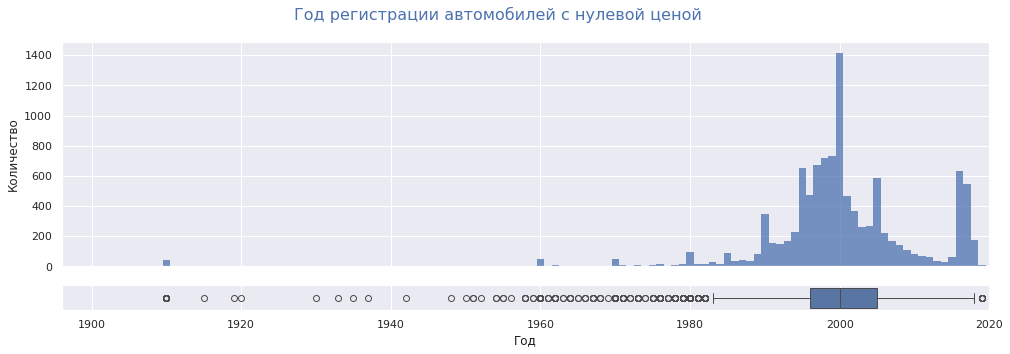

Количество уникальных записей до 1896 года: 13


2015  2016  2017  2018  2019
Количество записей    59   631   546   177     9

Количество уникальных записей после 2020 года: 19


In [74]:
show_num(data=data.query("price == 0"), x="reg_year", kde=False, 
         suptitle="Год регистрации автомобилей с нулевой ценой", 
         xlabel="Год", ylabel="Количество", discrete=True, xlim=(1896, 2020))
print("Количество уникальных записей до 1896 года:", 
      data.query("price == 0 and reg_year < 1896").shape[0])
display(data.query("price == 0 and 2015 <= reg_year <= 2020")["reg_year"]\
    .value_counts().sort_index().rename("Количество записей").to_frame().T)
print("Количество уникальных записей после 2020 года:", 
      data.query("price == 0 and reg_year > 2020").shape[0])

По записям с нулевым целевым значением распределение также имеет моду на 2000 году, но эта мода более ярко выражена, как и отдельные пики на 2005 и 1990, 1995 годах, а также ярко выражены значения с 2016 по 2018 годы. Также как и в общей выборке имеются большие отрывы от 1000 до 9999.

Для корректной работы моделей для сервиса желательно ограничить значения вводимых пользователями данных о годе регистрации в пределах марок и моделей, а лучше даже поколений моделей автомобилей. В нашем случае ограничим нижние значения, например, 1900 годом, а верхние значения 2019 годом, так как нет понимания причины наличия довольно большого количества автомобилей с годом регистрации выше, чем год создания или изменения анкет. Значением по умолчанию установим 1900 год для тех пользователей, которые некорректно ввели год регистрации. Приведем все явно аномальные значения к 1900 году и оценим влияние таких значений на среднюю цену.

In [75]:
min_year = 1900
max_year = 2019
data["reg_year_old"] = data["reg_year"].copy()
#data["reg_year"] = data["reg_year_old"].copy()

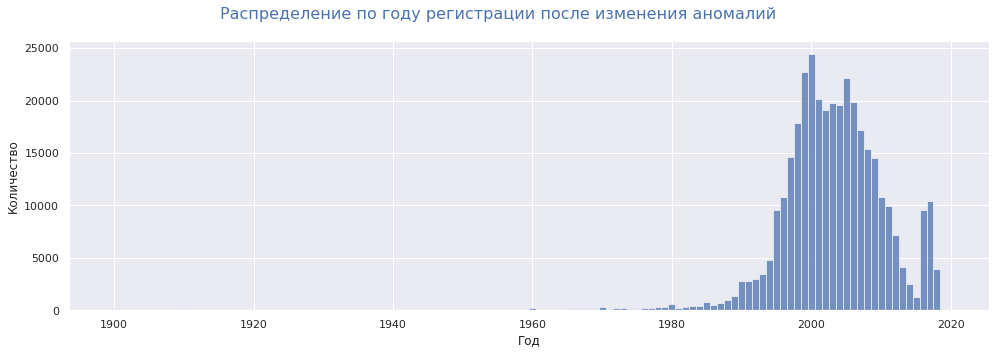

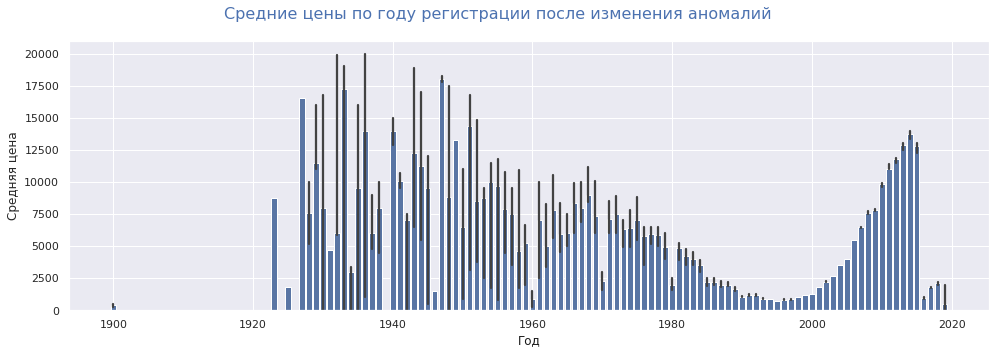


Случайная выборка в пределах 2016-2019 годов:


date_crawled  price vehicle_type  reg_year gearbox  power     model  \
104588         16894   1999           NA      2016  manual     75      polo   
351062         16872   2850           NA      2018  manual    116        NA   
180760         16877   5299           NA      2016  manual     69     ibiza   
275583         16889    950           NA      2016  manual    131    passat   
325223         16875    850           NA      2017  manual     75        NA   
57123          16876   2500           NA      2016      NA    115   primera   
289338         16865    649           NA      2016  manual     75        NA   
337942         16876   2800           NA      2017    auto    101      golf   
86898          16868   4400           NA      2018  manual    107      golf   
151572         16880   2950           NA      2016  manual    116    galaxy   
165799         16887    350           NA      2016  manual     95  a_klasse   
274040         16886    555           NA      2016  manual     75      golf   
51611          16892  10850           NA      2017    auto    105      polo   
225899         16875   6400           NA      2016  manual    150        a3   
44378          16869    800           NA      2017  manual     90     other   

        kilometer  reg_month fuel_type          brand repaired  date_created  \
104588     150000         12  gasoline     volkswagen       NA         16894   
351062     150000          3        NA           seat       NA         16872   
180760     125000          7    petrol           seat       no         16877   
275583     150000          4        NA     volkswagen       no         16889   
325223     150000          4    petrol        hyundai      yes         16875   
57123      150000          2  gasoline         nissan       no         16876   
289338     150000          0  gasoline           ford       NA         16865   
337942     150000          4    petrol     volkswagen       no         16876   
86898      150000          0  gasoline     volkswagen       no         16868   
151572     150000         12        NA           ford       NA         16880   
165799     150000          0    petrol  mercedes_benz      yes         16887   
274040     150000          0  gasoline     volkswagen       NA         16886   
51611       90000          2    petrol     volkswagen       no         16892   
225899     125000          7    petrol           audi       no         16875   
44378      150000          0        NA         toyota       no         16869   

        num_of_pict  postal_code  last_seen region  activity_days  month_day  \
104588            0        49090      16894    r49              0          3   
351062            0        74906      16874    r74              2         12   
180760            0        58638      16897    r58             20         17   
275583            0        30167      16896    r30              7         29   
325223            0        41836      16875    r41              0         15   
57123             0        41061      16891    r41             15         16   
289338            0        13051      16869    r13              4          5   
337942            0        44807      16897    r44             21         16   
86898             0        32423      16894    r32             26          8   
151572            0        29683      16897    r29             17         20   
165799            0        46414      16887    r46              0         27   
274040            0         1819      16895    r01              9         26   
51611             0        14797      16896    r14              4          1   
225899            0        99310      16896    r99             21         15   
44378             0        12349      16869    r12              0          9   

        week_day  month  pwr_old  is_pwr_zeros  is_pwr_changed  reg_year_old  
104588         6      4       75         False           False          2016  
351062         5      3

In [76]:
# Преобразование явных аномалий
data.loc[(data["reg_year"] < min_year) | (data["reg_year"] > max_year), "reg_year"] = min_year
# Вывод графика распределения
show_num(
    x="reg_year", kde=False, discrete=True, boxplot=False, describe=False,
    suptitle="Распределение по году регистрации после изменения аномалий",
    xlabel="Год", ylabel="Количество"
)
# Вывод средних цен
show_num(
    x="reg_year", y="price", kind="bar", boxplot=False,
    suptitle="Средние цены по году регистрации после изменения аномалий",
    xlabel="Год", ylabel="Средняя цена"
)
print()
print("Случайная выборка в пределах 2016-2019 годов:")
display(data.query("2015 < reg_year < 2020").sample(15, random_state=RANDOM_STATE))

Очевидно, что год регистрации автомобиля довольно сильно влияет на целевой признак. Средние цены более старых авто имеют достаточно большой разброс и в целом относительно высокие, наименьшие средние цены приходятся на период с 1990 по 2000 год, дальше наблюдается существенный рост цены по мере увеличения года регистрации. Можно предположить, что срок в 20 лет - это такой индикатор, который переводит обычные авто в 'ретро', вследствие чего их цена начинает постепенно возрастать со временем.

Количество выбросов (ниже 1900 и выше 2020 года) небольшое, однако имеется большое количество пользователей, которые вводили в качестве года регистрации год выгрузки датасета или последующие 3 года - с 2016 по 2019 годы. Судя по стоимости автомобилей из этого периода, это явно не новые автомобили, они существенно ниже чем цены по дате регистрации за предыдущие годы, а также имеют в основном высокие значения пробега. 

Вероятнее всего в период с 2016 по 2019 годы также попали некорректно введенные сведения по году регистрации, установим для таких записей медианное значение по марке и модели автомобиля.

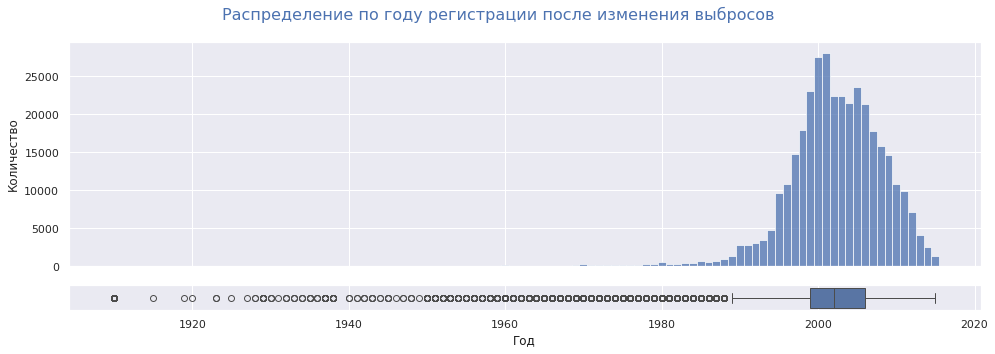

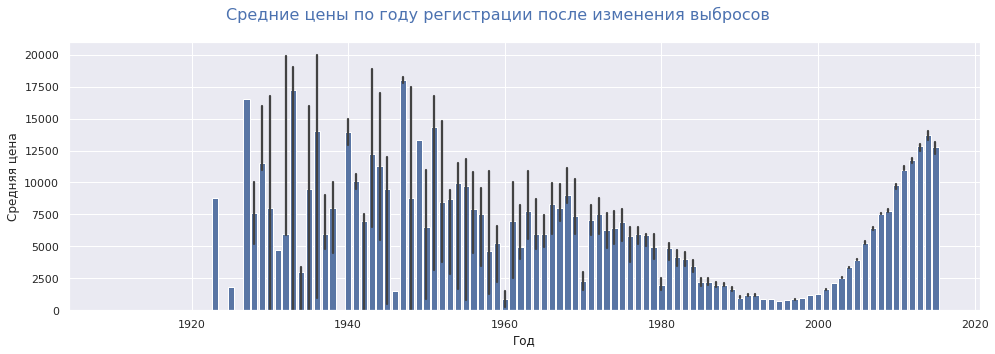

In [77]:
# Преобразование выбросов
min_year = 1901
max_year = 2015
data.loc[
    (data["reg_year"] < min_year) | (data["reg_year"] > max_year), 
    "reg_year"
] = data.groupby(["brand", "model"])["reg_year"].transform("median").astype(int)

# Вывод графика распределения
show_num(
    x="reg_year", kde=False, discrete=True, describe=False,
    suptitle="Распределение по году регистрации после изменения выбросов",
    xlabel="Год", ylabel="Количество"
)
# Вывод средних цен
show_num(
    x="reg_year", y="price", kind="bar", boxplot=False,
    suptitle="Средние цены по году регистрации после изменения выбросов",
    xlabel="Год", ylabel="Средняя цена"
)

Распределение стало более равномерным, по средним ценам существенных изменений не наблюдается. Немного странным может быть то, что у автомобилей 2015 года регистрации средняя цена немного ниже, чем за предыдущий год, но на этот год приходится довольно небольшое количество данных, а также могут влиять и другие факторы.

В части распределения по годам можно попробовать ввести новые признаки - количество лет больше или меньше 20-летнего лага от текущего года, так чтобы все что больше/меньше равнялось 0, а остальные цифры начинались с 1 по мере удаления.

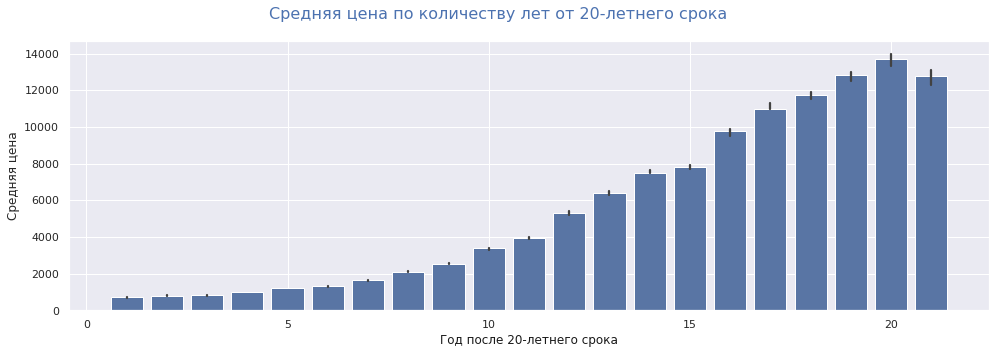

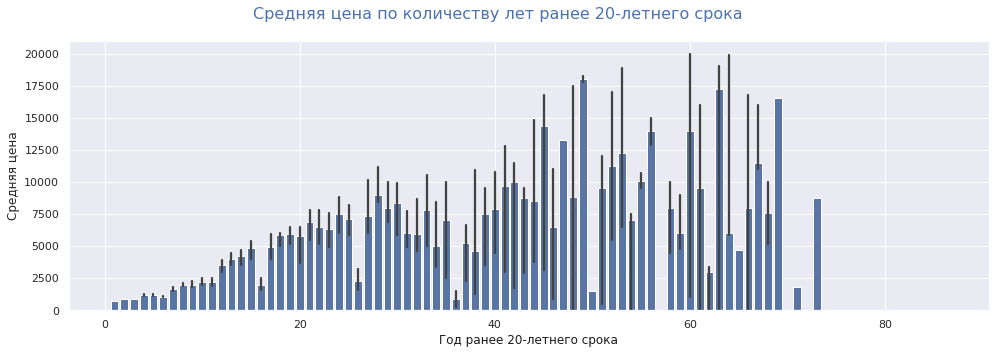

In [78]:
old_year = data["reg_year"].max() - 20
data.groupby("reg_year")["price"].median().sort_values().head(10)
data.loc[(data["reg_year"] - old_year) >= 0, "reg_year_over"] = (data["reg_year"] - old_year + 1).astype(int)
data.loc[(data["reg_year"] - old_year) <= 0, "reg_year_less"] = (old_year - data["reg_year"] + 1).astype(int)
data.fillna({"reg_year_over": 0, "reg_year_less": 0}, inplace=True)
show_num(
    data=data.query("reg_year_over > 0"), x="reg_year_over", y="price", kind="bar", boxplot=False,
    suptitle="Средняя цена по количеству лет от 20-летнего срока",
    xlabel="Год после 20-летнего срока", ylabel="Средняя цена"
)
show_num(
    data=data.query("reg_year_less > 0"), x="reg_year_less", y="price", kind="bar", boxplot=False,
    suptitle="Средняя цена по количеству лет ранее 20-летнего срока",
    xlabel="Год ранее 20-летнего срока", ylabel="Средняя цена"
)

По мере роста количества лет между 20-летним лагом в обе стороны наблюдается увеличение средней цены, значения для "ретро" автомобилей имеют больший разброс на малом количестве данных, которые уменьшаются по мере роста показателя.

Оценим также влияние на среднюю цену факта указания явно некорректного года, так как у таких данных были сильные расхождения с основной массой.

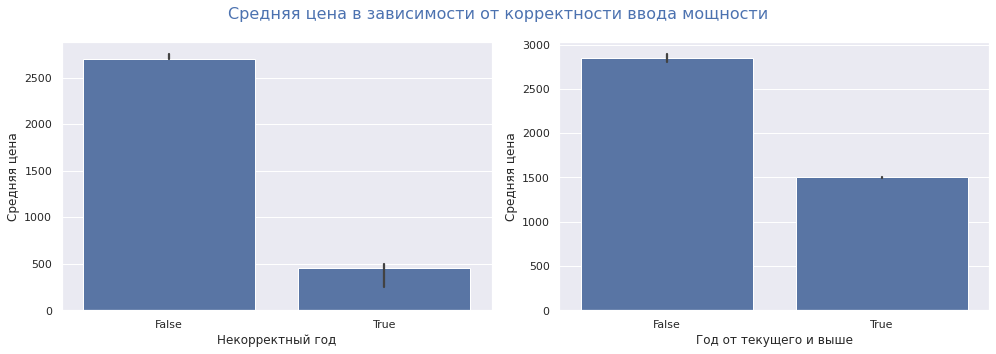

Количество некорректных значений года регистрации: 171
Количество значений года регистрации от 2016 до 2019: 24024


In [79]:
data["is_year_wrong"] = (data["reg_year_old"] > 2020) | (data["reg_year_old"] < 1900)
data["is_year_over"] = (~data["is_year_wrong"]) & (data["reg_year_old"] > 2015)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(
    data=data, x="is_year_wrong", y="price", estimator=np.median, ax=ax[0]
).set(xlabel="Некорректный год", ylabel="Средняя цена")
sns.barplot(
    data=data, x="is_year_over", y="price", estimator=np.median, ax=ax[1]
).set(xlabel="Год от текущего и выше", ylabel="Средняя цена")
plt.suptitle("Средняя цена в зависимости от корректности ввода мощности", size=16, color="C0")
plt.tight_layout()
plt.show()
print("Количество некорректных значений года регистрации:", data["is_year_wrong"].sum())
print("Количество значений года регистрации от 2016 до 2019:", data["is_year_over"].sum())

Очень сильно оказывает влияние на среднюю цену некорректное указание года ниже 1900 и выше 2020 года. Значения от 2016 до 2019 года также ниже средних. Корректность ввода года регистрации для остальных значений проверить будет достаточно трудозатратно.

##### Месяц регистрации

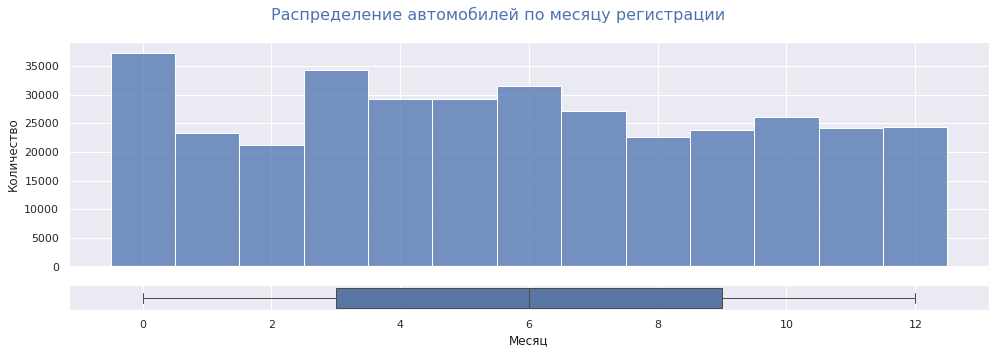

In [80]:
show_num(
    x="reg_month", suptitle="Распределение автомобилей по месяцу регистрации",
    xlabel="Месяц", ylabel="Количество", discrete=True, kde=False
)

По месяцу регистрации автомобилей имеются 12 значений от 1 до 12, а также значение `0`, которых наибольшее количество. Это вероятнее всего говорит о том, что это значение является значением по умолчанию и не менялось пользователем, поэтому оставим данный признак как есть. Оценим средние цены автомобилей в разрезе месяца регистрации.

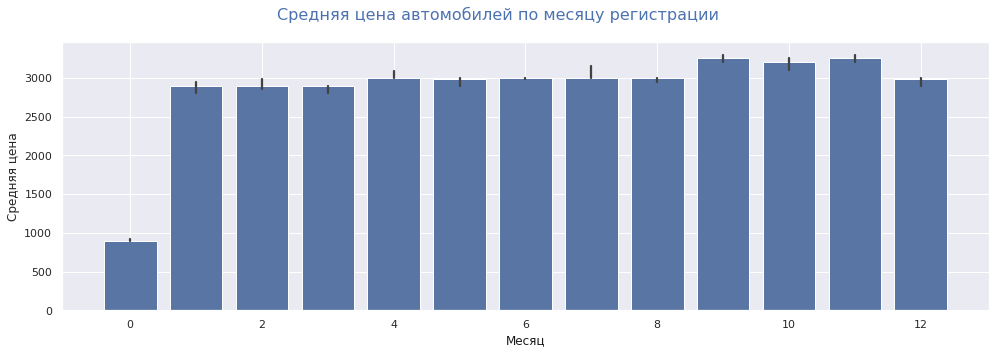

In [81]:
show_num(
    x="reg_month", y="price", kind="bar", boxplot=False,
    suptitle="Средняя цена автомобилей по месяцу регистрации",
    xlabel="Месяц", ylabel="Средняя цена", describe=False
)

Распределение средней цены по месяцу регистрации достаточно равномерное, хотя наблюдается небольшой рост к концу года. Сильно выделяется средняя цена для значеня `0`, которая существенно ниже остальных значений. Оставим поле как есть.

##### Пробег

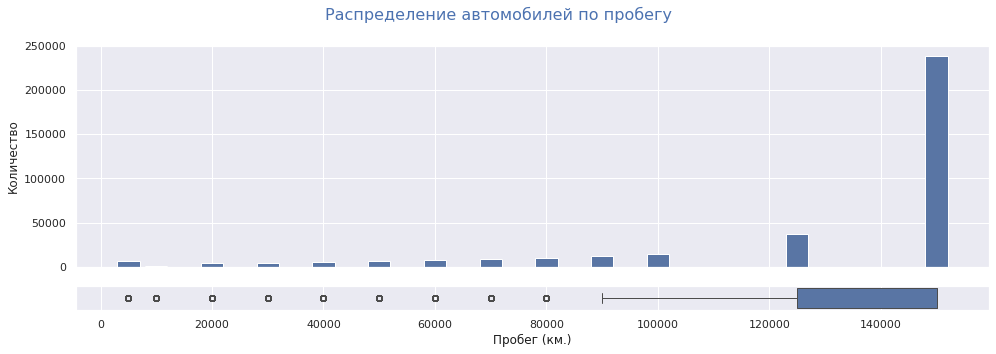

In [82]:
show_num(
    x="kilometer", kind="count",
    suptitle="Распределение автомобилей по пробегу", 
    ylabel="Количество", xlabel="Пробег (км.)"
)

Основная масса автомобилей приходится на пробег 150'000 километров, судя по всему пользователь может выбирать из предложенного списка вариантов - 5'000, 10'000-100'000 (с шагом в 10'000), 125'000 и 150'000. Значения выше отсутствуют. Более 50% автомобилей приходится на значение пробега 150'000 километров. Количество записей в целом уменьшается по мере уменьшения пробега, кроме пробега в 5'000 километров, количество которых возрастает.

Оценим средние цены автомобилей в зависимости от пробега.

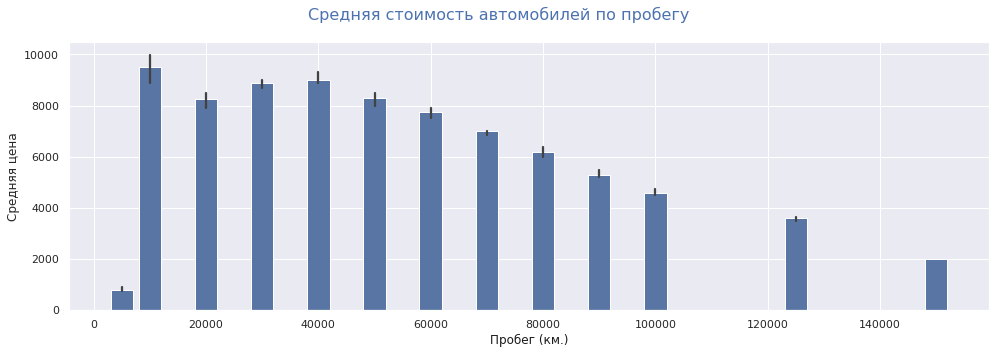

In [83]:
show_num(
    x="kilometer", y="price", kind="bar", boxplot=False, 
    suptitle="Средняя стоимость автомобилей по пробегу", 
    ylabel="Средняя цена", xlabel="Пробег (км.)", describe=False
)

По средней стоимости автомобилей в разрезе пробега очень сильно выделяется значение пробега 5'000 километров, цена которого существенно ниже средней цены автомобилей даже с пробегом в 150'000 километров. Возможно данное значение является значением по умолчанию и некоторые пользователи не изменяли его. В целом идет снижение средней цены по мере увеличения пробега, хотя при значениях 20'000-30'000 идет некоторое снижение средней цены. Оценим распределение по году регистрации автомобиля.

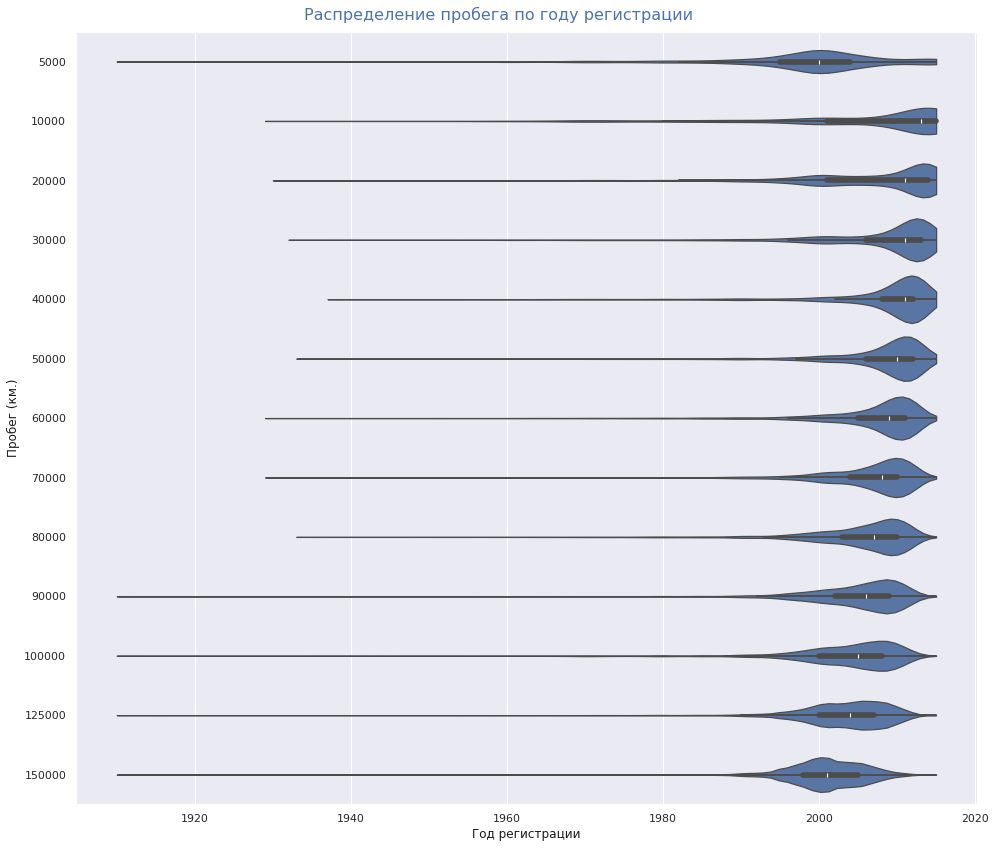

In [84]:
plt.figure(figsize=(14, 12))
sns.violinplot(data, x="reg_year", y="kilometer", orient="h", cut=0)
add_plot_titles(
    suptitle="Распределение пробега по году регистрации", 
    xlabel="Год регистрации", ylabel="Пробег (км.)", show=True
)

При значении пробега 5'000 очень сильные расхождения со всеми остальными группами - основные значения по году регистрации сильно сдвинуты влево, а медиана даже ниже чем при пробеге в 150'000. Оценим распределение количественных признаков для разных значений пробега авто - 5'000, 10'000, 20'000 и 150'000 километров.

In [85]:
print()
print("Данные по авто с пробегом 5'000:")
show_describe(data=data.query("kilometer == 5000")[["price", "reg_year", "power"]])
print()
print("Данные по авто с пробегом 10'000:")
show_describe(data=data.query("kilometer == 10000")[["price", "reg_year", "power"]])
print()
print("Данные по авто с пробегом 20'000:")
show_describe(data=data.query("kilometer == 20000")[["price", "reg_year", "power"]])
print()
print("Данные по авто с пробегом 150'000:")
show_describe(data=data.query("kilometer == 150000")[["price", "reg_year", "power"]])


Данные по авто с пробегом 5'000:



Данные по авто с пробегом 10'000:



Данные по авто с пробегом 20'000:



Данные по авто с пробегом 150'000:


Очевидно, что по мере увеличения значения пробега увеличивается и количество таких записей, при этом записей с пробегом 5'000 километров существенно больше чем записей с пробегом 20'000 километров. Исправление некорректно введенных значений очень трудозавтратно. Значением пробега по умолчанию для сервиса лучше установить 150'000 километров, как самое распространенное. 

В данном случае оставим поле как есть. По сути данное поле является категориальным признаком, так как значения не являются непрерывными и имеет место 13 уникальных значений, лучше данное поле кодировать как категориальное.

##### Количество изображений

In [86]:
show_describe(data["num_of_pict"])

Данный признак содержит все нулевые значения, данное поле можно удалить так как оно не сдержит данных.

### Корреляционный анализ

#### Матрица корреляции

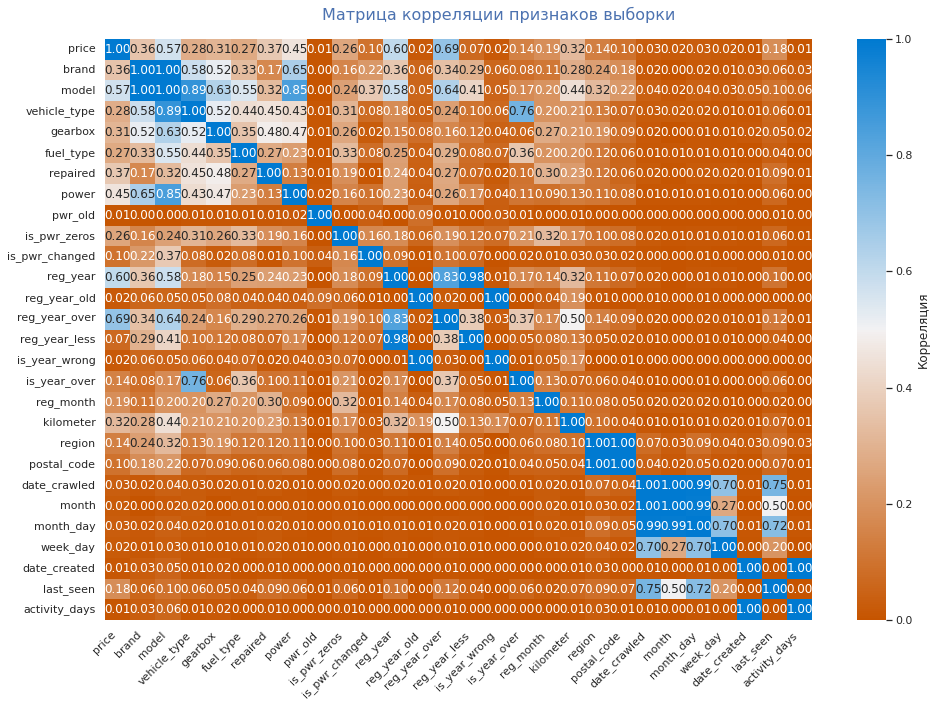

In [87]:
cols = [
    "price", "brand", "model", "vehicle_type", "gearbox", "fuel_type", "repaired",
    "power", "pwr_old", "is_pwr_zeros", "is_pwr_changed", "reg_year", "reg_year_old", 
    "reg_year_over", "reg_year_less", "is_year_wrong", "is_year_over", "reg_month", 
    "kilometer", "region", "postal_code", "date_crawled", "month", "month_day", "week_day",
    "date_created", "last_seen", "activity_days"
]
plt.figure(figsize=(14, 10))
sns.heatmap(
    (
        data[cols].phik_matrix(
            interval_cols=[
                "price", "power", "pwr_old", "reg_year", "reg_year_old", 
                "reg_year_over", "reg_year_less", "reg_month", "postal_code", 
                "date_crawled", "month_day", "date_created", "last_seen", "activity_days"
            ]
        )
    ), 
    annot=True, fmt=".2f", cbar_kws={"label": "Корреляция"},
    cmap=sns.diverging_palette(25, 250, s=100, l=50, as_cmap=True)
)
plt.xticks(rotation=45, ha="right")
add_plot_titles(suptitle="Матрица корреляции признаков выборки", show=True)

Заметная корреляция целевого признака с признаками года регистрации (0.6), особенно с новым признаком года выше 20-летнего лага (0.69). Причем по признаку года в другую сторону от этого лага корреляция очень слабая, а по значению до обработки корреляция еще ниже. Также заметная корреляция с признаком модели автомобиля (0.57). 

Умеренная корреляция целевого признака с признаком мощности (0.45), ремонта (0.37), марки (0.36) и пробега (0.32). Слабая корреляция с признаком типа кузова и типа топлива (0.28 и 0.27), а также новым признаком нулевой мощности (0.26). Еще ниже корреляция с датой последней активности (0.18), новым признаком позднего года с 2016 по 2019 и признаком региона (по 0.14 с каждым). По остальным признакам корреляция очень слабая.

Мультиколлинеарность имеется между новыми и исходными признаками, а также между признаками модели и марки. Также довольно высокая корреляция между моделью и типом кузова, а также моделью и мощностью. Неожидано высокая корреляция между признаками типа кузова и новым признаком года регистрации с 2016 по 2019.

#### Корреляция с целевым признаком

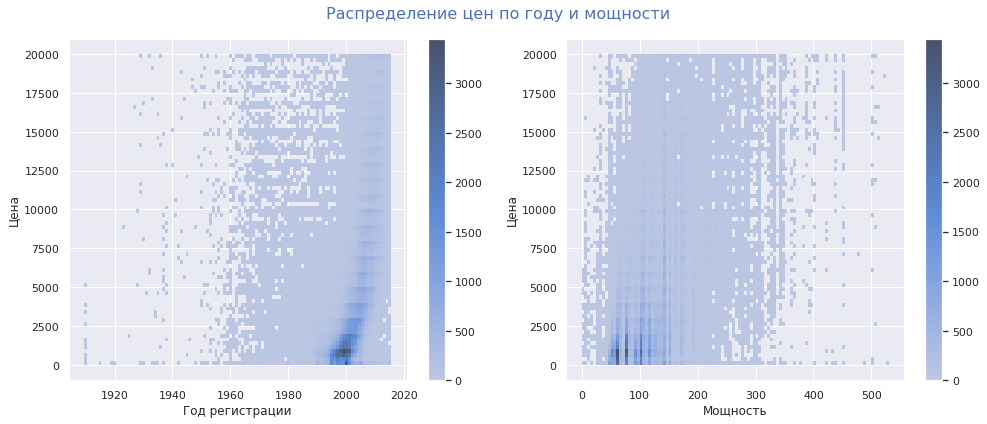

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(
    data, x="reg_year", y="price", discrete=(True, False), binwidth=(1, 250), 
    cbar=True, ax=ax[0]).set(xlabel="Год регистрации", ylabel="Цена")
sns.histplot(
    data, 
    x="power", y="price", binwidth=(5, 250), 
    cbar=True, ax=ax[1]).set(xlabel="Мощность", ylabel="Цена")
add_plot_titles(
    suptitle="Распределение цен по году и мощности", show=True)

По году регистрации наблюдается зависимость цены от года для основной массы автомобилей. Причем зависимость эта больше похожа на степенную со сдвигом центра координат ближе к 20-летнему лагу. Также заметно большое количество анкет, имеющих околонулевую стоимость в районе 2000 года. 

По мощности также наблюдается не очень явная зависимость, имеются несколько групп на распространенных значениях мощности, но по мере роста мощности больше анкет с более высокими ценами. Хотя довольно много анкет остается и в нижних значениях, разброс значений очень высокий, практически по всем значениям цен для мощностей в широком диапазоне мощности от 100 до 250.

Взглянем также на признаки, производные от года регистрации.

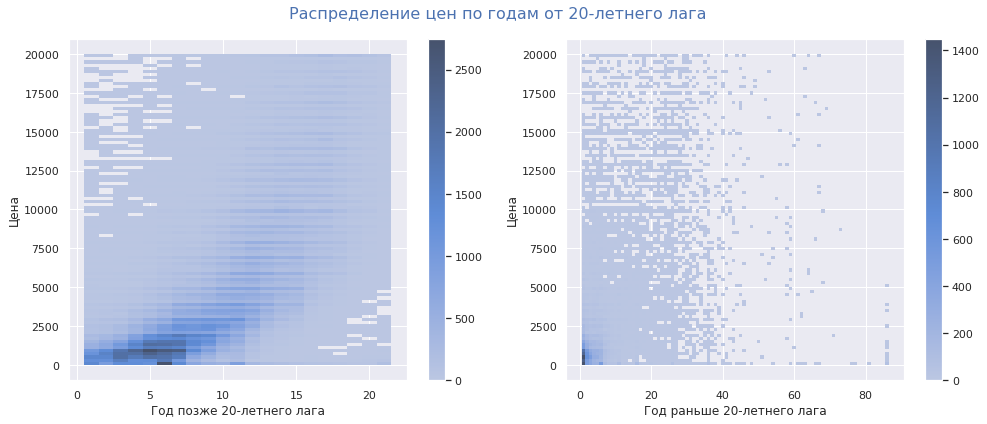

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(
    data.query("reg_year_over > 0"), x="reg_year_over", y="price", discrete=(True, False),  
    binwidth=(1, 200), cbar=True, ax=ax[0]).set(xlabel="Год позже 20-летнего лага", ylabel="Цена")
sns.histplot(
    data.query("reg_year_less > 0"), x="reg_year_less", y="price", discrete=(True, False),  
    binwidth=(20, 200), cbar=True, ax=ax[1]).set(xlabel="Год раньше 20-летнего лага", ylabel="Цена")
add_plot_titles(
    suptitle="Распределение цен по годам от 20-летнего лага", show=True)

Для автомобилей от 20 лет и моложе наблюдается более выраженная зависимость в виде степенной функции, хотя для более дорогих автомобилей имеется более широкий разброс по году. Автомобили старше 20-летнего возраста имеют очень большой разброс по цене, явная корреляция не наблюдается, большая часть автомобилей сосредоточена в нижнем левом углу для низких значений цены и года старше 20-летнего лага.

Оценим графики для молодых автомобилей c при возведении года от 20-летнего лага в разную степень.

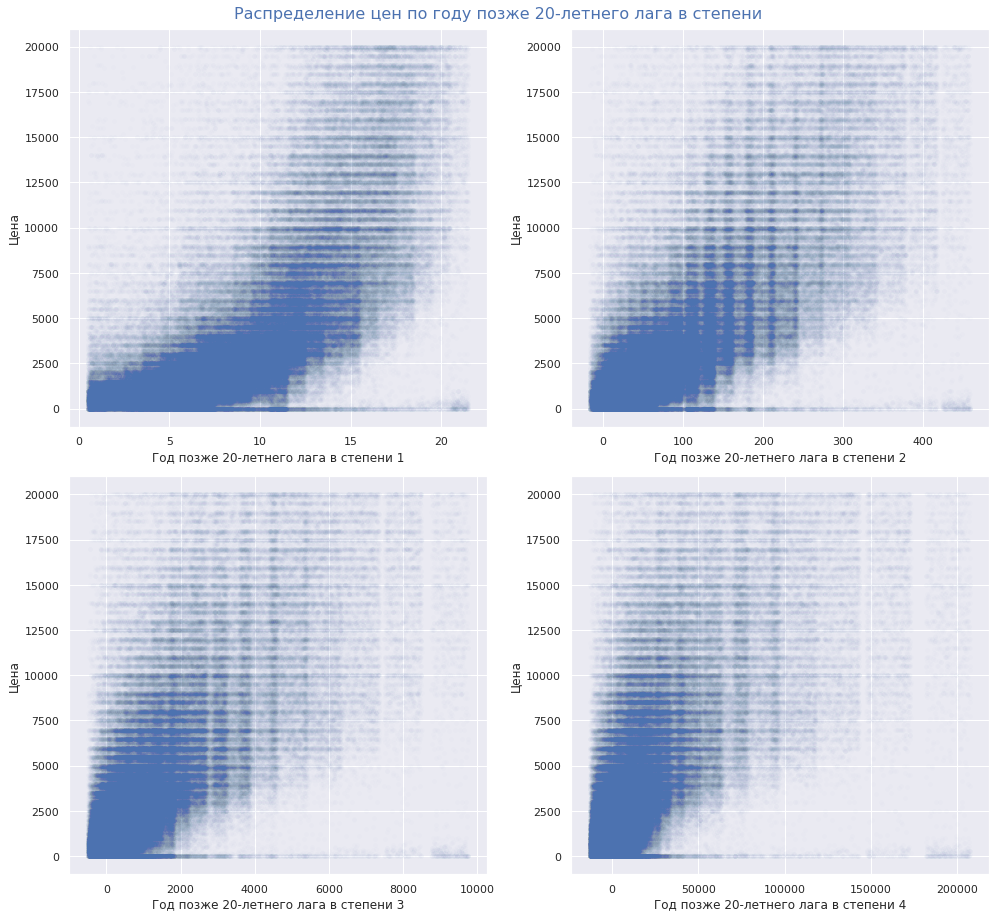

In [90]:
fig, ax = plt.subplots(2, 2, figsize=(14, 13))
for i in range(4):
    data["reg_year_over_n"] = data["reg_year_over"] ** (i + 1)
    sns.stripplot(
        data=data.query("reg_year_over > 0"), x="reg_year_over_n", y="price", 
        native_scale=True, alpha=0.01, jitter=0.5 * (12 ** i), ax=ax[i // 2, i % 2]
    ).set(xlabel=f"Год позже 20-летнего лага в степени {i+1}", ylabel="Цена")
add_plot_titles(
    suptitle="Распределение цен по году позже 20-летнего лага в степени", show=True)
data.drop(columns="reg_year_over_n", inplace=True)

При возведении года позже 20-летнего лага в квадрат сохраняется небольшая степенная зависимость, при возведении в куб зависимость изменяется в другую сторону, как при корневой функции. В степени 4 функция еще сильнее напоминает корневую. Вероятно наиболее оптимальным было бы использование степени в промежутке между 2 и 3 для линейной модели.

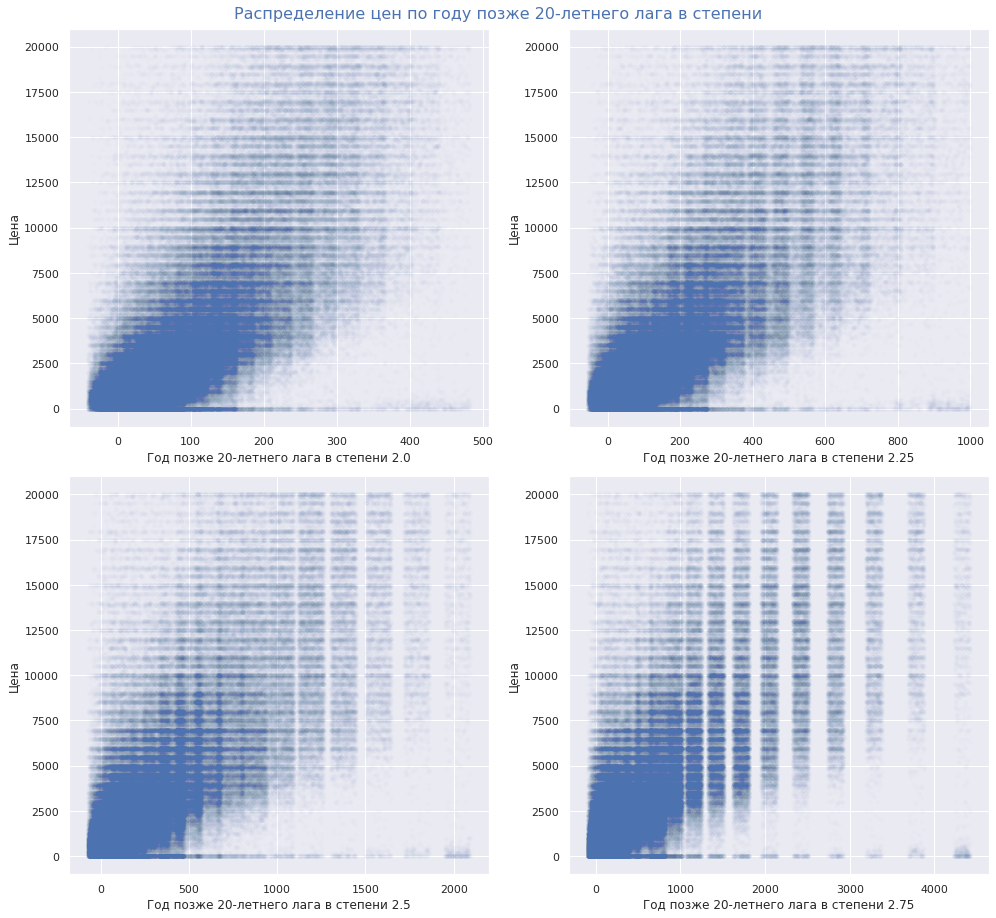

In [91]:
# Оценка 
fig, ax = plt.subplots(2, 2, figsize=(14, 13))
for i in range(4):
    data["reg_year_over_n"] = data["reg_year_over"] ** (2+i/4)
    sns.stripplot(
        data=data.query("reg_year_over > 0"), x="reg_year_over_n", y="price", 
        native_scale=True, alpha=0.01, jitter=10 + 2 ** (2+i/4), ax=ax[i // 2, i % 2]
    ).set(xlabel=f"Год позже 20-летнего лага в степени {2+i/4}", ylabel="Цена")
add_plot_titles(
    suptitle="Распределение цен по году позже 20-летнего лага в степени", show=True)
data.drop(columns="reg_year_over_n", inplace=True)

Распределение признака наиболее близко к линейному при возведении в степень 2.5, соответственно преобразуем данное поле.

In [92]:
# Возведение reg_year_over в степень 2,5
data["reg_year_over"] = data["reg_year_over"] ** 2.5

Оценим распределение цены для признаков ремонта и типа КПП.

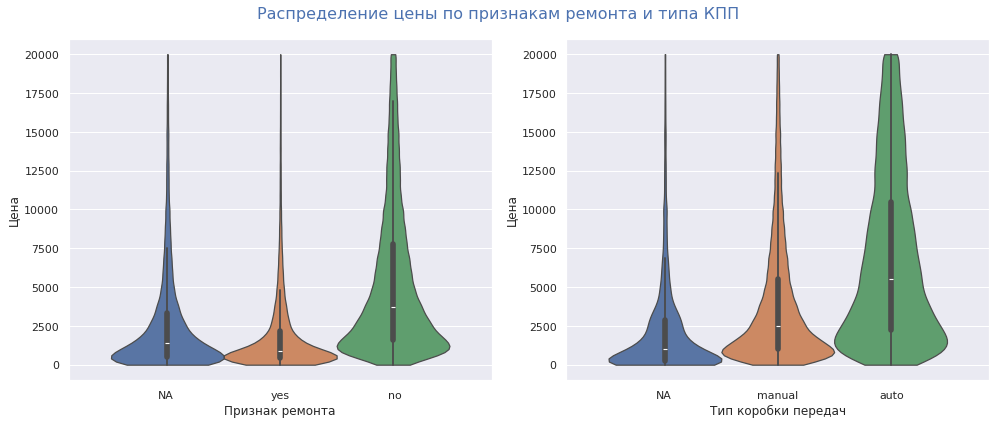

In [93]:
# swarmplot для такой выборки долго обрабатывает, использовал violinplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.violinplot(
    data, hue="repaired", y="price", hue_order=["NA", "yes", "no"], orient="v", 
    ax=ax[0], palette = sns.color_palette(n_colors=3), legend=False, cut=0
).set(xlabel="Признак ремонта", ylabel="Цена", 
      xticks=[-.27, 0, .27], xticklabels=["NA", "yes", "no"])
sns.violinplot(
    data, hue="gearbox", y="price", hue_order=["NA", "manual", "auto"], orient="v", 
    ax=ax[1], palette = sns.color_palette(n_colors=3), legend=False, cut=0
).set(xlabel="Тип коробки передач", ylabel="Цена", 
      xticks=[-.27, 0, .27], xticklabels=["NA", "manual", "auto"])
add_plot_titles(
    suptitle="Распределение цены по признакам ремонта и типа КПП", show=True)

Для признака ремонта распределение к более высоким значениям приходится на значение `no`, причем значение `NA` выступает промежуточным между значением `yes` для которого распределение сдвинуто вниз сильнее. 

Для признака типа коробки передач наименьшие цены представлены для не указанных значений `NA`, далее более высокие цены показывает признак `manual` и еще более высокие цены с типом КПП `auto`. Но во всех значениях признака имеются значения цены на всем промежутке от 0 до 20'000.

Также взглянем на распределение цены в зависимости от пробега.

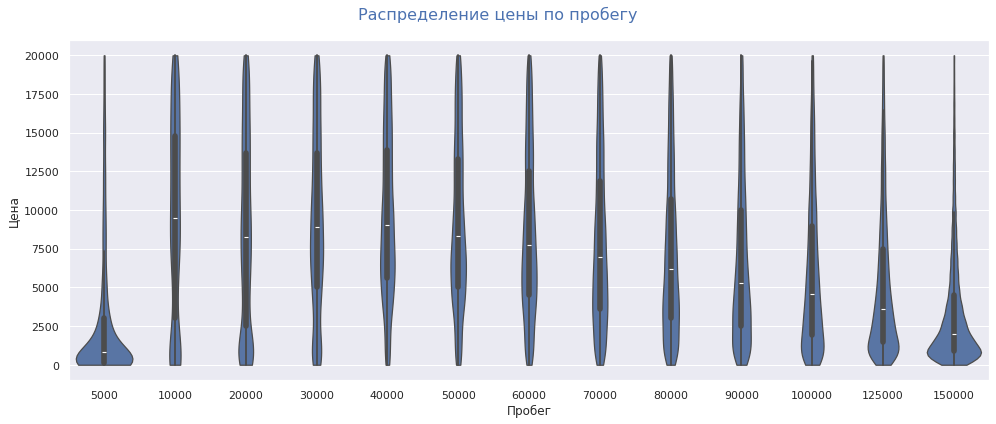

In [94]:
plt.figure(figsize=(14, 6))
sns.violinplot(
    data, x="kilometer", y="price", orient="v", cut=0
).set(xlabel="Пробег", ylabel="Цена")
add_plot_titles(
    suptitle="Распределение цены по пробегу", show=True)

Распределение цен по пробегу также заметно сдвигается в сторону более низких цен по мере роста пробега, однако для более свежих заметно увеличение количества более дешевых автомобилей для пробега 30'000 километров и меньше, а особенно для пробега 5'000 километров. Это может говорить либо о присутствии некорректно введенных значений пробега, либо о существенном влиянии других факторов. Данный признак лучше испольовать как категориальный для линейной регрессии, так как некоторые значения существенно отличаются от линейного соотношения. Рекомендацией было бы использование в качестве значения по умолчанию 150'000 километров, так как это наиболее распространенное значение, однако это не поможет исключить умышленно введенные пользователем некорректные данные.

Корреляцию для марок и моделей автомобиля не будем рассматривать, так как по данным признакам имеется большое количество значений. 

#### Мультиколлинеарность

Марка и модель автомобиля имеют крайне высокую корреляцию, так как в основном модель определяет марку, однако при анализе моделей было выявлено наличие одинаковых моделей авто для разных марок, особенно для значений модели `NA` и `other`. Если некоторые модели машинного обучения могут без проблем справиться с такими данными, то для некоторых моделей это может вносить неоднозначность. По результатам исследовательского анализа в имеющемся датасете пропуски в признаке модели авто имеются для всех марок, соответственно можно объединить эти два признака чтобы убрать неоднозначность в данных, однако это создаcт еще большую размерность признаков при кодировании One-Hot энкодером. Также имеется довольно высокая корреляция признака модели авто с признаками мощности и типа кузова. В случае наличия мультиколлинеарности или высокой корреляции между признаками, а также при большом количестве категориальных признаков в моделях линейной регрессии важно использовать L2-регуляризацию, например модель Ridge.

В части года регистрации для исключения мультиколлинеарности можно использовать только дополнительно созданные поля для линейных моделей, а на другие модели, такие как дерево решений или градиентный бустинг мультиколлинеарность не оказывает такое сильное влияние. Таким образом, для линейной регрессии можно исключить год регистрации и использовать только производные, а для других моделей оставить год регистрации и факт некорректного ввода года регистрации.

### Очистка и подготовка данных

#### Удаление неиспользуемых и избыточных признаков

Можно сразу удалить признак количества изображений, который содержал только нулевые значения. В виду создания нового признака времени активности пользователя, как разности между днем последней активности и днем регистрации, признака даты регистрации также можно удалить.

Дополнительные признаки от даты выгрузки - день и месяц также можно удалить так как имеется признак даты выгрузки, оставив только день недели для линейной модели. При этом день недели необходимо кодировать посредством One Hot энкодера как категориальный признак, так как по этому признаку отсутствует линейная зависимость, однако изменение средних цен наблюдались в течение месяца при проведении исследовательского анализа.

Также удалим сохраненные признаки со старыми значениями до преобразования, тем более новые признаки содержат факт преобразования, который может оказать дополнительное влияние на цену.

In [95]:
data.drop(columns=[
    "num_of_pict", "date_created", "month_day", "month", "pwr_old", "reg_year_old"
], inplace=True)

#### Целевой признак

При проведении исследовательского анализа данных также исследовались признаки из датасета при нулевом целевом значении. Явных аномалий не было обнаружено, распределения близки к таковым для полного датасета. Причины наличия нулевых значений точно определить затруднительно. Причем таких данных достаточно большое количество, как ранее было отмечено, есть вероятность наличия каких-либо обременений или высокой налоговой нагрузки, вследствие чего пользователи могут безвозмездно отдавать автомобили. В таком случае нулевые значения целевого признака являются значимыми и отражают реальное положение дел.

На основании вышеизложенного нулевые и околонулевые значения целевого признака не будут удалены из датасета. Однако данный вопрос лучше согласовать с Заказчиком.

#### Подготовка данных

Разобьем данные на тестовую и тренировочную выборки, для избежания проблем с отсутствием отдельных моделей авто в разных выборках будем использовать стратификацию по марке и модели авто. Перед этим необходимо определить, по всем ли моделям имеется достаточное количество записей.

In [96]:
data["brand"].str.cat(data["model"], sep=" ").value_counts().sort_values().head(5)

rover defender                   1
land_rover range_rover_evoque    2
rover discovery                  2
land_rover serie_1               2
rover freelander                 3
Name: brand, dtype: int64

Наименьшее количество записей по моделям приходится на некорректные значения для марки Rover, а также на марку Land Rover со старой моделью Series 1 и достаточно новой моделью Range Rover Evoque. Чтобы избежать проблем при стратификации данных продублируем одиночные записи.

In [97]:
data = pd.concat([data, data.query(
    "(brand == 'rover') and (model == 'defender')"
)]).reindex()
print("Новый размер датафрейма", data.shape[0])

Новый размер датафрейма 354370


Оптимизируем типы данных для снижения объема используемой памяти и произведем разделение выборки на тренировочную и тестовую.

In [98]:
print("Датасет до преобразования:")
print(data.info())
# Преобразование типов данных
for col in data.select_dtypes(include=["number"]).columns:
    data[col] = pd.to_numeric(data[col], downcast='integer')
print()
print("Датасет после преобразования:")
print(data.info())

# Разделение выборки на тренировочную и тестовую
data_train, data_test = train_test_split(
    data, random_state=RANDOM_STATE,
    stratify=data["brand"].str.cat(data["model"], sep=" ")
)
print()
print("Размеры тренировочной и тестовой выборок:")
print("Тренировочная -", data_train.shape)
print("Тестовая - ", data_test.shape)

Датасет до преобразования:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 354370 entries, 0 to 269405
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_crawled    354370 non-null  int64  
 1   price           354370 non-null  int64  
 2   vehicle_type    354370 non-null  object 
 3   reg_year        354370 non-null  int64  
 4   gearbox         354370 non-null  object 
 5   power           354370 non-null  int64  
 6   model           354370 non-null  object 
 7   kilometer       354370 non-null  int64  
 8   reg_month       354370 non-null  int64  
 9   fuel_type       354370 non-null  object 
 10  brand           354370 non-null  object 
 11  repaired        354370 non-null  object 
 12  postal_code     354370 non-null  int64  
 13  last_seen       354370 non-null  int64  
 14  region          354370 non-null  object 
 15  activity_days   354370 non-null  int64  
 16  week_day        354370 non-nu

Произведено разеделение данных на тренировочную и тестовую выборки в соотношении 75% к 25% со стратификацией по марке и модели автомобиля. 

В виду того, что произведено удаление некоторых признаков, вероятно появились дубликаты в данных. Наличие явных дубликатов в тренировочной выборке не приносят ценности для моделей обучения, оценим их наличие и избавимся от них. Разделим выборки, выделив целевой признак. 

Также очистим ранее использованные переменные для освобождения памяти для проведения обучения моделей, так как тренировочный датасет имеет достаточно большой размер.

In [99]:
# Удаление явных дубликатов в тренировочной выборке
print("Количество явных дубликатов: ", data_train.duplicated().sum())
data_train.drop_duplicates(inplace=True)
print("Размер тренировочной выборки после удаления дубликатов:", data_train.shape[0])

# Разделение выборок на целевой и остальные признаки
X_train = data_train.drop(columns="price")
y_train = data_train["price"]
X_test = data_test.drop(columns="price")
y_test = data_test["price"]

del data, data_train, data_test

Количество явных дубликатов:  3895
Размер тренировочной выборки после удаления дубликатов: 261882


Произведена очистка тренировочной выборки от явных дубликатов, а также разделение выборок на целевой и остальные признаки.

### Промежуточные выводы

Проведена загрузка данных, общее количество записей - 354'369. Имеются пропуски в 5-ти категориальных признаках - Repaired (20,1% пропусков), VehicleType (10,6% пропусков), FuelType (9,3% пропусков), Gearbox и Model (по 5,6% пропусков), остальные признаки без пропусков. Заголовки столбцов приведены к стандарту PEP8, длинные названия сокращены.

Проведен исследовательский анализ данных (EDA), по результатам которого:
1. Все пропуски в категориальных признаках заполнены значением `NA`. По моделям автомобиля выявлено несоответствие для марки `rover`, в которую входят модели марки `land_rover`.
2. Выявлены аномальные значения и выбросы по признакам мощности и года регистрации. Значения приведены к медианным по марке и модели авто. 
3. Добавлены дополнительные признаки - регион, день недели, признаки изменения некорректных значений количественных признаков.
4. По году регистрации выявлена закономернось - по мере увеличения возраста регистрации средняя стоимость автомобилей снижается в течение последних 20 лет, после чего средняя стоимость имеет тенденцию к увеличению. Также введены дополнительные признаки увеличения возраста от 20-летнего лага в разные стороны.

Проведен корреляционный анализ данных:
1. В выборке отсутствуют признаки с высокой корреляцией с целевым. Наибольшая корреляция целевого признака с годом регистрации автомобиля, особенно с новым признаком года регистрации после 20-летнего лага (с 1995 по 2015 годы) - 0,69, также имеется заметная корреляция с моделью автомобиля - 0.57. Умеренная корреляция (от 0,5 до 0,3) с признаками  мощности, ремонта, марки и пробега. Низкая корреляция (от 0,3 до 0,1) с признаком типа кузова и типа топлива, новым признаком некорректной мощности, новым признаком года с 2016 по 2019 и признаком региона. По остальным признакам корреляция очень слабая. Вявлена нелинейная зависимость целевого признака с новым признаком года регистраци после 20-летнего лага, данный признак возведен в степень 2.5, что необходимо для линейных моделей.
2. Имеется мультиколлинеарность между признаком модели автомобиля и маркой, типом кузова и мощностью. Также очень высокая корреляция признаков с прооизводными от них. В целях снижения влияния мультиколлинеарности необходимо использовать модель линейной регрессии с L2-регуляризацией (Ridge), а также исключать некоторые признаки для разных моделей.

Произведена подготовка данных: 
1. Удалены неиспользуемые, а также некоторые дополнительно добавленные либо исходные признаки на базе которых они добавлены.
2. Произведено разделение данных на тренировочную и тестовую выборку 75% к 25% со стратификацией по марке и модели автомобиля.
3. Удалены дубликаты данных в тренировочной выборке, которые не несут ценности для моделей машинного обучения, признаки разделены на целевой и остальные.

По результатам исследовательского анализа можно выдвинуть следующие **предложения**:
1. Необходимо произвести проверку используемых справочников марок и моделей автомобилей, желательно иметь справочники для каждых поколений автомобилей с годами начала и окончания их производства, а также типами кузова, используемых двигателей и типов КПП.
2. Желательно ограничить ввод информации об автомобилях с использованием справочников, чтобы пользователи могли сразу выбирать марку, модель, тип кузова, двигатель (мощность) и коробку передач.
3. Желательно ограничить ввод года регистрации в пределах сроков начала их производства для каждой модели и годом создания анкеты, по умолчанию установить наименьший год.
4. Желательно для признака пробега установить значение по умолчанию - 150'000 километров.

Модели в данном проекте будут использовать имеющиеся исходные данные без учета предложений, в случае принятия предлагаемых изменений необходима доработка моделей с их учетом.

## Обучение моделей

В настоящем проекте стоит задача регрессии и имеется датасет с большим количеством значений категориальных признаков. Наиболее применимыми будут следующие модели:

1. **Линейная регрессия с One-Hot Encoding**
Линейная регрессия может работать с категориальными признаками после их преобразования с помощью One-Hot Encoding, однако это создает высокую размерность признаков, так как признаки модели и марки автомобиля имеет большое количество значений. В связи с большим количеством категориальных признаков и наличием мультиколлинеарности будет применяться модель с L2-регуляризацией - Ridge.

2. **Дерево решений (Decision Tree Regression)**
Дерево решений хорошо работает с категориальными признаками и могут использовать их без необходимости преобразования, а только кодирования в числовые значения. Они могут обрабатывать нелинейные зависимости между признаками и целевой переменной. Применение One-Hot Encoding может не принести значительных преимуществ и, наоборот, создать избыточность.

3. **Случайный лес (Random Forest Regression)**
Случайный лес, состоящий из множества решающих деревьев, улучшает качество предсказания за счет объединения результатов многих деревьев и хорошо справляется с категориальными признаками. Однако при очень большом количестве признаков и сложных нелинейных зависимостях между признаками и целевой переменной будет очень ресурсоемким, что не подходит задачи Заказчика.

4. **Градиентный бустинг (Gradient Boosting Regression)**
Алгоритмы градиентного бустинга, такие как LightGBM и CatBoost, хорошо работают с категориальными признаками. CatBoost известен эффективностью работы с категориальными признаками без необходимости их предварительного кодирования. Обе модели основаны на дереве решений, но имеют различные подходы: 
- **LightGBM** основан на "leaf-wise" росте деревьев и гистограммных методах для оптимизации обучения, что делает его очень быстрым и эффективным для больших наборов данных, содержащих преимущественно числовые признаки. 
- **CatBoost** основан на упорядоченном бустинге и эффективной работе с категориальными признаками, модель строит симметричные деревья, где все ветви имеют одинаковую структуру, что ускоряет предсказание и делает модель более стабильной, модель лучше подходит для задач с большим количеством категорий и сложных взаимосвязей данных.

5. **Регрессия на основе K ближайших соседей (K-Nearest Neighbors Regression)**
Этот метод может быть использован с категориальными признаками после их кодирования. Однако, KNN может быть менее эффективен из-за высокой вычислительной сложности, так как имеется большое количество категориальных признаков и большой датасет.

Воспользуемся моделями, которые являются менее затратными в использовании вычислительных ресурсов, так как применение Random Forest и kNN Regression будет неоправданно ресурсоемким для имеющегося датасета и не подходят под требования Заказчика.

In [100]:
# Переменная для сохранения результатов
# Для большего удобства вынес в отдельную ячейку
# и вместо списка сделал ее сразу датафреймом
model_result = pd.DataFrame()

### Линейная регрессия

Для линейной регрессии все категориальные признаки, а также некоторые числовые преобразуем посредством One-Hot Encoder, Ordinal Encoder будет не лучшим решением в виду отсутствия линейной зависимости в большинстве таких признаков. Числовые признаки закодируем через MinMaxScaler, так как важно сохранить нулевые значения. Остальные признаки оставим без изменений, однако в виду избыточности исключим поле года регистрации, а также для недопущения чрезмерного увеличения размерности признаков исключим признак почтового кода.

Подготовим пайплайн для преобразования и функцию для подбора параметров посредством библиотеки Optuna.

In [101]:
# Признаки для OHE кодирования
lr_ohe_cols = ["brand", "model", "vehicle_type", "fuel_type", "gearbox", 
               "repaired", "reg_month", "kilometer", "region", "week_day"]
# Признаки для MinMaxScaler
lr_num_cols = ["power", "reg_year_over", "reg_year_less", "date_crawled", 
               "last_seen", "activity_days"]
# Признаки для удаления
lr_drop_cols = ["reg_year", "postal_code"]

# Препроцессор
lr_prep = ColumnTransformer(transformers=[
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="NA")),
        ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"))
    ]), lr_ohe_cols),
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler())
    ]), lr_num_cols)
], remainder="passthrough", force_int_remainder_cols=False)

# Функция для оптимизации гиперпараметров линейной регрессии (Ridge)
def lr_optimize(trial):
    alpha = trial.suggest_float("alpha", 0.15, 0.2, log=True)
    pipeline = Pipeline([
        ("preprocessor", lr_prep),
        ("model", Ridge(alpha=alpha, random_state=RANDOM_STATE))
    ])
    return -cross_val_score(
        pipeline, X_train.drop(columns=lr_drop_cols), y_train, 
        cv=5, n_jobs=-1, scoring=SCORING
    ).mean()

Произведем поиск лучших гиперпараметров модели линейной регрессии для данного датасета.

In [102]:
%%time

gc.collect()
if STUDY: # Проведение поиска гиперпараметров (около 25 минут)
    lr_study = optuna.create_study(
        direction="minimize", study_name="Ridge", 
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
    )
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        lr_study.optimize(lr_optimize, n_trials=8, show_progress_bar=True)
else: # Подставление гиперпараметров и результатов кросс-валидации
    lr_study = MyStudy()
    lr_study.best_params = {
        "alpha": 0.19718428652820272
    }
    lr_study.best_value = 2253.605570178281
print()
print(f"Лучшие параметры линейной регрессии (Ridge): {lr_study.best_params}")
print(f"Среднее значение RMSE при кросс-валидации: {lr_study.best_value}")
print()

[I 2024-09-02 08:59:22,949] A new study created in memory with name: Ridge


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-09-02 09:02:30,117] Trial 0 finished with value: 2253.612890895756 and parameters: {'alpha': 0.16706513590008543}. Best is trial 0 with value: 2253.612890895756.
[I 2024-09-02 09:05:34,693] Trial 1 finished with value: 2253.605570178281 and parameters: {'alpha': 0.19718428652820272}. Best is trial 1 with value: 2253.605570178281.
[I 2024-09-02 09:08:41,904] Trial 2 finished with value: 2253.6081957520364 and parameters: {'alpha': 0.1851593541881612}. Best is trial 1 with value: 2253.605570178281.
[I 2024-09-02 09:11:40,490] Trial 3 finished with value: 2253.612884458434 and parameters: {'alpha': 0.17819146308517586}. Best is trial 1 with value: 2253.605570178281.
[I 2024-09-02 09:14:29,179] Trial 4 finished with value: 2253.6096439843436 and parameters: {'alpha': 0.15688594241816448}. Best is trial 1 with value: 2253.605570178281.
[I 2024-09-02 09:17:15,912] Trial 5 finished with value: 2253.6118677880027 and parameters: {'alpha': 0.15688485380260064}. Best is trial 1 with valu

Произведем обучение модели линейной регрессии с L2-регуляризацией (Ridge) на тренировочных данных с использованием подобранного гиперпараметра alpha. Замерим время обучения и предсказания модели на тренировочных данных.

In [103]:
# Сохранение результатов
model_result.loc["Ridge", "file"] = "models/lr_pipe.pkl"
model_result.loc["Ridge", "cross_val_rmse"] = lr_study.best_value    


# Пайплайн для линейной регрессии
lr_pipe = Pipeline([
    ("preprocessor", lr_prep),
    ("model", Ridge(alpha=lr_study.best_params["alpha"], random_state=RANDOM_STATE))
])

# Очистка памяти сборщиком мусора перед обучением
del lr_prep, lr_study
gc.collect()

# Запуск обучения модели
pb = tqdm(total=2, desc="Обучение модели")
run_time = time.time()
lr_pipe.fit(X_train.drop(columns=lr_drop_cols), y_train)
run_time = time.time() - run_time
pb.update(1)
print(f"Время обучения модели: {run_time:.1f} секунд")
model_result.loc["Ridge", "learn_time"] = run_time

# Запуск предсказания модели
pb.set_description("Предсказание модели")
run_time = time.time()
lr_pipe.predict(X_train.drop(columns=lr_drop_cols))
run_time = time.time() - run_time
pb.update(1)
print(f"Время предсказания модели: {run_time:.1f} секунд")
model_result.loc["Ridge", "predict_time"] = run_time

Обучение модели:   0%|          | 0/2 [00:00<?, ?it/s]

Время обучения модели: 40.8 секунд
Время предсказания модели: 1.2 секунд


Произведено обучение модели, сохраним дамп модели в файл и освободим переменные для дальнейшей работы.

In [104]:
# Сохранение модели в файл и очистка переменных
os.makedirs("models", exist_ok=True) # создание директории, если её ещё нет
with open("models/lr_pipe.pkl", "wb") as fd:
    joblib.dump(lr_pipe, fd) # сохранине дампа пайплайна Ridge

# Удаление переменных
del lr_pipe

### Дерево решений

Для модели дерева решений кодирование категориальных признаков будем производить посредством Ordinal Encoder в порядке увеличения средней цены автомобилей, который был выявлен при проведении EDA. Для деревьев решений не требуется кодировать числовые признаки. Дерево решений гораздо лучше находит нелинейные закономерности в отличие от линейной модели, а использование OneHot Encoder может достаточно сильно сказаться на скорости работы. Также исключим избыточные признаки региона и дополнительные признаки года регистрации от 20-летнего лага, так как эти поля имели смысл только для линейной модели.

In [105]:
# Признаки для Ordinal кодирования
dt_ord_cols = ["brand", "model", "vehicle_type", "fuel_type", "gearbox", "repaired"]
dt_ord_cats = [brand_order[::-1], model_order[::-1], vehicle_type_order[::-1], 
               fuel_type_order[::-1], gearbox_order[::-1], repaired_order[::-1]]
# Признаки для MinMaxScaler
dt_num_cols = ["power", "reg_year", "date_crawled", "last_seen", "activity_days", 
               "reg_month", "kilometer", "postal_code"]
# Признаки для исключения
dt_drop_cols = ["region", "reg_year_over", "reg_year_less"]

# Препроцессор
dt_prep = ColumnTransformer(transformers=[
    ("ord", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="NA")),
        ("ord", OrdinalEncoder(
            categories=dt_ord_cats, handle_unknown="use_encoded_value",
            unknown_value=-1
        ))
    ]), dt_ord_cols),
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median"))
    ]), dt_num_cols)
], remainder="passthrough", force_int_remainder_cols=False)

# Функция для оптимизации гиперпараметров дерева решений
def dt_optimize(trial):
    max_depth = trial.suggest_int("max_depth", 15, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 15, 20)
    pipeline = Pipeline([
        ("preprocessor", dt_prep),
        ("model",  DecisionTreeRegressor(
            max_depth=max_depth, 
            min_samples_split=min_samples_split, 
            min_samples_leaf=min_samples_leaf, 
            random_state=RANDOM_STATE)
        )
    ])
    return -cross_val_score(
        pipeline, X_train.drop(columns=dt_drop_cols), y_train, 
        cv=5, n_jobs=-1, scoring=SCORING
    ).mean()

Произведем поиск лучших гиперпараметров для модели дерева решений с применением библиотеки Optuna и кросс-валидацией по метрике RMSE.

In [106]:
%%time

gc.collect()
if STUDY: # Проведение поиска гиперпараметров (минут 30)
    dt_study = optuna.create_study(
        direction="minimize", study_name="DecisionTree", 
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
    )
    dt_study.optimize(dt_optimize, n_trials=16, show_progress_bar=True)
else: # Подставление гиперпараметров и результатов кросс-валидации
    dt_study = MyStudy()
    dt_study.best_params = {
        "max_depth": 16, 
        "min_samples_split": 4, 
        "min_samples_leaf": 19
    }
    dt_study.best_value = 2021.5433349815871
print()
print(f"Лучшие параметры дерева решений: {dt_study.best_params}")
print(f"Среднее значение RMSE при кросс-валидации: {dt_study.best_value}")
print()

[I 2024-09-02 09:23:32,956] A new study created in memory with name: DecisionTree


  0%|          | 0/16 [00:00<?, ?it/s]

[I 2024-09-02 09:23:44,724] Trial 0 finished with value: 2021.7587728535304 and parameters: {'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 19}. Best is trial 0 with value: 2021.7587728535304.
[I 2024-09-02 09:23:57,089] Trial 1 finished with value: 2031.4321902445859 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 15}. Best is trial 0 with value: 2021.7587728535304.
[I 2024-09-02 09:24:08,438] Trial 2 finished with value: 2023.7714895251356 and parameters: {'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 18}. Best is trial 0 with value: 2021.7587728535304.
[I 2024-09-02 09:24:21,347] Trial 3 finished with value: 2023.2788999653185 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 20}. Best is trial 0 with value: 2021.7587728535304.
[I 2024-09-02 09:24:33,529] Trial 4 finished with value: 2030.4494273447315 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 16}. Best is trial

Найдены лучшие параметры для дерева решений при кросс-валидации с метрикой RMSE, произведем обучение модели.

In [107]:
# Сохранение результатов
model_result.loc["DecisionTree", "file"] = "models/dt_pipe.pkl"
model_result.loc["DecisionTree", "cross_val_rmse"] = dt_study.best_value 

# Пайплайн дерева решений
dt_pipe = Pipeline([
    ("preprocessor", dt_prep),
    ("model",  DecisionTreeRegressor(
        max_depth=dt_study.best_params["max_depth"], 
        min_samples_split=dt_study.best_params["min_samples_split"], 
        min_samples_leaf=dt_study.best_params["min_samples_leaf"], 
        random_state=RANDOM_STATE)
    )
])

# Очистка памяти сборщиком мусора перед обучением
del dt_study
gc.collect()

# Запуск обучения модели
pb = tqdm(total=2, desc="Обучение модели")
run_time = time.time()
dt_pipe.fit(X_train.drop(columns=dt_drop_cols), y_train)
run_time = time.time() - run_time
pb.update(1)
print(f"Время обучения модели: {run_time:.1f} секунд")
model_result.loc["DecisionTree", "learn_time"] = run_time

# Запуск предсказания модели
pb.set_description("Предсказание модели")
run_time = time.time()
dt_pipe.predict(X_train.drop(columns=dt_drop_cols))
run_time = time.time() - run_time
pb.update(1)
print(f"Время предсказания модели: {run_time:.1f} секунд")
model_result.loc["DecisionTree", "predict_time"] = run_time

Обучение модели:   0%|          | 0/2 [00:00<?, ?it/s]

Время обучения модели: 2.8 секунд
Время предсказания модели: 0.8 секунд


Сохраним дамп в файл и очистим переменные

In [108]:
# Сохранение модели в файл и очистка переменных
os.makedirs('models', exist_ok=True) # создание директории, если её ещё нет
with open("models/dt_pipe.pkl", "wb") as fd:
    joblib.dump(dt_pipe, fd) # сохранение дампа пайплайна

# Удаление переменных
del dt_pipe

### LightGBM

Для модели LightGBM воспользуемся препроцессором и признаками, которые были использованы для дерева решений.

In [109]:
# Функция для оптимизации гиперпараметров LightGBM посредством Optuna
def lgb_optimize(trial):
    #num_leaves = trial.suggest_categorical("num_leaves", [127, 255, 511, 1023])
    num_leaves = trial.suggest_categorical("num_leaves", [255]) 
    #learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, step=0.01)
    learning_rate = trial.suggest_float("learning_rate", 0.03, 0.03) 
    #n_estimators = trial.suggest_int("n_estimators", 500, 5000, step=100)
    n_estimators = trial.suggest_int("n_estimators", 1000, 1000)
    
    pipeline = Pipeline([
        ('preprocessor', dt_prep),
        ('model', lgb.LGBMRegressor(
            num_leaves=num_leaves, 
            learning_rate=learning_rate, 
            n_estimators=n_estimators, 
            random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1))
    ])
    pipeline["model"].set_params(**{"categorical_feature":list(range(6))})
    return -cross_val_score(
        pipeline, X_train.drop(columns=dt_drop_cols), y_train, 
        cv=5, n_jobs=-1, scoring=SCORING).mean()

Произведем поиск лучших гиперпараметров для модели LightGBM:

In [110]:
%%time

if STUDY: # Проведение поиска гиперпараметров (минут 30)
    gc.collect()
    lgb_study = optuna.create_study(
        direction="minimize", study_name="LightGBM", 
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        lgb_study.optimize(lgb_optimize, n_trials=1, n_jobs=-1, show_progress_bar=True)
else: # Подставление гиперпараметров и результатов кросс-валидации
    lgb_study = MyStudy()
    lgb_study.best_params = {
        "num_leaves": 255,
        "learning_rate": 0.03,
        "n_estimators": 1000
    }
    lgb_study.best_value = 1668.4571883749
print()
print(f"Лучшие параметры LightGBM: {lgb_study.best_params}")
print(f"Среднее значение RMSE при кросс-валидации: {lgb_study.best_value}")
print()

[I 2024-09-02 09:26:46,002] A new study created in memory with name: LightGBM


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-09-02 10:03:32,889] Trial 0 finished with value: 1668.4571883749 and parameters: {'num_leaves': 255, 'learning_rate': 0.03, 'n_estimators': 1000}. Best is trial 0 with value: 1668.4571883749.

Лучшие параметры LightGBM: {'num_leaves': 255, 'learning_rate': 0.03, 'n_estimators': 1000}
Среднее значение RMSE при кросс-валидации: 1668.4571883749

CPU times: user 36min 12s, sys: 14.5 s, total: 36min 26s
Wall time: 36min 47s


Завершен поиск лучших параметров, произведем обучение модели LightGBM.

In [111]:
# Сохранение результатов
model_result.loc["LightGBM", "file"] = "models/lgb_pipe.pkl"
model_result.loc["LightGBM", "cross_val_rmse"] = lgb_study.best_value 

# Подготовка модели
lgb_pipe = Pipeline([
    ("preprocessor", dt_prep),
    ("model",  lgb.LGBMRegressor(
        num_leaves=lgb_study.best_params["num_leaves"], 
        learning_rate=lgb_study.best_params["learning_rate"], 
        n_estimators=lgb_study.best_params["n_estimators"],
        random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1)
    )
])
lgb_pipe["model"].set_params(**{"categorical_feature":list(range(6))})

# Удаление переменных и очистка
del lgb_study
gc.collect()

# Обучение модели
pb = tqdm(total=2, desc="Обучение модели")
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    run_time = time.time()
    lgb_pipe.fit(X_train.drop(columns=dt_drop_cols), y_train)
    run_time = time.time() - run_time
pb.update(1)
print(f"Время обучения модели: {run_time:.1f} секунд")
model_result.loc["LightGBM", "learn_time"] = run_time

# Запуск предсказания модели
pb.set_description("Предсказание модели")
run_time = time.time()
lgb_pipe.predict(X_train.drop(columns=dt_drop_cols))
run_time = time.time() - run_time
pb.update(1)
print(f"Время предсказания модели: {run_time:.1f} секунд")
model_result.loc["LightGBM", "predict_time"] = run_time

Обучение модели:   0%|          | 0/2 [00:00<?, ?it/s]

Время обучения модели: 528.7 секунд
Время предсказания модели: 78.6 секунд


Сохраним модель и удалим переменные.

In [112]:
# Сохранение модели в файл и очистка переменных
os.makedirs('models', exist_ok=True) # создание директории, если её ещё нет
with open("models/lgb_pipe.pkl", "wb") as fd:
    joblib.dump(lgb_pipe, fd) # сохранение дампа пайплайна

# Удаление переменных
del lgb_pipe

### CatBoost

Для CatBoost нет необходимости кодировать признаки. Передадим в модель признаки как есть, удалив избыточные, а также укажем какие столбцы являются категориальными признаками.

In [113]:
# Препроцессор для CatBoost
cb_prep = ColumnTransformer(transformers=[
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="NA"))
    ]), dt_ord_cols),
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median"))
    ]), dt_num_cols)
], remainder="passthrough", force_int_remainder_cols=False)

# CatBoost
def cb_optimize(trial):
    # Не стал менять количество итераций, рост показателей не такой существенный, 
    # а время рассчета очень сильно увеличивается
    #depth = trial.suggest_int('depth', 6, 15)
    depth = trial.suggest_int('depth', 12, 12) 
    #learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01)
    learning_rate = trial.suggest_float('learning_rate', 0.07, 0.07) 
    
    pipeline = Pipeline([
        ('preprocessor', cb_prep),
        ('model', cb.CatBoostRegressor(
            cat_features=list(range(6)),
            depth=depth, 
            learning_rate=learning_rate, 
            early_stopping_rounds=10,
            thread_count=-1, verbose=0,
            random_seed=RANDOM_STATE)
        )
    ])
    
    return -cross_val_score(
        pipeline, X_train.drop(columns=dt_drop_cols), y_train, 
        cv=5, scoring=SCORING, n_jobs=-1).mean()

Проведем подбор гиперпараметров для модели CatBoost

In [114]:
%%time

if STUDY: # Проведение поиска гиперпараметров (чуть больше часа)
    gc.collect()
    cb_study = optuna.create_study(
        direction="minimize", study_name="CatBoost", 
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cb_study.optimize(cb_optimize, n_trials=1, n_jobs=-1, show_progress_bar=True)
else: # Подставление гиперпараметров и результатов кросс-валидации
    cb_study = MyStudy()
    cb_study.best_params = {
        "depth": 12,
        "learning_rate": 0.07
    }
    cb_study.best_value = 1687.666306089333
print()
print(f"Лучшие параметры CatBoost: {cb_study.best_params}")
print(f"Среднее значение RMSE при кросс-валидации: {cb_study.best_value}")
print()

[I 2024-09-02 10:13:43,906] A new study created in memory with name: CatBoost


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-09-02 11:20:49,067] Trial 0 finished with value: 1687.666306089333 and parameters: {'depth': 12, 'learning_rate': 0.07}. Best is trial 0 with value: 1687.666306089333.

Лучшие параметры CatBoost: {'depth': 12, 'learning_rate': 0.07}
Среднее значение RMSE при кросс-валидации: 1687.666306089333

CPU times: user 1h 6min 34s, sys: 22.9 s, total: 1h 6min 57s
Wall time: 1h 7min 5s


Проведем обучение модели на всем тренировочном датасете и оценим время.

In [115]:
# Сохранение результатов
model_result.loc["CatBoost", "file"] = "models/cb_pipe.pkl"
model_result.loc["CatBoost", "cross_val_rmse"] = cb_study.best_value 

# Подготовка модели
сb_pipe = Pipeline([
    ("preprocessor", cb_prep),
    ("model",  cb.CatBoostRegressor(
        cat_features=list(range(6)),
        depth=cb_study.best_params["depth"], 
        learning_rate=cb_study.best_params["learning_rate"], 
        #early_stopping_rounds=10,
        thread_count=-1, verbose=0,
        random_seed=RANDOM_STATE)
    )
])

# Удаление переменных и очистка
del cb_study
gc.collect()

# Обучение модели
pb = tqdm(total=2, desc="Обучение модели")
run_time = time.time()
сb_pipe.fit(X_train.drop(columns=dt_drop_cols), y_train)
run_time = time.time() - run_time
pb.update(1)
print(f"Время обучения модели: {run_time:.1f} секунд")
model_result.loc["CatBoost", "learn_time"] = run_time

# Запуск предсказания модели
pb.set_description("Предсказание модели")
run_time = time.time()
сb_pipe.predict(X_train.drop(columns=dt_drop_cols))
run_time = time.time() - run_time
pb.update(1)
print(f"Время предсказания модели: {run_time:.1f} секунд")
model_result.loc["CatBoost", "predict_time"] = run_time

Обучение модели:   0%|          | 0/2 [00:00<?, ?it/s]

Время обучения модели: 1006.8 секунд
Время предсказания модели: 5.7 секунд


Сохраним модель и удалим переменные

In [116]:
# Сохранение модели в файл и очистка переменных
os.makedirs('models', exist_ok=True) # создание директории, если её ещё нет
with open("models/cb_pipe.pkl", "wb") as fd:
    joblib.dump(сb_pipe, fd) # сохранение дампа пайплайна CatBoost

# Удаление переменных
del сb_pipe

### Промежуточные выводы

Произведен подбор гиперпараметров и обучение следующих моделей машинного обучения:
1. Линейная регрессия с L2 регуляризацией (Ridge) с гиперпараметром `alpha=0.197`. По результатам кросс-валидации на тренировочном датасете модель показала среднюю метрику RMSE равную `2253.61`.
2. Дерево решений (Decision Tree Regressor) с гиперпараметрами `max_depth=16`, `min_samples_split=4`, `min_samples_leaf=19`. Лучшее значение RMSE при кросс-валидации: `2021.54`.
3. Light Gradient Boosting Machine (LightGBM) с гиперпараметрами `num_leaves=255`, `learning_rate=0.03`, `n_estimators=1000`. Лучшее значение RMSE при кросс-валидации: `1668.46`.
4. Categorical Boosting (CatBoost) с гиперпараметрами `depth=12`, `learning_rate=0.07`. Лучшее значение RMSE при кросс-валидации: `1687.67`.

## Анализ моделей

Оценим результаты обучения и предсказания моделей на тренировочных данных.

In [117]:
fmt = {}
for col in model_result.columns:
    if pd.api.types.is_float_dtype(model_result[col]):
        fmt[col] = "{:,.2f}"
model_result.style.background_gradient(
    cmap=sns.diverging_palette(250, 25, as_cmap=True), 
    subset=list(fmt.keys())
).format(fmt)

**Метрики** на тренировочном датасете проходят под ограничение задачи - RMSE менее 2500 для всех моделей. Наилучшие результаты у модели LightGBM - `1687.67`, чуть хуже результаты у модели CatBoost - `1668.46`, значительно ниже результаты у дерева решений - `2021.54`, а самые плохие результаты у модели линейной регрессии - `2253.61`.

**Время обучения** моделей распределилось следующим образом: наиболее быстро обучается модель дерева решения `Decision Tree`, гораздо дольше происходит обучение линейной модели `Ridge`, далее с почти десятикратным отрывом от предыдущей идет модель `LightGBM` и на последнем месте, почти с трехкратным отрывом от предыдущей модели располагается `CatBoost`.

**Время предсказания** моделей распределилось немного по другому: также наиболее высокие результаты у модели дерева решений `Decision Tree` и линейной регрессии `Ridge`, однако модель `CatBoost` показывает существенно лучшее время предсказания в отличие от модели `LightGBM`, которая отстает от нее более чем на порядок.

Для различных вариантов использования можно выделить 3 наилучшие модели:
1. **CatBoost** - наиболее оптимальный вариант, если имеются достаточно высокие требования по точности прогнозирования, при этом обучение производится не часто, а предсказания достаточно часто. Эта модель будет наиболее применима в случаях, если предсказание будут выводиться при каждом просмотре объявлений для всех клиентов, а обучение на новых данных будет производиться с определенной периодичностью.
2. **LightGBM** - данный вариант будет лучше, если требования к точности прогнозирования самые высокие, при этом ниже требования к времени предсказания. Например, если предсказания выводятся только при создании анкет, чтобы клиент, который создает анкету видел оценочную стоимость. Обучение на новых данных можно сделать более частым.
3. **DecisionTree** - лучший вариант по времени обучения и предсказания, но применим только если точность прогнозирования достаточная для задачи, при этом очень высокие требования к времени обучения и предсказания, например в высоконагруженных проектах.

Оценим результаты предсказаний на тестовой выборке по каждой из предлагаемых моделей.

In [118]:
# Переменная для сохранения результатов предсказаний
predict_result = y_test.copy().to_frame()

### Модель CatBoost

Произведем предсказание модели на тестовой выборке.

In [119]:
with open("models/cb_pipe.pkl", "rb") as fd:
    pipe = joblib.load(fd)
predict_result["CatBoost"] = pipe.predict(X_test.drop(columns=dt_drop_cols))
model_result.loc["CatBoost", "test_rmse"] = root_mean_squared_error(
    predict_result["price"], predict_result["CatBoost"]
)

Оценим распределение остатков модели.

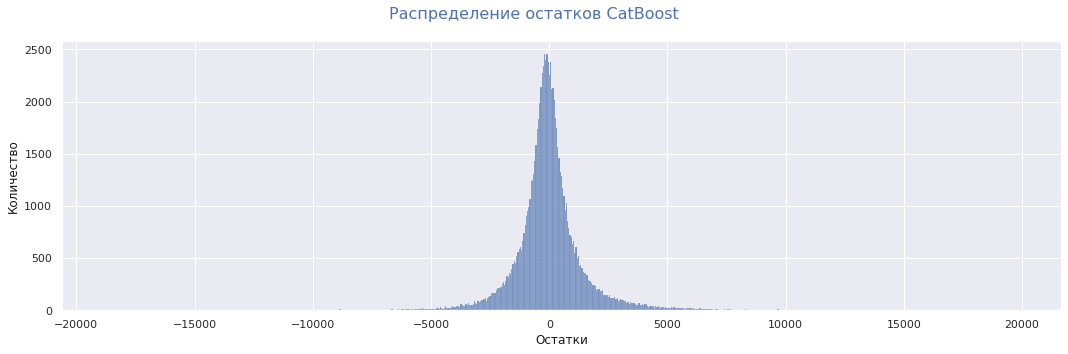

In [120]:
plt.figure(figsize=(15, 5))
sns.histplot(data=(predict_result["price"] - predict_result["CatBoost"]))
add_plot_titles(suptitle="Распределение остатков CatBoost", show=True,
               xlabel="Остатки", ylabel="Количество")

Остатки модели немного сдвинуты в отрицательные значения. Оценим дисперсию остатков.

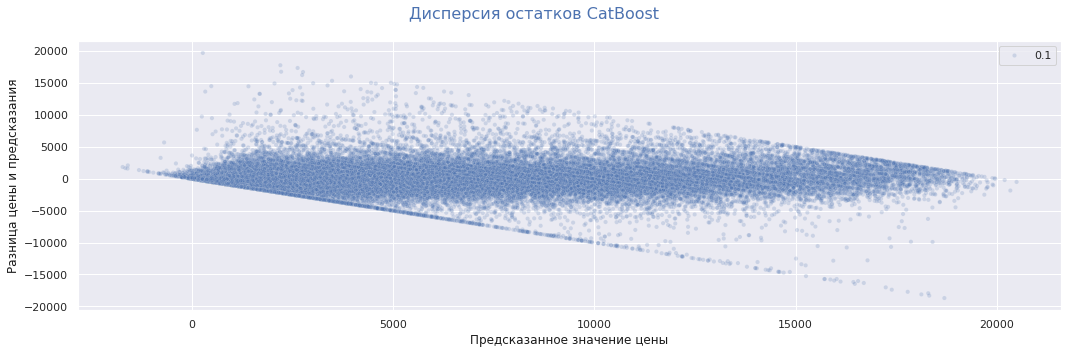

In [121]:
plt.figure(figsize=(15, 5))
sns.scatterplot(
    x=predict_result["CatBoost"], y=(predict_result["price"] - predict_result["CatBoost"]),
    size=.1, alpha=0.2
)
add_plot_titles(suptitle="Дисперсия остатков CatBoost", show=True,
               xlabel="Предсказанное значение цены", ylabel="Разница цены и предсказания")
show_describe(predict_result["CatBoost"], normal_test=False)

Предсказания модели CatBoost имеют небольшое количество отрицательных значений, а некоторые предсказания превышают 20'000. Ограничим отрицательные предсказания нулевым значением и оценим RMSE после этого.

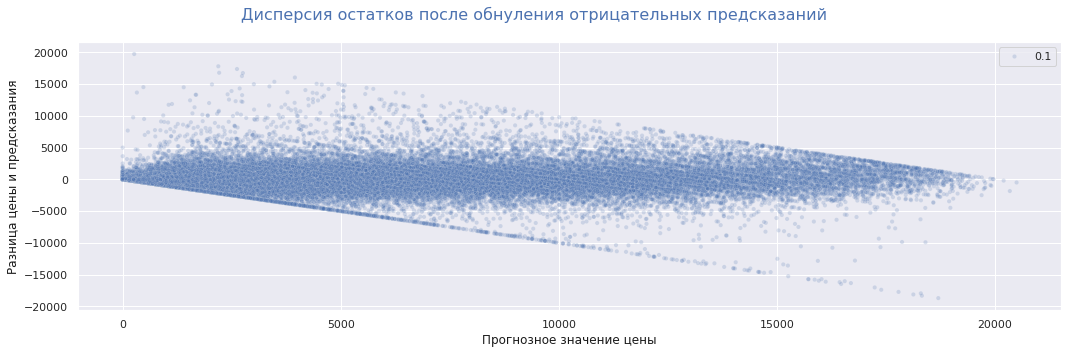

Новая метрика RMSE: 1,660.91


In [122]:
predict_result["CatBoost_limit"] = predict_result["CatBoost"]
predict_result.loc[predict_result["CatBoost"] < 0, "CatBoost_limit"] = 0
plt.figure(figsize=(15, 5))
sns.scatterplot(
    x=predict_result["CatBoost_limit"], y=(predict_result["price"] - predict_result["CatBoost_limit"]),
    size=.1, alpha=0.2
)
add_plot_titles(suptitle="Дисперсия остатков после обнуления отрицательных предсказаний", 
                show=True, xlabel="Прогнозное значение цены", ylabel="Разница цены и предсказания")
model_result.loc["CatBoost","limit_rmse"] = root_mean_squared_error(
    predict_result["price"], predict_result["CatBoost_limit"]
)
print(f"Новая метрика RMSE: {model_result.loc['CatBoost','limit_rmse']:,.2f}")

### Модель LightGBM

Произведем предсказание модели на тестовой выборке.

In [123]:
with open("models/lgb_pipe.pkl", "rb") as fd:
    pipe = joblib.load(fd)
predict_result["LightGBM"] = pipe.predict(X_test.drop(columns=dt_drop_cols))
model_result.loc["LightGBM", "test_rmse"] = root_mean_squared_error(
    predict_result["price"], predict_result["LightGBM"]
)

Оценим распределение остатков модели.

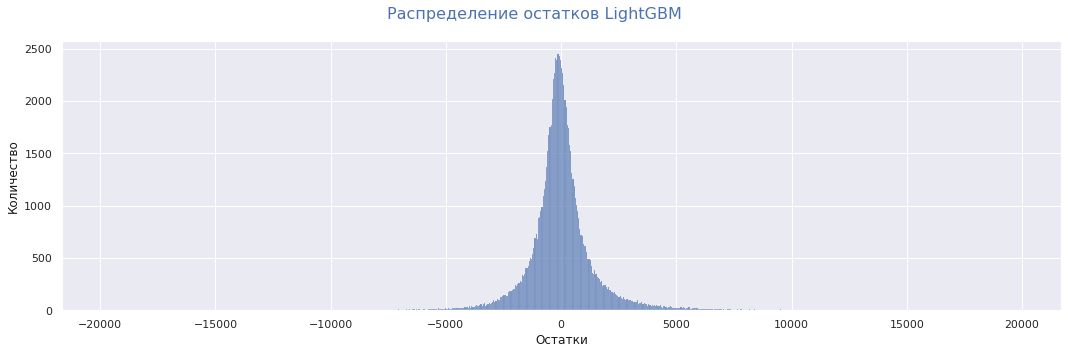

In [124]:
plt.figure(figsize=(15, 5))
sns.histplot(data=(predict_result["price"] - predict_result["LightGBM"]))
add_plot_titles(suptitle="Распределение остатков LightGBM", show=True,
               xlabel="Остатки", ylabel="Количество")

Значения остатков более сконцентрированы вблизи нулевых значений, но также имеют небольшой сдвиг к отрицательным значениям.

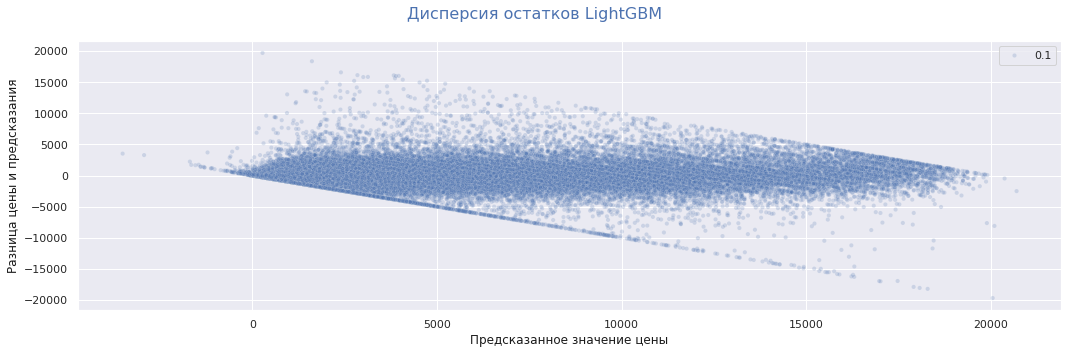

In [125]:
plt.figure(figsize=(15, 5))
sns.scatterplot(
    x=predict_result["LightGBM"], y=(predict_result["price"] - predict_result["LightGBM"]),
    size=.1, alpha=0.2
)
add_plot_titles(suptitle="Дисперсия остатков LightGBM", show=True,
               xlabel="Предсказанное значение цены", ylabel="Разница цены и предсказания")
show_describe(predict_result["LightGBM"], normal_test=False)

Предсказания модели LightGBM имеют отрицательные значения, а также значения выше 20'000. Отрицательных предсказаний также немного, однако имеются более низкие значения. Обнулим отрицательные значения и оценим метрику RMSE.

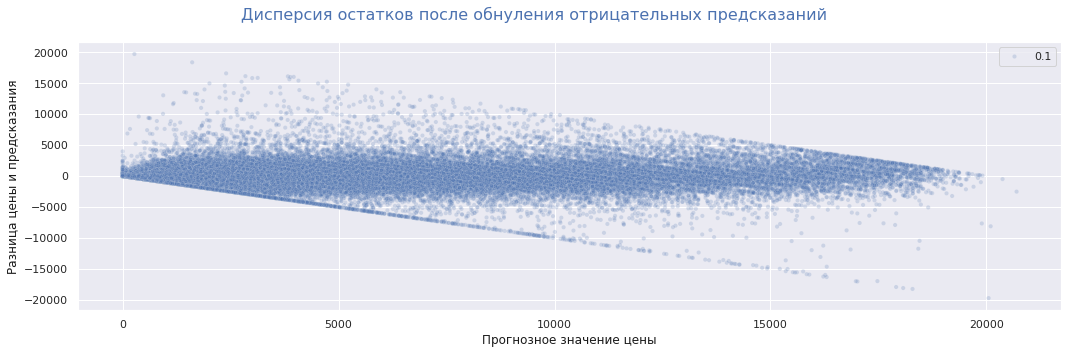

Новая метрика RMSE: 1,636.35


In [126]:
predict_result["LightGBM_limit"] = predict_result["LightGBM"]
predict_result.loc[predict_result["LightGBM"] < 0, "LightGBM_limit"] = 0
plt.figure(figsize=(15, 5))
sns.scatterplot(
    x=predict_result["LightGBM_limit"], y=(predict_result["price"] - predict_result["LightGBM_limit"]),
    size=.1, alpha=0.2
)
add_plot_titles(suptitle="Дисперсия остатков после обнуления отрицательных предсказаний", 
                show=True, xlabel="Прогнозное значение цены", ylabel="Разница цены и предсказания")
model_result.loc["LightGBM","limit_rmse"] = root_mean_squared_error(
    predict_result["price"], predict_result["LightGBM_limit"]
)
print(f"Новая метрика RMSE: {model_result.loc['LightGBM','limit_rmse']:,.2f}")

Обнуление отрицательных значений улучило метрику до 2'214.93, однако значение не превзошло результаты модели дерева решений.

### Модель дерево решений

Произведем предсказание модели на тестовой выборке.

In [127]:
with open("models/dt_pipe.pkl", "rb") as fd:
    pipe = joblib.load(fd)
predict_result["DecisionTree"] = pipe.predict(X_test.drop(columns=dt_drop_cols))
model_result.loc["DecisionTree", "test_rmse"] = root_mean_squared_error(
    predict_result["price"], predict_result["DecisionTree"]
)

Оценим распределение остатков модели.

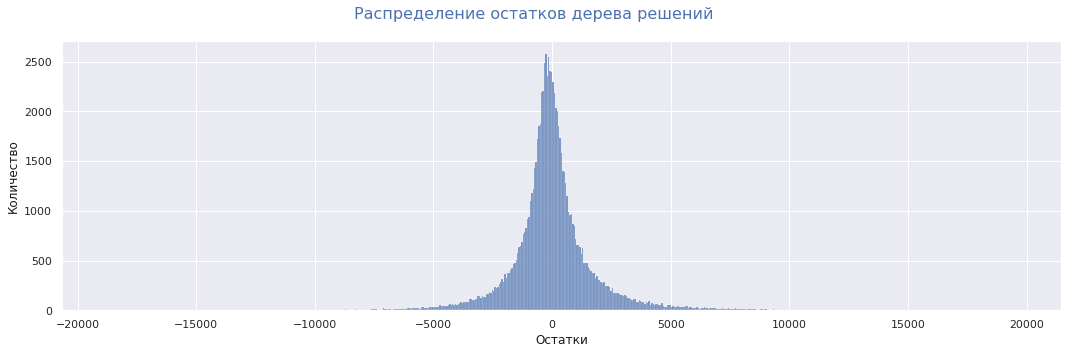

In [128]:
plt.figure(figsize=(15, 5))
sns.histplot(data=(predict_result["price"] - predict_result["DecisionTree"]))
add_plot_titles(suptitle="Распределение остатков дерева решений", show=True,
               xlabel="Остатки", ylabel="Количество")

По модели дерева решений заметно более плотное сосредоточение возле реальных значений и с меньшим разбросом по сравнению с прошлой моделью. Однако заметно большее смещение значений в сторону завышенных цен, хотя заниженные также имеют более пологое распределение, как и в предыдущей модели. Оценим дисперсию остатков.

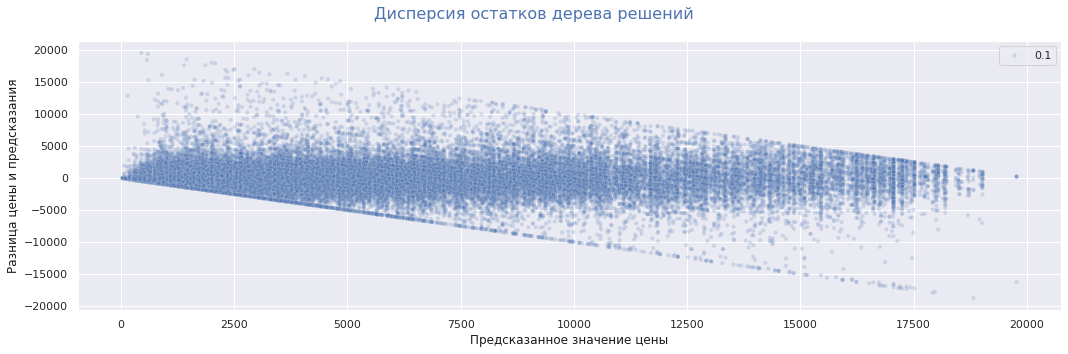

In [129]:
plt.figure(figsize=(15, 5))
sns.scatterplot(
    x=predict_result["DecisionTree"], y=(predict_result["price"] - predict_result["DecisionTree"]),
    size=.1, alpha=0.2
)
add_plot_titles(suptitle="Дисперсия остатков дерева решений", show=True,
               xlabel="Предсказанное значение цены", ylabel="Разница цены и предсказания")
show_describe(predict_result["DecisionTree"], normal_test=False)

По модели дерева решений дисперсия остатков более равномерная по всем значениям предсказаний. В целом понятны причины несимметричности гистограммы распределения остатков и большей концентрацией к околонулевым значениям в отрицательной части гистограммы - это вызвано наличием нижнего порога значений целевого признака и достаточно большой концентрацией значений в нижних пределах. Отрицательные значения, а также значения выше 20'000 осутствуют.

Метрика RMSE после обнуления отрицательных значений улучшилась несущественно.

Значение метрики улучшилось до 1'660.91

### Промежуточные выводы

In [130]:
fmt = {}
for col in model_result.columns:
    if pd.api.types.is_float_dtype(model_result[col]):
        fmt[col] = "{:,.2f}"
model_result.style.background_gradient(
    cmap=sns.diverging_palette(250, 25, as_cmap=True), 
    subset=list(fmt.keys())
).format(fmt)

Произведена оценка предсказаний моделей на тестовой выборке.

1. Метрики всех моделей подходят под условие задачи - не превышают 2500;
2. Наилучшие метрики у модели LightGBM, близко к ней располагается CatBoost. Другие модели существенно проигрывают по значению метрики, особенно модель линейной регрессии;
3. Наилучшее время как обучения, так и предсказания у модели дерева решений. Заметно отстает от нее модель линейной регрессии, особенно по времени обучения. Бустинговые модели проигрывают по времени значительно серьезней, хотя модель LightGBM имеет заметное преимущество по времени обучения перед моделью CatBoost, однако по времени предсказания проигрывает на порядок.
4. Модели могут предсказывать отрицательные значения цены, соответственно лучше такие значения приводить к нулевым.
5. Определены 3 модели машинного обучения, которые являются наиблее подходящими в зависимости от вариантов их использования:
    - CatBoost - достаточно высокая метрика, при этом большая длительность обучения и достаточно низкая длительность предсказания, подходит для вариантов не частого обучения и частого предсказания;
    - LightGBM - самая высокая метрика, не очень большая длительность обучения, однако самая большая длительность предсказания, подходит для вариантов не частого предсказания, при этом обучение на новых данных можно сделать чаще;
    - Дерево решений - самая высокая скорость работы, метрика ниже первых двух моделей, подходит для высоконагруженных проектов.

## Итоговые выводы

Проведена загрузка данных, общее количество записей - 354'369. Имеются пропуски в 5-ти категориальных признаках - Repaired (20,1% пропусков), VehicleType (10,6% пропусков), FuelType (9,3% пропусков), Gearbox и Model (по 5,6% пропусков), остальные признаки без пропусков. Заголовки столбцов приведены к стандарту PEP8, длинные названия сокращены.

Проведен исследовательский (EDA) и корреляционный анализ данных, а также выполнена их подготовка для дальнейшего обучения моделей. В рамках EDA выявлены некоторые несоответствия и проблемы с данными (см. раздел Подготовка даных) по результатам которых можно выдвинуть следующие **предложения**:
1. Необходимо произвести проверку используемых справочников марок и моделей автомобилей, желательно иметь справочники для каждых поколений автомобилей с годами начала и окончания их производства, а также типами кузова, используемых двигателей и типов КПП.
2. Желательно ограничить ввод информации об автомобилях с использованием справочников, чтобы пользователи могли сразу выбирать марку, модель, тип кузова, двигатель (мощность) и коробку передач.
3. Желательно ограничить ввод года регистрации в пределах сроков начала их производства для каждой модели и годом создания анкеты, по умолчанию установить наименьший год.
4. Желательно для признака пробега установить значение по умолчанию - 150'000 километров.

Модели в данном проекте используют имеющиеся исходные данные без учета предложений, в случае принятия предлагаемых предложений необходимо провести дополнительный анализ и подготовку моделей с учетом изменений.

Произведен подбор гиперпараметров и обучение следующих моделей машинного обучения:
1. Линейная регрессия с L2 регуляризацией (Ridge) с гиперпараметром `alpha=0.197`. По результатам кросс-валидации на тренировочном датасете модель показала среднюю метрику RMSE равную `2253.61`.
2. Дерево решений (Decision Tree Regressor) с гиперпараметрами `max_depth=16`, `min_samples_split=4`, `min_samples_leaf=19`. Лучшее значение RMSE при кросс-валидации: `2021.54`.
3. Light Gradient Boosting Machine (LightGBM) с гиперпараметрами `num_leaves=255`, `learning_rate=0.03`, `n_estimators=1000`. Лучшее значение RMSE при кросс-валидации: `1668.46`.
4. Categorical Boosting (CatBoost) с гиперпараметрами `depth=12`, `learning_rate=0.07`. Лучшее значение RMSE при кросс-валидации: `1687.67`.

Произведена оценка предсказаний моделей на тестовой выборке.

1. Метрики всех моделей подходят под условие задачи - не превышают 2500;
2. Наилучшие метрики у модели LightGBM - RMSE `1636.35`, близко к ней располагается CatBoost - RMSE `1660.91`. Другие модели существенно проигрывают по значению метрики - `1985.86` у DecisionTree, особенно модель линейной регрессии - RMSE `2,214.93`;
3. Наилучшее время как обучения, так и предсказания у модели дерева решений. Заметно отстает от нее модель линейной регрессии, особенно по времени обучения. Бустинговые модели проигрывают по времени значительно серьезней, хотя модель LightGBM имеет заметное преимущество по времени обучения перед моделью CatBoost, однако по времени предсказания проигрывает на порядок.
4. Модели могут предсказывать отрицательные значения цены, соответственно лучше такие значения приводить к нулевым.

По результатам проведенного исследования можно сделать следующие **выводы**:
- Если существенно важна точно модели, при этом обучение происходит редко, а предсказания достаточно часто, то лучше использовать модель `CatBoost` (Categorical Boosting), значение RMSE которой одно из лучших, но несмотря на то, что время обучения достаточно длительное - имеет доволно высокую скорость предсказания.
- Если существенно важна точность модели, при этом обучение производится достаточно часто, а предсказания реже, то лучше использовать модель `LightGBM` (Light Gradient Boosting Machine), значение RMSE которой лучшее, но довольно высокое время предсказания.
- Если важность точности модели уступает скорости ее обучения и предсказания, особенно в высоконагруженных проектах, то лучшим решением будет использование модели `Decision Tree` (Дерево решений), метрика RMSE которой имеет среднее значение, но скорость обучения, как и скорость предсказания наилучшая.

Все обученные модели располагаются в папке `models`.